# Main Analysis

## Imports

In [1]:
import pandas as pd
from pandas import DataFrame
import re
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import scipy.stats as stats
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import pingouin as pg

## Variable Definitions and Constants

Here I declare all necessary variables and constants. This includes the snippet names as well as the correct answers for each snippet. I further add the possible variations.

### Constants

In [2]:
snippet_answer: dict[str, str] = {
	'arrayAverage': '4.0', 
	'binarySearch': '1', 
	'binaryToDecimal': '13', 
	'bubbleSort': '[1,2,3,4,5]', 
	'capitalizeFirstLetter': 'Hello World', 
	'commonChars': '2', 
	'containsSubstring': 'True', 
	'countIntegerInterval': '4', 
	'countLetters': '4',
	'crossSum': '16',
	'factorial': '24', 
	'forwardBackward': 'pricelesssselecirp', 
	'leastCommonMultiple': '30',
	'linearSearch': '1',
	'palindrome': 'True', 
	'power': '8',
	'prime': 'True', 
	'squareRoot': '[3.0, 5.0, 4.0, 10.0]', 
	'unrolledSort': '[8, 9, 11, 12]', 
	'validParentheses': 'False',
	'WarmUp': 'oefl',
}

possible_variations: dict[str, list[str]] = {
	'group_meaningful': ['MT', 'MN'],
	'group_meaningless': ['LT', 'LN'],
}

# The following lists are used to create a dataframe for the General Information
studentQuestions: list[str] = [
	'StudyBefore',
	'Job',
	'CourseOfStudy',
	'Semester',
	'Algorithms',
	'NrFalseInputs_studentQuestions',
]
progQuestions: list[str] = [
	'YearsProgramming',
	'ProgrammingLately',
	'ProgrammingLanguages',
	'RecentProgrammingLanguages',
	'PythonProgramming',
	'OverallExperience',
	'Classmates',
	'NrFalseInputs_progQuestions',
]
generalQuestions: list[str] = [
	'Age',
	'Gender',
	'Eyesight',
	'NrFalseInputs_generalQuestions',
]
miscellaneous_general_information: list[str] = [
	'ActualScreenWidth',
	'ActualScreenHeight',
	'EyeXScreenWidth',
	'EyeXScreenHeight',
	'SubjectID',
]

# The following lists are used to create a dataframe for the Correctness and Time Data
resultsOverall: list[str] = [
	'Number',
	'Task',
	'Answer_Out',
	'Time',
	'TimeOut',
	'SubjectID',
	'CorrectAnswer',
	'Meaningful',
	'TypeAnnotation',
]

necessary_columns: list[str] = [
	'ID',
]

meta_data_columns: list[str] = [
    'GazeData', 
    'GazeDataFilled', 
    'PersonalInformation', 
    'ResultsOverall', 
    'PostQuestionnaire', 
    'DifficultyRating', 
    'InterviewData', 
    'OverallTime', 
    'Meaningful', 
    'Finished', 
    'NumberOfMissingSnippets', 
    'TrialData',
]

likert_mapping: dict[str, int] = {
    'Very Inexperienced': 0,
    'Inexperienced': 1,
    'Neutral': 2,
    'Experienced': 3,
    'Very Experienced': 4,
}

figure_path = './figures/'

difficulty_type = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
experience_type = CategoricalDtype(categories=['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'], ordered=True)

### Global Definitions

In [3]:
participants: list[str] = [] # list of participant numbers
meaningful_participants: list[str] = [] # list of participant numbers who were assigned to the meaningful group
meaningless_participants: list[str] = [] # list of participant numbers who were assigned to the meaningless group
df_personal_information: DataFrame = pd.DataFrame(columns=necessary_columns + generalQuestions + studentQuestions + progQuestions + miscellaneous_general_information)
df_meta_data: DataFrame = pd.DataFrame(columns=necessary_columns + meta_data_columns)
df_difficulty_rating: DataFrame = pd.DataFrame(columns=['ID', 'Task', 'Difficulty', 'Comment'])
df_subjective_feelings: DataFrame = pd.DataFrame()

### Generally helpful Functions

Enter a plot and give it a new color.

In [4]:
def define_box_properties(plot_name, color_code, label, axis = None):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend
    if axis is not None:
        axis.plot([], c=color_code, label=label)
        axis.legend()
    else:
        plt.plot([], c=color_code, label=label)
        plt.legend()

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

## Read in all data

This includes:
- [x] ~~Gaze Data~~
- [x] ~~Individual Summary~~
- [x] ~~Personal Information~~
- [x] ~~Correctness and Time~~
- [x] ~~Interview Data~~

First we need to find all possible folders and files. They are located in `Participants`.

### All Participants

In [5]:
participants: list[str]  = sorted(os.walk('./AllParticipants').__next__()[1])
new_participants: list[str]  = sorted(os.walk('./Participants New').__next__()[1])

df_meta_data['ID'] = participants

### Check for all files

Collect all files that are present and collect which are still missing.

In [6]:
#  please check if file '`ID` PostQuestionaire.pdf' exists
for participant in participants:
    # check if '`ID` Post-Questionnaire.pdf' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/{participant} Post-Questionnaire.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PostQuestionnaire'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PostQuestionnaire'] = True
    
    # check if '`ID`' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/DifficultyRating_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'DifficultyRating'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'DifficultyRating'] = True
    
    # check if the folder 'Trial_`ID`' exists
    if not os.path.isdir(f'./AllParticipants/{participant}/Trial_{participant}'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'TrialData'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'TrialData'] = True
    
    # check if 'GeneralInfo_`ID`.csv' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/Trial_{participant}/GeneralInfo_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PersonalInformation'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PersonalInformation'] = True
    
    # check if 'ResultsOverall_`ID`.csv' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/Trial_{participant}/ResultsOverall_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'ResultsOverall'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'ResultsOverall'] = True
    
    # check if 'GazeData_`ID`.csv' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/Trial_{participant}/GazeData_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'GazeData'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'GazeData'] = True

Print all Meta Information about Files concerning the study itself.

In [7]:
# print the count of False GazeData vs the count of True GazeData and show which ones are currently missing
gaze_data_count = df_meta_data['GazeData'].value_counts()
print('{:<32} {:2}/{:>2}'.format('GazeDataFiles found:', gaze_data_count[True], len(df_meta_data['GazeData'])))

# print the count of False PersonalInformation vs the count of True PersonalInformation and show which ones are currently missing
personal_information_count = df_meta_data['PersonalInformation'].value_counts()
print('{:<32} {:2}/{:>2}'.format('PersonalInformationFiles found:', personal_information_count[True], len(df_meta_data['PersonalInformation'])))

# print the count of False ResultsOverall vs the count of True ResultsOverall and show which ones are currently missing
results_overall_count = df_meta_data['ResultsOverall'].value_counts()
print('{:<32} {:2}/{:>2}'.format('ResultsOverallFiles found:', results_overall_count[True], len(df_meta_data['ResultsOverall'])))

# print the count of False PostQuestionnaire vs the count of True PostQuestionnaire and show which ones are currently missing
post_questionnaire_count = df_meta_data['PostQuestionnaire'].value_counts()
print('{:<32} {:2}/{:>2}'.format('PostQuestionnaireFiles found:', post_questionnaire_count[True], len(df_meta_data['PostQuestionnaire'])))

# print the count of False DifficultyRating vs the count of True DifficultyRating and show which ones are currently missing
difficulty_rating_count = df_meta_data['DifficultyRating'].value_counts()
print('{:<32} {:2}/{:>2}'.format('DifficultyRatingFiles found:', difficulty_rating_count[True], len(df_meta_data['DifficultyRating'])))

# print the count of False TrialData vs the count of True TrialData and show which ones are currently missing
trial_data_count = df_meta_data['TrialData'].value_counts()
print('{:<32} {:2}/{:>2}'.format('TrialDataFolders found:', trial_data_count[True], len(df_meta_data['TrialData'])))

# print which ones are missing
print('{:56} {}'.format('The following participants have no GazeData:', list(df_meta_data.loc[df_meta_data['GazeData'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no PersonalInformation:', list(df_meta_data.loc[df_meta_data['PersonalInformation'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no ResultsOverall:', list(df_meta_data.loc[df_meta_data['ResultsOverall'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no PostQuestionnaire:', list(df_meta_data.loc[df_meta_data['PostQuestionnaire'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no DifficultyRating:', list(df_meta_data.loc[df_meta_data['DifficultyRating'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no TrialData:', list(df_meta_data.loc[df_meta_data['TrialData'] == False, 'ID'].values)))

GazeDataFiles found:             40/40
PersonalInformationFiles found:  40/40
ResultsOverallFiles found:       40/40
PostQuestionnaireFiles found:    40/40
DifficultyRatingFiles found:     40/40
TrialDataFolders found:          40/40
The following participants have no GazeData:             []
The following participants have no PersonalInformation:  []
The following participants have no ResultsOverall:       []
The following participants have no PostQuestionnaire:    []
The following participants have no DifficultyRating:     []
The following participants have no TrialData:            []


Clean the `df_meta_data` DataFrame of columns that are no longer needed.

In [8]:
unnecessary_columns_meta_data: list[str] = [
    'GazeData', 
    'PersonalInformation', 
    'ResultsOverall', 
    'PostQuestionnaire', 
    'DifficultyRating', 
    'TrialData',
]

# remove unnecessary columns from df_meta_data
try:
    df_meta_data.drop(columns=unnecessary_columns_meta_data, inplace=True)

except:
    pass

### Personal Information

I read in all data from the files containing the personal information (`GeneralInfo_{ID}`) and add the `ID` for the participant.

In [9]:
for i in range(0, len(participants)):
	try:
		df_personal_information.loc[i] = pd.read_csv(f'./AllParticipants/{participants[i]}/Trial_{participants[i]}/GeneralInfo_{participants[i]}.csv', sep=';').iloc[0]
		df_personal_information.loc[i, 'ID'] = participants[i]
		df_meta_data.loc[i, 'PersonalInformation'] = True
		
	except:
		print(f'Participant {participants[i]} has no GeneralInfo.csv file')
		df_meta_data.loc[i, 'PersonalInformation'] = False

# write personal_information into a csv
df_personal_information.to_csv(f'./eyetracking/studies/Linearity/GeneralInfo_AllParticipants.csv', sep=';', index=False)

### Difficulty Rating

Read in all the difficulty rating to merge it later on into the results DataFrame

In [10]:
for i in range(0, len(participants)):
	try:
		df_to_add = pd.read_csv(f'./AllParticipants/{participants[i]}/DifficultyRating_{participants[i]}.csv', sep=';')
		if not all([x in snippet_answer.keys() for x in df_to_add["Task"]]):
			print(f'Participant {participants[i]} has a problem in the DifficultyRating file; these names {[x for x in df_to_add["Task"] if x not in snippet_answer.keys()]} are not in the snippet_answer dictionary')

		df_to_add['ID'] = participants[i]
		df_difficulty_rating = pd.concat([df_difficulty_rating, df_to_add], ignore_index=True)
	except:
		pass

df_difficulty_rating['Difficulty'] = df_difficulty_rating['Difficulty'].astype(difficulty_type)

# df_difficulty_rating

### Subjective Feelings

Read in all subjective feelings to merge it later on into the personal information DataFrame

In [11]:
for i in range(0, len(participants)):
    try:
        df_to_add = pd.read_csv(f'./AllParticipants/{participants[i]}/{participants[i]} Post-Questionnaire.csv', sep=';')
        df_to_add['ID'] = participants[i]
        df_subjective_feelings = pd.concat([df_subjective_feelings, df_to_add], ignore_index=True)
    except:
        pass

#### Data Cleaning for Personal Information

We can drop all columns that contain the number of false Inputs. We can further remove anyone who is currently not in their Bachelor's degree. These people shall be mentioned to see if they incorrectly filled out the form.

In [12]:
unnecessary_columns_gen_info: list[str] = [
	'NrFalseInputs_studentQuestions',
	'NrFalseInputs_progQuestions',
	'NrFalseInputs_generalQuestions',
]

# remove unnecessary columns
try:
	df_personal_information.drop(columns=unnecessary_columns_gen_info, inplace=True)

except:
	pass

# remove participants that are not currently in their bachelor but also mention them
#print(df_personal_information.query('Job != "Undergraduate Student (Bachelor Studies)"')['ID'])
#df_personal_information.drop(df_personal_information[df_personal_information['Job'] != 'Undergraduate Student (Bachelor Studies)'].index, inplace=True)

df_personal_information['PythonProgramming'] = df_personal_information['PythonProgramming'].astype(experience_type)
df_personal_information['OverallExperience'] = df_personal_information['OverallExperience'].astype(experience_type)
df_personal_information['Classmates'] = df_personal_information['Classmates'].astype(experience_type)

category_mapping = {'Very Inexperienced': 1, 'Inexperienced': 2, 'Average': 3, 'Experienced': 4, 'Very Experienced': 5}
df_personal_information['Classmates'] = df_personal_information['Classmates'].map(category_mapping)
df_personal_information['PythonProgramming'] = df_personal_information['PythonProgramming'].map(category_mapping)
df_personal_information['OverallExperience'] = df_personal_information['OverallExperience'].map(category_mapping)

df_personal_information

,ID,Age,Gender,Eyesight,StudyBefore,Job,CourseOfStudy,Semester,Algorithms,YearsProgramming,...,ProgrammingLanguages,RecentProgrammingLanguages,PythonProgramming,OverallExperience,Classmates,ActualScreenWidth,ActualScreenHeight,EyeXScreenWidth,EyeXScreenHeight,SubjectID
0,10066,21,Male,No,No,Undergraduate Student (Bachelor Studies),BCs. Informatik,4,No,2,...,"Java, Python, C/++, Javascript",Java,3,3,3,2560,1440,2560,1440,b167d432-eef9-4501-ad8e-f0daba01c76d
1,10723,23,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,9,No,11,...,"Python, Java, Javascript, R, C, C++","Python, Java, Javascript, R, C, C++",4,4,4,2560,1440,2560,1440,779e5d3b-19a0-4a8a-97d2-3d9df0166780
2,10920,21,Male,No,No,Undergraduate Student (Bachelor Studies),DSAI,6,No,3,...,Python,"Python, C#",4,3,4,2560,1440,2560,1440,1f719d25-bbad-4d99-8ce4-84dae28cec82
3,12480,22,Male,No,No,Undergraduate Student (Bachelor Studies),B. Sc. Business Informatics,5,No,4,...,"Java, C, C++, C#, JS, Python, PHP","Java, C, C++, JS, Python, PHP",3,4,4,2560,1440,2560,1440,ca433995-88ff-43cc-9c55-14a075199cf7
4,12663,20,Male,"Yes, but with glasses/contact lenses I have 100%",No,Undergraduate Student (Bachelor Studies),Bachelors Plus MINT,1,No,1,...,"Python, OCaml",OCaml,2,3,1,2560,1440,2560,1440,03dc81fa-df7b-4101-aa48-6a1cabb58ce9
5,13020,24,Male,No,No,Undergraduate Student (Bachelor Studies),Computer Science,3,No,2,...,"Python, Java, C, OCaml",Python,2,2,3,2560,1440,2560,1440,1cbabb88-1cd3-40ce-a008-a109ea7eb091
6,14296,21,Female,No,Yes,Undergraduate Student (Bachelor Studies),Informatik B.Sc,7,No,6,...,"Java, Python, little bit C & R","Java, R",2,3,2,2560,1440,2560,1440,c91e49ab-3eb2-470b-8a1a-e4d474d3c3ed
7,18457,26,Male,"Yes, but with glasses/contact lenses I have 100%",Yes,Undergraduate Student (Bachelor Studies),DSAI,10,No,5,...,"Python, Java, C, ...",Python,4,4,4,2560,1440,2560,1440,14cdf899-d89b-4795-8956-494330715bcd
8,18868,20,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersicherheit,1,No,5,...,"Python, C, Java, (OCaml, MIPS, Lazarus slightly)","Python, OCaml",4,3,3,2560,1440,2560,1440,de29c929-1874-451b-9d1d-bc96e7552246
9,23559,21,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,7,No,5,...,"R, Python, MIPS, C, Java, html, css, sql","R, Python, html, sql",2,4,3,2560,1440,0,0,f15e8ac2-fdde-4c2e-8927-59a9cbf23e7e


#### Subjective Difficulty Merging

Merging the subjective feelings into the personal information 

In [13]:
# merge personal information and the subjective feelings
df_personal_information = pd.merge(df_personal_information, df_subjective_feelings, how='left', left_on=['ID'], right_on=['ID'])

# df_personal_information


### Cleaning of the personal information

1. Correct and throw out the Bachelor students
2. Correct and throw out any person that is not in CS-related courses of study
3. Throw out anyone under the age of 18

In [14]:
course_of_study_mapping: dict[str, str] = {
    'cs': 'Computer Science',
    'CS': 'Computer Science',
    'BCs. Informatik': 'Computer Science',
    'Cybersicherheit': 'Cybersecurity',
    'DSAI': 'Data Science and Artificial Intelligence',
    'B. Sc. Business Informatics': 'Business Informatics',
    'Informatik B.Sc': 'Computer Science',
    'Eingebettete Systeme': 'Embedded Systems',
    'Informatik': 'Computer Science',
    'Math and Computer Science': 'Mathematics and Computer Science',
    'Computer Science (German)': 'Computer Science',
    'Mathematik und Informatik': 'Mathematics and Computer Science',
    'Medieninformatik': 'Media Informatics',
    'medieninfo': 'Media Informatics',
    'Informatics': 'Computer Science',
    'Informatik Kernbereich': 'Computer Science',
    'Eingebettete Systeme B.Sc.': 'Embedded Systems',
    'Computerlinguistik B.Sc.': 'Computational Linguistics',
    'materialise science': 'Material Science'
}

possible_courses_of_study: list[str] = ['Computer Science', 
                                        'Cybersecurity', 
                                        'Business Informatics', 
                                        'Data Science and Artificial Intelligence',
                                        'Mathematics and Computer Science',
                                        'Media Informatics',
                                        'Embedded Systems',
                                        'Bioinformatics',
                                        'Computational Linguistics',
                                        'Material Science',
                                        'Bachelors Plus MINT',
                                        'Systems Engineering'
                                        ]

# check the age and throw out anyone under the age of 18
print(f'Have to drop {df_personal_information.query("Age < 18")["ID"].tolist()} because they were under the age of 18')
df_personal_information.drop(df_personal_information[df_personal_information['Age'] < 18].index, inplace=True)

# check and throw out anyone that is not a bachelors student
#non_bachelors: list[str] = df_personal_information.query("Job != 'Undergraduate Student (Bachelor Studies)'")["ID"].tolist()
#print(f'Have to drop {non_bachelors} because they were not in their Bachelors')
#df_personal_information.drop(df_personal_information[df_personal_information['Job'] != 'Undergraduate Student (Bachelor Studies)'].index, inplace=True)

# normalize all the course of study values
df_personal_information['CourseOfStudy'].replace(course_of_study_mapping, inplace=True)
print(f'Have to drop {df_personal_information[~df_personal_information["CourseOfStudy"].isin(possible_courses_of_study)]["CourseOfStudy"].tolist()} because they were not in the course of study mapping')
print(df_personal_information[~df_personal_information['CourseOfStudy'].isin(possible_courses_of_study)]["ID"])
df_personal_information.drop(df_personal_information[~df_personal_information['CourseOfStudy'].isin(possible_courses_of_study)].index, inplace=True)

# check and throw out anyone that is not studying computer science related fields
non_cs_students: list[str] = df_personal_information.query("CourseOfStudy != @possible_courses_of_study")["CourseOfStudy"].tolist()
print(f'Have to drop {len(non_cs_students)} {non_cs_students} because they were not studying Computer Science')

participants = df_personal_information['ID'].unique().tolist()

# change columns to numeric value
df_personal_information['Age'] = pd.to_numeric(df_personal_information['Age'])
df_personal_information['Semester'] = pd.to_numeric(df_personal_information['Semester'])
df_personal_information['YearsProgramming'] = pd.to_numeric(df_personal_information['YearsProgramming'])
df_personal_information['Eyesight'] = df_personal_information['Eyesight'].astype("category")
df_personal_information['Gender'] = df_personal_information['Gender'].astype("category")

Have to drop [] because they were under the age of 18
Have to drop [] because they were not in the course of study mapping
Series([], Name: ID, dtype: object)
Have to drop 0 [] because they were not studying Computer Science


/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/293772316.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_personal_information['CourseOfStudy'].replace(course_of_study_mapping, inplace=True)


### Correctness and Time

I read in all data from the files containing the results (`ResultsOverall_{ID}`) and add the `ID` for the participant.

In [15]:
df_results_overall: DataFrame = pd.DataFrame(columns=necessary_columns + resultsOverall)

for i in range(0, len(participants)):

	df_to_add_general: DataFrame = DataFrame()

	# check if the participant has finished all snippets and read in the results data
	try:
		df_to_add: DataFrame = pd.read_csv(f'./AllParticipants/{participants[i]}/Trial_{participants[i]}/ResultsOverall_{participants[i]}.csv', sep=';').assign(ID=participants[i])

		if df_to_add['Answer_Out'].isnull().values.any():
			print(f'Participant {participants[i]} did not finish all snippets')
			df_meta_data.loc[i, 'Finished'] = False
		else:
			df_meta_data.loc[i, 'Finished'] = True

		df_to_add['ID'] = participants[i]
		df_results_overall = pd.concat([df_results_overall, df_to_add], ignore_index=True)

		df_meta_data.loc[i, 'ResultsOverall'] = True

	except:
		print(f'Participant {participants[i]} has no ResultsOverall.csv file')
		df_meta_data.loc[i, 'ResultsOverall'] = False

# now get the values from the eyetracking and merge it into the dataframe
# TODO: this file does not yet exist, create it first
df_eye_tracking_metrics: DataFrame = pd.read_csv(f'./eyetracking/output/AOI/Metrics_Data_for_Anova.csv', sep=';')
df_results_overall['SubjectID'] = df_results_overall['SubjectID'].apply(lambda x: x[:8])
df_results_overall = pd.merge(df_results_overall, df_eye_tracking_metrics, how='left', left_on=['SubjectID', 'Task'], right_on=['Participant', 'Snippet'])


# sort the dataframe by the participant `ID` and `Number`
df_results_overall.sort_values(by=['ID', 'Number'], inplace=True)

Participant 12663 did not finish all snippets
Participant 13020 did not finish all snippets
Participant 14296 did not finish all snippets
Participant 23559 did not finish all snippets
Participant 24280 did not finish all snippets
Participant 24341 did not finish all snippets
Participant 29206 did not finish all snippets
Participant 31195 did not finish all snippets
Participant 66723 did not finish all snippets


Add the meaningful tag to the personal information dataframe

#### Data Cleaning for Correctness and Time

We can drop the column `SubjectID` and turn the `Time` column into seconds.

In [16]:
unnecessary_columns_overall_results: list[str] = [
	'SubjectID',
	'Number',
	'Participant',
	'Expert',
	'ExecOrder_Naive_Score',
	'ExecOrder_Dynamic_Score', 
	'ExecOrder_Dynamic_Repetitions',
	'Snippet',
]

# remove unnecessary columns
try:
	df_results_overall.drop(columns=unnecessary_columns_overall_results, inplace=True, ignore_index=True)
except:
	pass

# Show whether a participant did all snippets or if they ran into a timeout
for i in range(0, len(participants)):
	if df_results_overall.query(f'ID == "{participants[i]}"')['Answer_Out'].isnull().values.any():
		number_of_missing_snippets: int = df_results_overall.query(f'ID == "{participants[i]}"')["Answer_Out"].isnull().sum()
		print(f'Participant {participants[i]} did not finish all snippets, they missed {number_of_missing_snippets} snippets.')
		df_meta_data.loc[i, 'NumberOfMissingSnippets'] = number_of_missing_snippets
	else:
		df_meta_data.loc[i, 'NumberOfMissingSnippets'] = 0

	if df_results_overall.query(f'ID == "{participants[i]}"')['TimeOut'].any():
		print(f'Participant {participants[i]} ran into a timeout.')
	
	

# drop any line that has a `Time` value of 0
df_results_overall: DataFrame = df_results_overall[df_results_overall['Time'] != 0]

# drop every line that has a `Task` value of `WarmUp`
df_results_overall: DataFrame = df_results_overall[df_results_overall['Task'] != 'WarmUp']

# turn the `Time` column into seconds as it is currently in milliseconds
df_results_overall['Time'] = df_results_overall['Time'].apply(lambda x: x // 1000 if x > 1000 else x)

# fill the columns `Meaningful` and `Type Annotation` with the correct values
df_results_overall['Meaningful'] = df_results_overall['Task'].apply(lambda x: True if x[-2] == 'M' else False)
df_results_overall['TypeAnnotation'] = df_results_overall['Task'].apply(lambda x: True if x[-1] == 'T' else False)

# set the column of Meaningful to True if the participant has at least one meaningful snippet
df_meta_data['Meaningful'] = df_meta_data.apply(lambda x: True if df_results_overall.query(f'ID == "{x["ID"]}"')['Meaningful'].any() else False, axis=1)

# save which of the participants were assigned to the respective groups
meaningful_participants = df_meta_data.query('Meaningful == True')['ID'].values
meaningless_participants = df_meta_data.query('Meaningful == False')['ID'].values

# remove the last two letters from the `Task` column
df_results_overall['Task'] = df_results_overall['Task'].apply(lambda x: x[:-2] if x[-2] == 'M' or x[-2] == 'L' else x)

# compute if the correct answer was given for each `Task` and `ID` and add it to `CorrectAnswer`
df_results_overall['CorrectAnswer'] = df_results_overall.apply(lambda x: True if snippet_answer[x['Task']] == x['Answer_Out'] else False, axis=1)

Participant 12663 did not finish all snippets, they missed 4 snippets.
Participant 13020 did not finish all snippets, they missed 8 snippets.
Participant 14296 did not finish all snippets, they missed 1 snippets.
Participant 23559 did not finish all snippets, they missed 3 snippets.
Participant 24280 did not finish all snippets, they missed 8 snippets.
Participant 24341 did not finish all snippets, they missed 1 snippets.
Participant 29206 did not finish all snippets, they missed 8 snippets.
Participant 31195 did not finish all snippets, they missed 12 snippets.
Participant 31195 ran into a timeout.
Participant 66723 did not finish all snippets, they missed 2 snippets.


Now merge `df_results_overall` and `df_difficulty_rating` and also merge `personal_information` and the `Meaningful` columns of `df_results_overall`.

In [17]:
df_results_overall = pd.merge(df_results_overall, df_difficulty_rating, how='left', left_on=['ID','Task'], right_on=['ID','Task'])

#### Computations for Correctness and Time

First, we create a general overview of the tables data.

We compute the time taken for each `Task` for each participant `ID`.

Add the meaningful and meaningless values to the personal information DataFrame.

In [18]:
df_personal_information['Meaningful'] = df_personal_information['ID'].apply(lambda x: True if x in meaningful_participants else False)

df_personal_information

,ID,Age,Gender,Eyesight,StudyBefore,Job,CourseOfStudy,Semester,Algorithms,YearsProgramming,...,FeelingStudy,FeelingStudyComment,ProblemSolvingStrategies,ChangeComprehension,TAComprehension,TAComprehensionComment,TAComprehensionGeneral,TAComprehensionGeneralComment,LaterCodeSnippets,Meaningful
0,10066,21,Male,No,No,Undergraduate Student (Bachelor Studies),Computer Science,4,No,2,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
1,10723,23,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,9,No,11,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,False
2,10920,21,Male,No,No,Undergraduate Student (Bachelor Studies),Data Science and Artificial Intelligence,6,No,3,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
3,12480,22,Male,No,No,Undergraduate Student (Bachelor Studies),Business Informatics,5,No,4,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
4,12663,20,Male,"Yes, but with glasses/contact lenses I have 100%",No,Undergraduate Student (Bachelor Studies),Bachelors Plus MINT,1,No,1,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
5,13020,24,Male,No,No,Undergraduate Student (Bachelor Studies),Computer Science,3,No,2,...,3,NaN,NaN,NaN,False,NaN,True,NaN,NaN,True
6,14296,21,Female,No,Yes,Undergraduate Student (Bachelor Studies),Computer Science,7,No,6,...,2,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
7,18457,26,Male,"Yes, but with glasses/contact lenses I have 100%",Yes,Undergraduate Student (Bachelor Studies),Data Science and Artificial Intelligence,10,No,5,...,2,NaN,- Immediately stopped depending on the variabl...,Yes. I mentioned them in 4 (see above).,True,- enable classifying the code as a manipulatio...,True,- know the expected type of specification (exp...,later,False
8,18868,20,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,1,No,5,...,2,wenig geschlafen,NaN,NaN,True,NaN,True,NaN,NaN,False
9,23559,21,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,7,No,5,...,2,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True


In [19]:
df_results_overall.groupby(['ID', 'Task']).agg({'Time': 'mean'}).unstack().T.fillna('-')

ID                          10066  10723  10920  12480  12663  13020  14296  \
     Task                                                                     
Time arrayAverage            22.0  109.0   39.0   27.0   95.0      -   69.0   
     binarySearch            35.0  145.0   37.0   81.0  173.0  176.0  223.0   
     binaryToDecimal         62.0  121.0   74.0  245.0      -  121.0   94.0   
     bubbleSort              45.0  157.0   39.0   79.0  109.0  164.0      -   
     capitalizeFirstLetter   27.0  123.0   59.0   66.0      -      -  106.0   
     commonChars             33.0   53.0   34.0   45.0   92.0   82.0   37.0   
     containsSubstring       32.0  223.0   87.0   40.0    1.0  164.0  124.0   
     countIntegerInterval    70.0   64.0   62.0   34.0  175.0      -   63.0   
     countLetters            28.0   73.0   35.0   44.0  108.0      -   78.0   
     crossSum                30.0   35.0   31.0   48.0      -   64.0   28.0   
     factorial               13.0   27.0    9.0   20.0      -      -   34.0   
     forwardBackward         75.0   84.0   52.0   56.0  247.0      -  220.0   
     leastCommonMultiple     22.0   67.0   23.0   96.0   67.0   83.0   98.0   
     linearSearch            27.0   38.0   13.0   11.0   81.0   61.0   46.0   
     palindrome              71.0   57.0   20.0   41.0  139.0      -   70.0   
     power                   28.0   50.0   21.0   35.0   77.0   80.0   80.0   
     prime                   94.0   77.0   38.0   76.0  151.0      -   91.0   
     squareRoot              49.0   62.0   48.0   98.0  128.0  275.0   82.0   
     unrolledSort            53.0   88.0   46.0  120.0   43.0   83.0  157.0   
     validParentheses       128.0  157.0  116.0  113.0   95.0   79.0  143.0   

ID                          18457  18868  23559  ...  54850  57736 59585  \
     Task                                        ...                       
Time arrayAverage            63.0   90.0   79.0  ...   61.0   57.0  28.0   
     binarySearch           104.0  146.0      -  ...   61.0   74.0  84.0   
     binaryToDecimal         43.0   60.0   77.0  ...   93.0   62.0  38.0   
     bubbleSort              97.0   49.0  173.0  ...  111.0   59.0  44.0   
     capitalizeFirstLetter  102.0   92.0  136.0  ...   95.0  126.0  81.0   
     commonChars             42.0  101.0   52.0  ...   31.0   53.0  34.0   
     containsSubstring      167.0  109.0   97.0  ...   78.0  194.0  44.0   
     countIntegerInterval    90.0   84.0  104.0  ...  105.0   59.0  49.0   
     countLetters           106.0   33.0   48.0  ...   66.0   63.0  57.0   
     crossSum                52.0   52.0      -  ...   22.0   38.0   9.0   
     factorial               37.0   23.0   37.0  ...   23.0   15.0   9.0   
     forwardBackward         94.0   91.0  100.0  ...   83.0   71.0  45.0   
     leastCommonMultiple     65.0   52.0   65.0  ...   65.0   22.0  36.0   
     linearSearch            38.0   23.0   25.0  ...   24.0   49.0  16.0   
     palindrome              44.0  120.0   86.0  ...   77.0   55.0  45.0   
     power                   37.0   47.0  112.0  ...   31.0  111.0  40.0   
     prime                   47.0   35.0   49.0  ...   61.0   80.0  39.0   
     squareRoot              89.0  131.0      -  ...   34.0  101.0  57.0   
     unrolledSort           181.0   20.0   95.0  ...   41.0   78.0  47.0   
     validParentheses       104.0   64.0  131.0  ...  131.0   93.0  70.0   

ID                          60682  62039  66723  67130  74390  76211  93795  
     Task                                                                    
Time arrayAverage            30.0   36.0   96.0   72.0   43.0   95.0   74.0  
     binarySearch            74.0   72.0  251.0  188.0   70.0  142.0   89.0  
     binaryToDecimal         44.0   35.0  119.0   57.0   88.0   31.0   48.0  
     bubbleSort              35.0   86.0  180.0  126.0   67.0   90.0   89.0  
     capitalizeFirstLetter   65.0   52.0  179.0  150.0   94.0   21.0  114.0  
     commonChars             43.0  126.0  

Analyse Correctness and Time

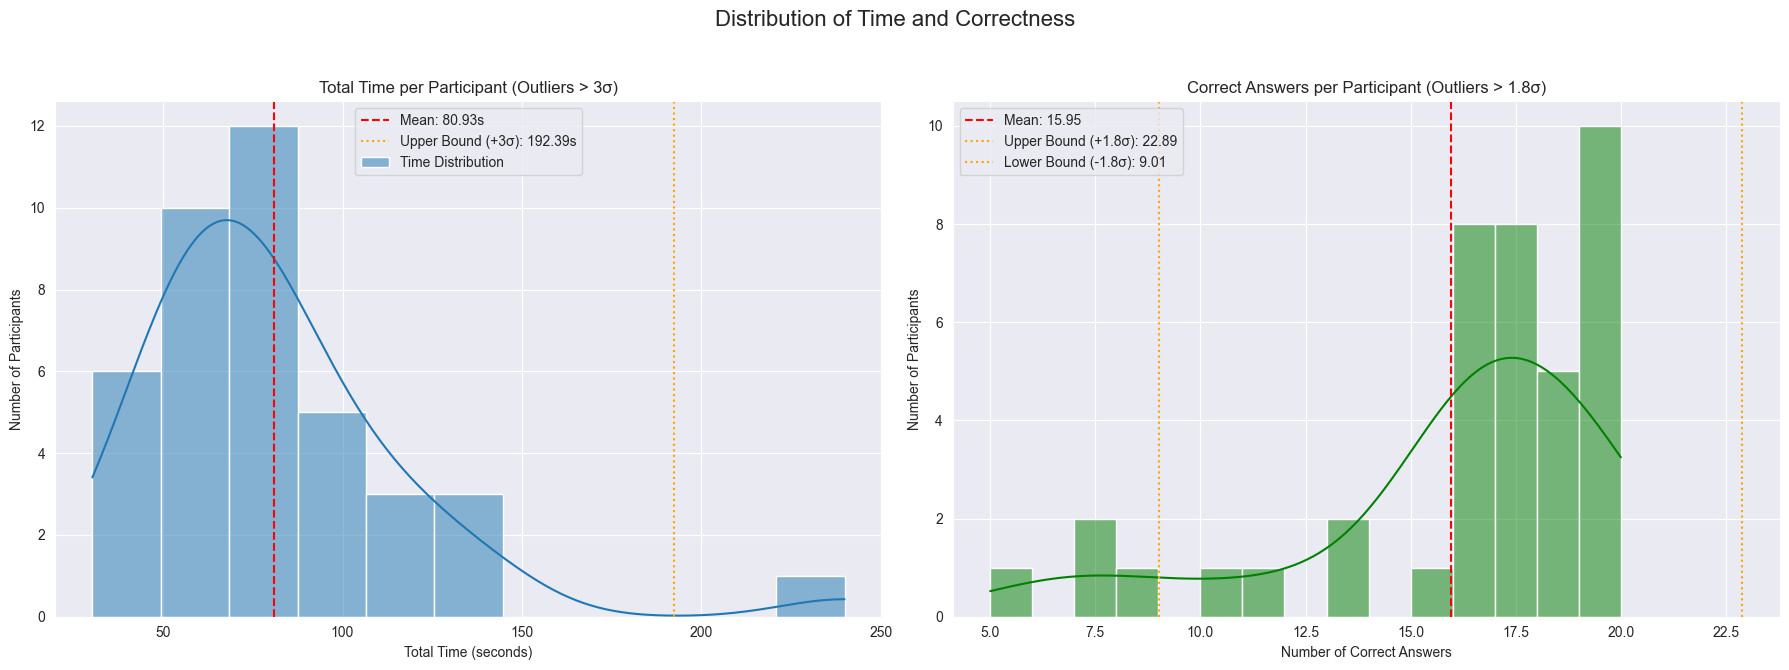

Time analysis: 1 participant(s) found as outliers outside of 3 standard deviations from the mean (80.93s).
Outlier participant(s) by ID and their total time:
       ID  (Time, mean)
16  31195       239.875

Correctness analysis: 4 participant(s) found as outliers outside of 1.8 standard deviations from the mean (15.95).
Outlier participant(s) by ID and their counts of correct answers:
       ID  (CorrectAnswer, count_nonzero)
4   12663                               7
5   13020                               7
11  24280                               5
16  31195                               8


In [20]:
aggregation_computation: dict[str, str] = {
    'CorrectAnswer': [np.count_nonzero,],
    'TypeAnnotation': ['count',],
    'Time': ['mean', 'median', 'min', 'max', 'sum',],
}

overview_correctness_time: DataFrame = df_results_overall.groupby(['ID']).agg(aggregation_computation).reset_index()


fig, axs = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Distribution of Time and Correctness', fontsize=16)

# Plot 1: Time Distribution
time_std_threshold = 3
time_col = ('Time', 'mean')
mean_time = overview_correctness_time[time_col].mean()
std_time = overview_correctness_time[time_col].std()
upper_bound_time = mean_time + time_std_threshold * std_time
lower_bound_time = mean_time - time_std_threshold * std_time
outliers_time = overview_correctness_time[(overview_correctness_time[time_col] > upper_bound_time) | (overview_correctness_time[time_col] < lower_bound_time)]

sns.histplot(overview_correctness_time[time_col], kde=True, ax=axs[0], label='Time Distribution')
axs[0].set_title(f'Total Time per Participant (Outliers > {time_std_threshold}σ)')
axs[0].set_xlabel('Total Time (seconds)')
axs[0].set_ylabel('Number of Participants')
axs[0].axvline(mean_time, color='red', linestyle='--', label=f'Mean: {mean_time:.2f}s')
axs[0].axvline(upper_bound_time, color='orange', linestyle=':', label=f'Upper Bound (+{time_std_threshold}σ): {upper_bound_time:.2f}s')
if lower_bound_time > 0:
    axs[0].axvline(lower_bound_time, color='orange', linestyle=':', label=f'Lower Bound (-{time_std_threshold}σ): {lower_bound_time:.2f}s')
axs[0].legend()


# Plot 2: Correct Answer Distribution
correct_std_threshold = 1.8
correct_col = ('CorrectAnswer', 'count_nonzero')
mean_correct = overview_correctness_time[correct_col].mean()
std_correct = overview_correctness_time[correct_col].std()
upper_bound_correct = mean_correct + correct_std_threshold * std_correct
lower_bound_correct = mean_correct - correct_std_threshold * std_correct

# Create a boolean Series for filtering
is_outlier_correct = (overview_correctness_time[correct_col] > upper_bound_correct) | (overview_correctness_time[correct_col] < lower_bound_correct)
outliers_correct = overview_correctness_time[is_outlier_correct]

sns.histplot(overview_correctness_time[correct_col], kde=True, ax=axs[1], color='green', binwidth=1)
axs[1].set_title(f'Correct Answers per Participant (Outliers > {correct_std_threshold}σ)')
axs[1].set_xlabel('Number of Correct Answers')
axs[1].set_ylabel('Number of Participants')
axs[1].axvline(mean_correct, color='red', linestyle='--', label=f'Mean: {mean_correct:.2f}')
axs[1].axvline(upper_bound_correct, color='orange', linestyle=':', label=f'Upper Bound (+{correct_std_threshold}σ): {upper_bound_correct:.2f}')
axs[1].axvline(lower_bound_correct, color='orange', linestyle=':', label=f'Lower Bound (-{correct_std_threshold}σ): {lower_bound_correct:.2f}')
axs[1].legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"Time analysis: {len(outliers_time)} participant(s) found as outliers outside of {time_std_threshold} standard deviations from the mean ({mean_time:.2f}s).")
if not outliers_time.empty:
    print("Outlier participant(s) by ID and their total time:")
    print(pd.concat([outliers_time['ID'], outliers_time[time_col]], axis=1))

print(f"\nCorrectness analysis: {len(outliers_correct)} participant(s) found as outliers outside of {correct_std_threshold} standard deviations from the mean ({mean_correct:.2f}).")
if not outliers_correct.empty:
    print("Outlier participant(s) by ID and their counts of correct answers:")
    print(pd.concat([outliers_correct['ID'], outliers_correct[correct_col]], axis=1))

In [21]:
# remove participants 12663, 13020, 24280, 31195
outlier_participants: list[str] = ['12663', '13020', '24280', '29206', '31195']
df_results_overall = df_results_overall[~df_results_overall['ID'].isin(outlier_participants)]
df_personal_information = df_personal_information[~df_personal_information['ID'].isin(outlier_participants)]
df_meta_data = df_meta_data[~df_meta_data['ID'].isin(outlier_participants)]
df_subjective_feelings = df_subjective_feelings[~df_subjective_feelings['ID'].isin(outlier_participants)]
df_difficulty_rating = df_difficulty_rating[~df_difficulty_rating['ID'].isin(outlier_participants)]

overview_correctness_time = overview_correctness_time[~overview_correctness_time['ID'].isin(outlier_participants)]

Now plot the distributions again

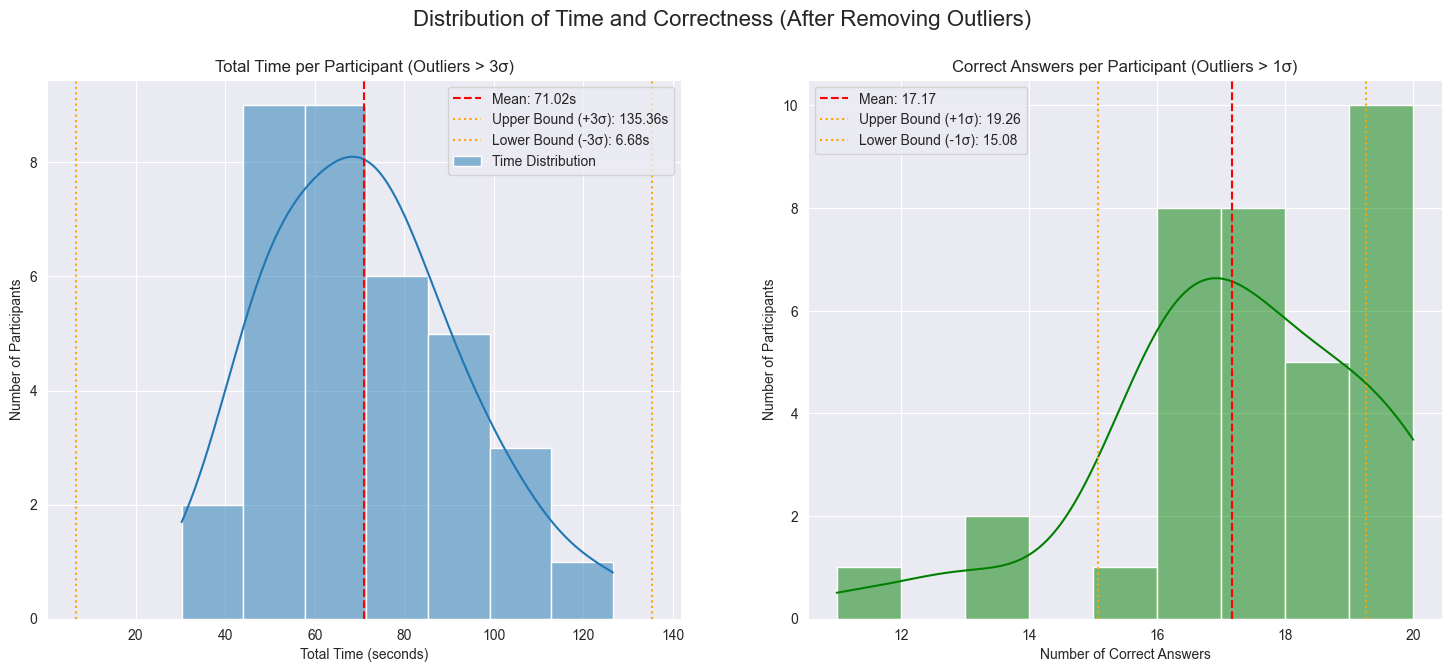

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Distribution of Time and Correctness (After Removing Outliers)', fontsize=16)
# Plot 1: Time Distribution
time_std_threshold = 3
time_col = ('Time', 'mean')
mean_time = overview_correctness_time[time_col].mean()
std_time = overview_correctness_time[time_col].std()
upper_bound_time = mean_time + time_std_threshold * std_time
lower_bound_time = mean_time - time_std_threshold * std_time
outliers_time = overview_correctness_time[(overview_correctness_time[time_col] > upper_bound_time) | (overview_correctness_time[time_col] < lower_bound_time)]

sns.histplot(overview_correctness_time[time_col], kde=True, ax=axs[0], label='Time Distribution')
axs[0].set_title(f'Total Time per Participant (Outliers > {time_std_threshold}σ)')
axs[0].set_xlabel('Total Time (seconds)')
axs[0].set_ylabel('Number of Participants')
axs[0].axvline(mean_time, color='red', linestyle='--', label=f'Mean: {mean_time:.2f}s')
axs[0].axvline(upper_bound_time, color='orange', linestyle=':', label=f'Upper Bound (+{time_std_threshold}σ): {upper_bound_time:.2f}s')
if lower_bound_time > 0:
    axs[0].axvline(lower_bound_time, color='orange', linestyle=':', label=f'Lower Bound (-{time_std_threshold}σ): {lower_bound_time:.2f}s')
axs[0].legend()

# Plot 2: Correct Answer Distribution
correct_std_threshold = 1
correct_col = ('CorrectAnswer', 'count_nonzero')
mean_correct = overview_correctness_time[correct_col].mean()
std_correct = overview_correctness_time[correct_col].std()
upper_bound_correct = mean_correct + correct_std_threshold * std_correct
lower_bound_correct = mean_correct - correct_std_threshold * std_correct

# Create a boolean Series for filtering
is_outlier_correct = (overview_correctness_time[correct_col] > upper_bound_correct) | (overview_correctness_time[correct_col] < lower_bound_correct)
outliers_correct = overview_correctness_time[is_outlier_correct]

sns.histplot(overview_correctness_time[correct_col], kde=True, ax=axs[1], color='green', binwidth=1)
axs[1].set_title(f'Correct Answers per Participant (Outliers > {correct_std_threshold}σ)')
axs[1].set_xlabel('Number of Correct Answers')
axs[1].set_ylabel('Number of Participants')
axs[1].axvline(mean_correct, color='red', linestyle='--', label=f'Mean: {mean_correct:.2f}')
axs[1].axvline(upper_bound_correct, color='orange', linestyle=':', label=f'Upper Bound (+{correct_std_threshold}σ): {upper_bound_correct:.2f}')
axs[1].axvline(lower_bound_correct, color='orange', linestyle=':', label=f'Lower Bound (-{correct_std_threshold}σ): {lower_bound_correct:.2f}')
axs[1].legend()

Now remove certain data points from response time. These are the highest 5%

In [23]:
# remove the outlier from the response time
print(f'95% quantile = {df_results_overall["Time"].quantile(0.95)} seconds')
print(f'5% quantile = {df_results_overall["Time"].quantile(0.05)} seconds')

q = df_results_overall['Time'].quantile(0.95)

df_results_overall = df_results_overall[df_results_overall['Time'] < q]
print(df_results_overall['Time'].describe())

95% quantile = 166.39999999999998 seconds
5% quantile = 19.0 seconds
count    658.000000
mean      63.914894
std       34.296656
min        8.000000
25%       38.000000
50%       57.000000
75%       87.000000
max      166.000000
Name: Time, dtype: float64


<Axes: xlabel='Time', ylabel='Count'>

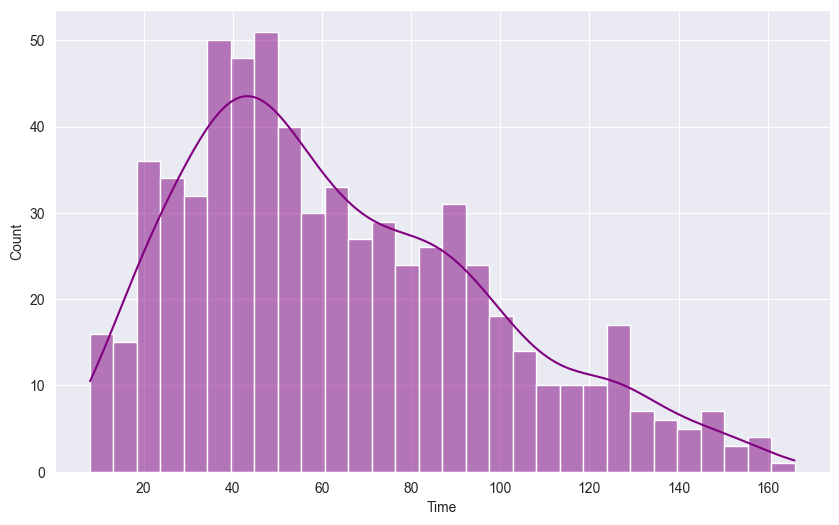

In [24]:
# plot the distribution of the response time
plt.figure(figsize=(10, 6))
sns.histplot(df_results_overall['Time'], kde=True, bins=30, color='purple')

Analyse Number of Fixations and Fixations Per Second

In [25]:
# Add new column for true fixations per second
df_results_overall["TrueFixationsPerSecond"] = (
    df_results_overall["NumberOfFixations"] / df_results_overall["Time"]
)

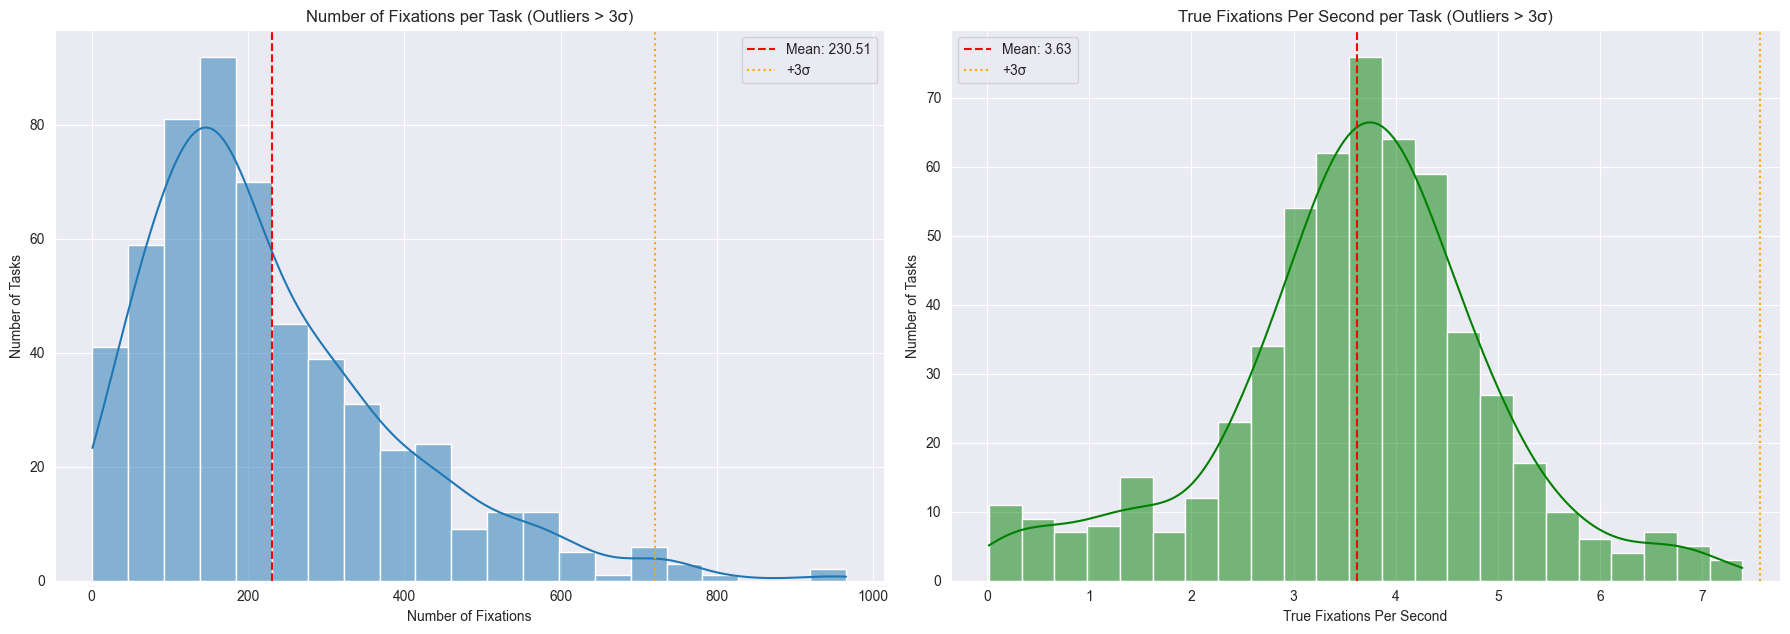

In [26]:
# Plot distributions: Number of Fixations and True Fixations Per Second
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Number of Fixations Distribution ---
fixations_std_threshold = 3
fixations_col = "NumberOfFixations"
mean_fixations = df_results_overall[fixations_col].mean()
std_fixations = df_results_overall[fixations_col].std()
upper_bound_fixations = mean_fixations + fixations_std_threshold * std_fixations
lower_bound_fixations = mean_fixations - fixations_std_threshold * std_fixations

sns.histplot(df_results_overall[fixations_col], kde=True, ax=axs[0])
axs[0].set_title(f'Number of Fixations per Task (Outliers > {fixations_std_threshold}σ)')
axs[0].set_xlabel("Number of Fixations")
axs[0].set_ylabel("Number of Tasks")
axs[0].axvline(mean_fixations, color="red", linestyle="--", label=f"Mean: {mean_fixations:.2f}")
axs[0].axvline(upper_bound_fixations, color="orange", linestyle=":", label=f"+{fixations_std_threshold}σ")
if lower_bound_fixations > 0:
    axs[0].axvline(lower_bound_fixations, color="orange", linestyle=":", label=f"-{fixations_std_threshold}σ")
axs[0].legend()

# --- Plot 2: True Fixations Per Second Distribution ---
fixations_per_sec_std_threshold = 3
fixations_per_sec_col = "TrueFixationsPerSecond"
mean_fixations_per_sec = df_results_overall[fixations_per_sec_col].mean()
std_fixations_per_sec = df_results_overall[fixations_per_sec_col].std()
upper_bound_fixations_per_sec = mean_fixations_per_sec + fixations_per_sec_std_threshold * std_fixations_per_sec
lower_bound_fixations_per_sec = mean_fixations_per_sec - fixations_per_sec_std_threshold * std_fixations_per_sec

sns.histplot(df_results_overall[fixations_per_sec_col], kde=True, ax=axs[1], color="green")
axs[1].set_title(f'True Fixations Per Second per Task (Outliers > {fixations_per_sec_std_threshold}σ)')
axs[1].set_xlabel("True Fixations Per Second")
axs[1].set_ylabel("Number of Tasks")
axs[1].axvline(mean_fixations_per_sec, color="red", linestyle="--", label=f"Mean: {mean_fixations_per_sec:.2f}")
axs[1].axvline(upper_bound_fixations_per_sec, color="orange", linestyle=":", label=f"+{fixations_per_sec_std_threshold}σ")
if lower_bound_fixations_per_sec > 0:
    axs[1].axvline(lower_bound_fixations_per_sec, color="orange", linestyle=":", label=f"-{fixations_per_sec_std_threshold}σ")
axs[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [27]:
# df with only id, task, correctanswer, time, number of fixations, true fixations per second
df_analysis: DataFrame = df_results_overall[['ID', 'Task', 'CorrectAnswer', 'Time', 'NumberOfFixations', 'TrueFixationsPerSecond', 'Meaningful', 'TypeAnnotation']]
df_analysis

,ID,Task,CorrectAnswer,Time,NumberOfFixations,TrueFixationsPerSecond,Meaningful,TypeAnnotation
0,10066,linearSearch,True,27,98.0,3.629630,True,True
1,10066,crossSum,True,30,137.0,4.566667,True,True
2,10066,forwardBackward,True,75,249.0,3.320000,True,True
3,10066,unrolledSort,True,53,162.0,3.056604,True,True
4,10066,validParentheses,True,128,532.0,4.156250,True,False
...,...,...,...,...,...,...,...,...
748,93795,unrolledSort,True,32,120.0,3.750000,False,False
749,93795,binarySearch,True,89,49.0,0.550562,False,True
750,93795,countLetters,True,51,NaN,NaN,False,True
751,93795,palindrome,True,50,NaN,NaN,False,True


In [28]:
print(len(df_results_overall['ID'].value_counts()))
# print number of particpants in meaningful and meaningless group
print(f'Number of participants in meaningful group: {len(df_personal_information[df_personal_information["Meaningful"] == True])}')
print(f'Number of participants in meaningless group: {len(df_personal_information[df_personal_information["Meaningful"] == False])}')

35
Number of participants in meaningful group: 17
Number of participants in meaningless group: 18


In [29]:
print(df_personal_information.CourseOfStudy.value_counts(normalize=True))

CourseOfStudy
Computer Science                            0.400000
Cybersecurity                               0.257143
Data Science and Artificial Intelligence    0.085714
Media Informatics                           0.085714
Embedded Systems                            0.057143
Mathematics and Computer Science            0.057143
Business Informatics                        0.028571
Computational Linguistics                   0.028571
Name: proportion, dtype: float64


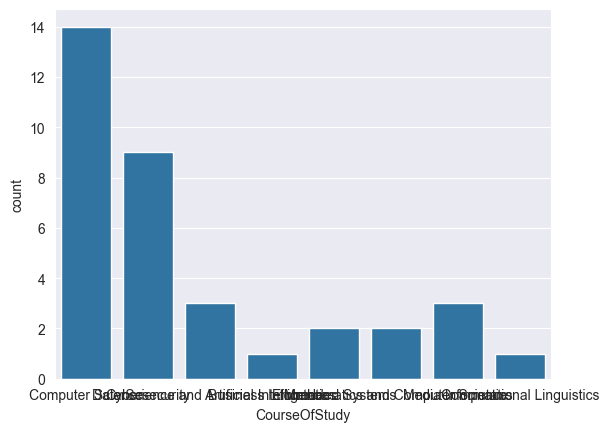

In [30]:
sns.countplot(df_personal_information, x='CourseOfStudy')
plt.show()


### People Distributions and Data

1. The age
2. Their experience
3. Their Course of Study

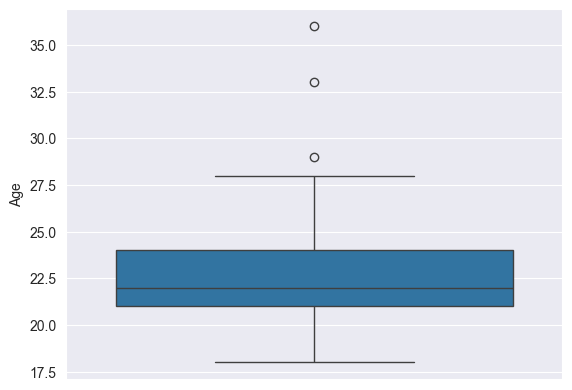

In [31]:
sns.boxplot(data=df_personal_information, y='Age',)
plt.show()

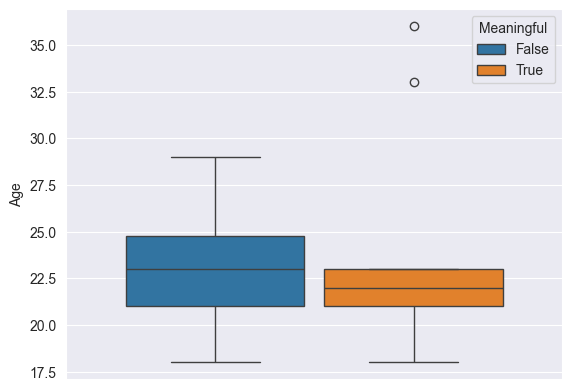

False -> Mean: 23.17, SD: 2.96
True -> Mean: 22.82, SD: 4.63


In [32]:
sns.boxplot(data=df_personal_information, y='Age', hue='Meaningful', gap=.1)
plt.show()

# Calculate mean and standard deviation
group_stats = df_personal_information.groupby('Meaningful')['Age'].agg(['mean', 'std'])

# Print values
for group, group_data in group_stats.iterrows():
    print(f"{group} -> Mean: {group_data['mean']:.2f}, SD: {group_data['std']:.2f}")

The courses of study

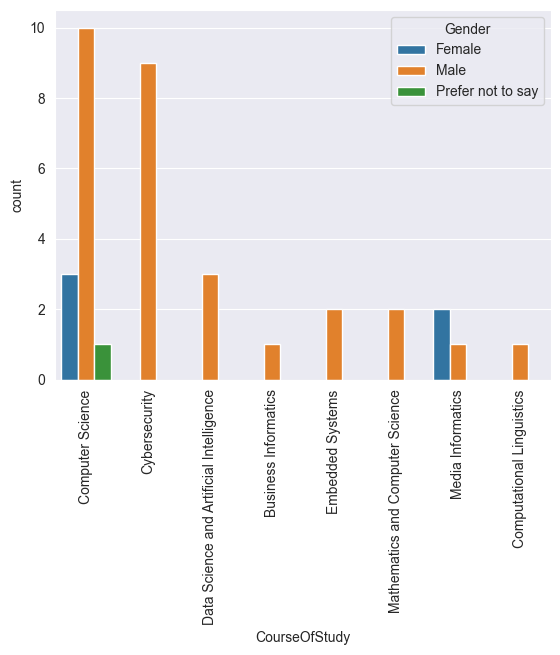

In [33]:
sns.countplot(data=df_personal_information, x='CourseOfStudy',hue='Gender')
plt.xticks(rotation=90)
plt.show()

The number of semesters

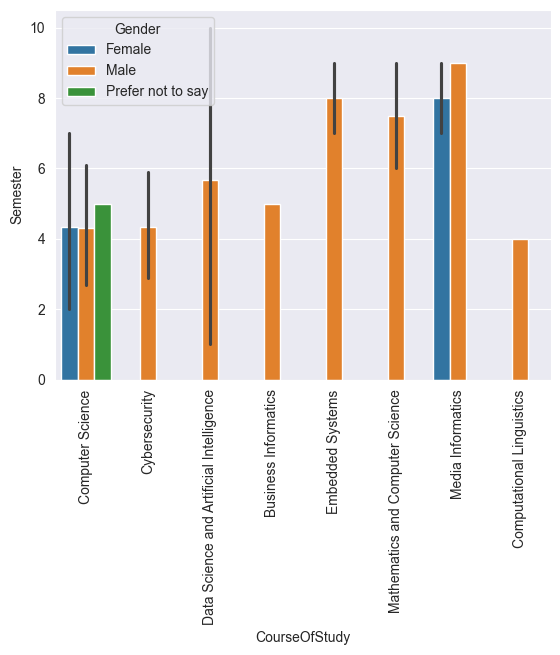

In [34]:
sns.barplot(data=df_personal_information, x='CourseOfStudy',hue='Gender', y='Semester')
plt.xticks(rotation=90)
plt.show()

The number of semesters in general

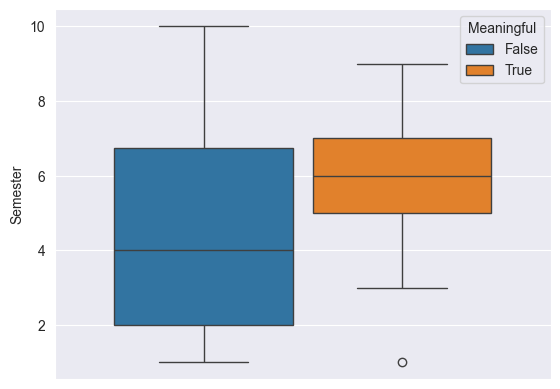

False -> Mean: 4.50, SD: 3.11
True -> Mean: 5.94, SD: 2.36


In [35]:
sns.boxplot(data=df_personal_information, y='Semester', hue='Meaningful', gap=.1,)
plt.show()

# Calculate mean and standard deviation
group_stats = df_personal_information.groupby('Meaningful')['Semester'].agg(['mean', 'std'])

# Print values
for group, group_data in group_stats.iterrows():
    print(f"{group} -> Mean: {group_data['mean']:.2f}, SD: {group_data['std']:.2f}")

Classmates and overall experience

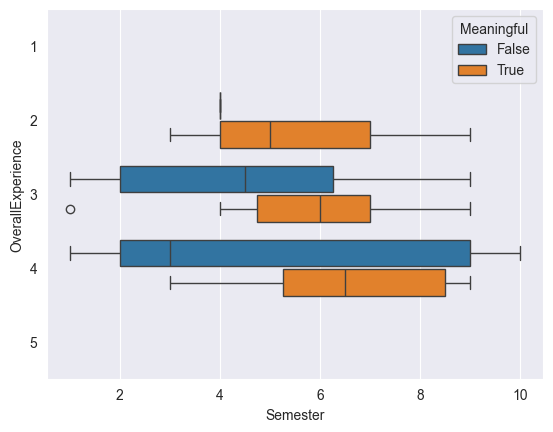

In [36]:
sns.boxplot(data=df_personal_information, y='OverallExperience', x='Semester', hue='Meaningful', gap=.1, 
            # order=['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced']
            )
plt.show()

Classmates

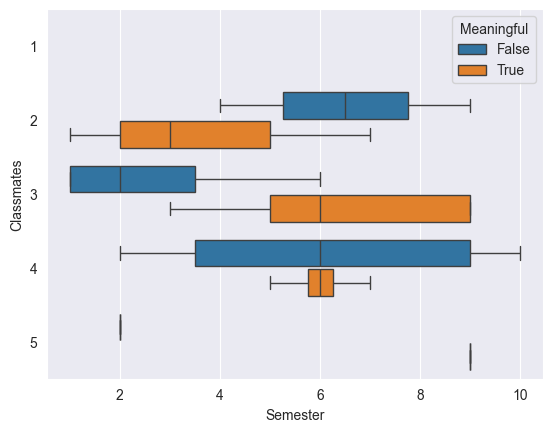

In [37]:
sns.boxplot(data=df_personal_information, 
            y='Classmates', 
            x='Semester', 
            hue='Meaningful', 
            gap=.1, 
            # order=['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'],
            )
plt.show()

OverallExperience by ProgrammingLately

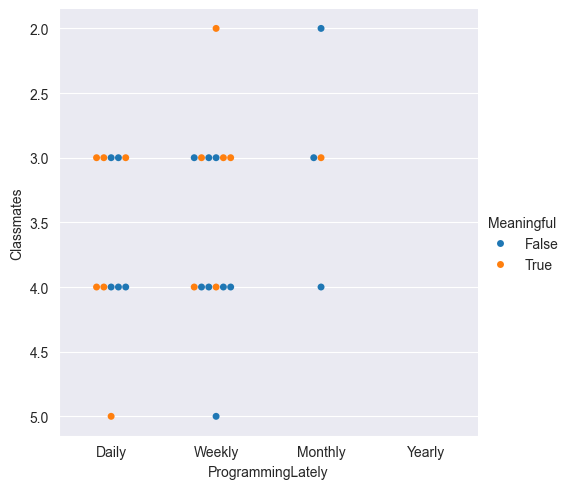

In [38]:
sns.catplot(data=df_personal_information,
            x='ProgrammingLately',
            y='Classmates',
            hue='Meaningful',
            # gap=.1,
            order=['Daily', 'Weekly', 'Monthly', 'Yearly'],
            kind='swarm'
            )
plt.show()

#### Standard Data for the personal information

In [39]:
print(f'Age:\n{df_personal_information["Age"].describe()}\n')
print(f'Semester:\n{df_personal_information["Semester"].describe()}\n')
print(f'YearsProgramming:\n{df_personal_information["YearsProgramming"].describe()}\n')
print(f'Gender:\n{df_personal_information.groupby("Gender").agg({"Gender": "count"})}\n')
print(f'Classmates:\n{df_personal_information.groupby("Classmates").agg({"Classmates": "count"})}\n')

Age:
count    35.000000
mean     23.000000
std       3.804023
min      18.000000
25%      21.000000
50%      22.000000
75%      24.000000
max      36.000000
Name: Age, dtype: float64

Semester:
count    35.000000
mean      5.200000
std       2.826347
min       1.000000
25%       3.000000
50%       5.000000
75%       7.000000
max      10.000000
Name: Semester, dtype: float64

YearsProgramming:
count    35.000000
mean      5.228571
std       2.901173
min       1.000000
25%       3.000000
50%       5.000000
75%       7.000000
max      12.000000
Name: YearsProgramming, dtype: float64

Gender:
                   Gender
Gender                   
Female                  5
Male                   29
Prefer not to say       1

Classmates:
            Classmates
Classmates            
1                    0
2                    5
3                   16
4                   12
5                    2



/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1011207774.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'Gender:\n{df_personal_information.groupby("Gender").agg({"Gender": "count"})}\n')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1011207774.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'Classmates:\n{df_personal_information.groupby("Classmates").agg({"Classmates": "count"})}\n')


Standard Data for personal information divided by Meaningful Data

In [40]:
print(f'Age:\n{df_personal_information.groupby("Meaningful").agg({"Age": ["mean", "std"]})}')
print(f'Semester:\n{df_personal_information.groupby("Meaningful").agg({"Semester": ["mean", "std"]})}\n')
print(f'YearsProgramming:\n{df_personal_information.groupby("Meaningful").agg({"YearsProgramming": ["mean", "std"]})}\n')
print(f'Gender:\n{df_personal_information.groupby(["Meaningful", "Gender"]).agg({"Gender": "count"})}\n')
print(f'EyeSight:\n{df_personal_information.groupby(["Meaningful", "Eyesight"]).agg({"Eyesight": "count"})}\n')
print(f'StudyBefore:\n{df_personal_information.groupby(["Meaningful", "StudyBefore"]).agg({"StudyBefore": "count"})}\n')

Age:
                  Age          
                 mean       std
Meaningful                     
False       23.166667  2.955553
True        22.823529  4.626490
Semester:
            Semester          
                mean       std
Meaningful                    
False       4.500000  3.110703
True        5.941176  2.357716

YearsProgramming:
           YearsProgramming          
                       mean       std
Meaningful                           
False              5.444444  3.329409
True               5.000000  2.449490

Gender:
                              Gender
Meaningful Gender                   
False      Female                  3
           Male                   15
           Prefer not to say       0
True       Female                  2
           Male                   14
           Prefer not to say       1

EyeSight:
                                                             Eyesight
Meaningful Eyesight                                                  
False

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1644175717.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'Gender:\n{df_personal_information.groupby(["Meaningful", "Gender"]).agg({"Gender": "count"})}\n')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1644175717.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'EyeSight:\n{df_personal_information.groupby(["Meaningful", "Eyesight"]).agg({"Eyesight": "count"})}\n')


Efficacy for every participant:


Efficacy of Participant ('10066', False): 1.1739130434782608
Efficacy of Participant ('10066', True): 1.3636363636363638
Efficacy of Participant ('10723', False): 0.6837606837606838
Efficacy of Participant ('10723', True): 0.7457627118644068
Efficacy of Participant ('10920', False): 1.3399503722084367
Efficacy of Participant ('10920', True): 1.375
Efficacy of Participant ('12480', False): 1.139240506329114
Efficacy of Participant ('12480', True): 0.8433734939759036
Efficacy of Participant ('14296', False): 0.8674698795180723
Efficacy of Participant ('14296', True): 0.6700507614213197
Efficacy of Participant ('18457', False): 0.903387703889586
Efficacy of Participant ('18457', True): 0.7877461706783371
Efficacy of Participant ('18868', False): 0.8888888888888888
Efficacy of Participant ('18868', True): 0.8032128514056225
Efficacy of Participant ('23559', False): 0.7105263157894737
Efficacy of Participant ('23559', True): 0.7879924953095685
Efficacy of Participant ('23993', False): 1.018

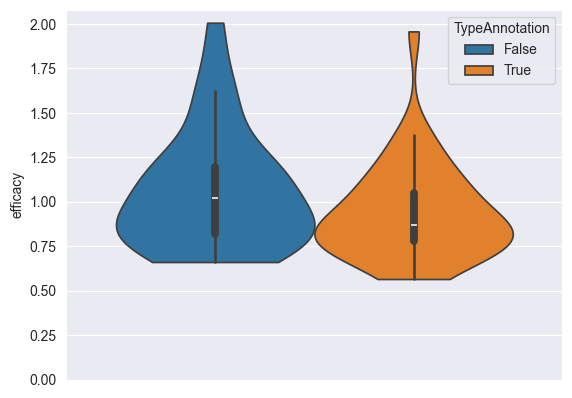

In [41]:
df = df_results_overall.groupby(['ID', 'TypeAnnotation']).agg({'Time': 'sum', 'CorrectAnswer': 'count'})
df['efficacy'] = df.CorrectAnswer / (df.Time / 60) 
# df.columns.droplevel(0)
# print(df)
for index, row in df.iterrows():
    print(f'Efficacy of Participant {index}: {row.CorrectAnswer / (row.Time / 60)}')

sns.violinplot(df, y='efficacy', hue='TypeAnnotation', cut=0)
plt.ylim(bottom=0)
plt.show()

Statistical Methods one after the other

In [42]:
from statsmodels.tsa.stattools import acf
def compute_statistics(data: DataFrame, with_TA, without_TA, input_type: str = 'continuous', output_type: str = 'contiuous', population: str = 'within', p_value: float = 0.05):

    # input_dependence: str = 'independent',

    # check for normality
    with_TA_normality = stats.shapiro(with_TA)
    without_TA_normality = stats.shapiro(without_TA)

    # print(with_TA)
    # print(without_TA)

    # check for homogeneity of variance
    homogeneity_of_variance = stats.levene(with_TA, without_TA)
    # print(homogeneity_of_variance)

    if with_TA_normality.pvalue > p_value and without_TA_normality.pvalue > p_value:
        print(f'Both groups are normally distributed with pvalues {with_TA_normality.pvalue} and {without_TA_normality.pvalue}')
    else:
        print(f'At least one group is not normally distributed with pvalues {with_TA_normality.pvalue} and {without_TA_normality.pvalue}')

    if homogeneity_of_variance.pvalue > p_value:
        print(f'Both groups have homogeneity of variance with pvalue {homogeneity_of_variance.pvalue}')
    else:
        print(f'Both groups do not have homogeneity of variance with pvalue {homogeneity_of_variance.pvalue}')

    if with_TA_normality.pvalue > p_value and without_TA_normality.pvalue > p_value and homogeneity_of_variance.pvalue > p_value:
        if population == 'within':
            if input_type == 'categorical' and output_type == 'continuous':
                print(f'TTEST_REL: {stats.ttest_rel(without_TA, with_TA)}')
            elif input_type == 'categorical' and output_type == 'categorical':
                print(f'CHISQUARE: {stats.chisquare(without_TA, with_TA)}')
            elif len(with_TA) == len(without_TA):
                print(f'WILCOXON TWO-SIDED: {stats.wilcoxon(without_TA, with_TA)}')
                print(f'WILCOXON ONE-SIDED Greater: {stats.wilcoxon(without_TA, with_TA, alternative="greater")}')
                print(f'WILCOXON ONE-SIDED Less: {stats.wilcoxon(without_TA, with_TA, alternative="less")}')
            else:
                print(f'MANNWHITNEYU: {stats.mannwhitneyu(without_TA, with_TA)}')

        else:
            if input_type == 'categorical' and output_type == 'continuous':
                print(f'TTEST_IND: {stats.ttest_ind(without_TA, with_TA)}')
            else:
                print(f'MANNWHITNEYU: {stats.mannwhitneyu(without_TA, with_TA)}')

    else:
        if population == 'within' and len(with_TA) == len(without_TA):
            print(f'WILCOXON TWO-SIDED: {stats.wilcoxon(without_TA, with_TA)}')
        elif input_type == 'categorical' and output_type == 'categorical':
            print(f'CHISQUARE: {stats.chi2_contingency(without_TA, with_TA)}')
        else:
            u_statistic, p_value = stats.mannwhitneyu(without_TA, with_TA)
            print(f'The U-statistic is {u_statistic} and the p-value is {p_value}')

    return data

#### Table for Type Annotations and Correctness RQ 1.1

Do everything correctly for time

1. Check for normality
2. Check for the variances
3. then check for wilcoxon two-sided
4. then check for wilcoxon one-sided


In [43]:
table_data: dict[str, list[str]|str] = {
    'Time': ['mean', 'std'],
    'CorrectAnswer': ['sum', 'count'],
}

table: DataFrame = df_results_overall.groupby(['Task']).agg(table_data)

TA_mean = df_results_overall.query('TypeAnnotation == True')['Time']
NoTA_mean = df_results_overall.query('TypeAnnotation == False')['Time']

# qq = stats.probplot(TA_mean, dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

data = compute_statistics(table, TA_mean, NoTA_mean, input_type='categorical', output_type='continuous', population='within')

# print(f'{TA_mean.describe()} and {NoTA_mean.describe()}')

# qq = stats.probplot(NoTA_mean, dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

# print(f'Normality of TA:\n{stats.shapiro(TA_mean)}')
# print(f'Normality of NoTA:\n{stats.shapiro(NoTA_mean)}')

# print(f'Levene Test:\n{stats.levene(TA_mean, NoTA_mean)}')

# print(f'WILCOXON:\n{stats.wilcoxon(NoTA_mean, TA_mean)}')
# print(f'WILCOXON Longer with TA:\n{stats.wilcoxon(NoTA_mean, TA_mean, alternative="greater")}')
# print(f'WILCOXON Shorter with TA:\n{stats.wilcoxon(NoTA_mean, TA_mean, alternative="less")}')
for task_tuple, x in table.iterrows():
    print(f'{task_tuple} & {x.CorrectAnswer["sum"]}/{x.CorrectAnswer["count"]} ({round((x.CorrectAnswer["sum"]/x.CorrectAnswer["count"])*100)}\%) & {round(x.Time["mean"],2)} $\pm$ {round(x.Time["std"],2)}\\\\')

print(f'{df_results_overall.Time.mean()} + {df_results_overall.Time.std()} | {df_results_overall.CorrectAnswer.sum()}/{df_results_overall.CorrectAnswer.count()} ({df_results_overall.CorrectAnswer.sum()/df_results_overall.CorrectAnswer.count()})')

At least one group is not normally distributed with pvalues 5.8614500011107735e-09 and 1.2653969016094531e-08
Both groups have homogeneity of variance with pvalue 0.6926161088101692
The U-statistic is 48059.5 and the p-value is 0.01715966727474546
arrayAverage & 33.0/34.0 (97\%) & 57.47 $\pm$ 24.12\\
binarySearch & 26.0/28.0 (93\%) & 86.36 $\pm$ 33.97\\
binaryToDecimal & 28.0/33.0 (85\%) & 72.48 $\pm$ 26.92\\
bubbleSort & 26.0/31.0 (84\%) & 81.06 $\pm$ 34.55\\
capitalizeFirstLetter & 32.0/33.0 (97\%) & 90.88 $\pm$ 34.13\\
commonChars & 25.0/35.0 (71\%) & 52.71 $\pm$ 28.17\\
containsSubstring & 21.0/27.0 (78\%) & 88.04 $\pm$ 33.5\\
countIntegerInterval & 24.0/34.0 (71\%) & 76.94 $\pm$ 24.62\\
countLetters & 31.0/34.0 (91\%) & 55.0 $\pm$ 30.19\\
crossSum & 26.0/33.0 (79\%) & 37.52 $\pm$ 15.43\\
factorial & 33.0/35.0 (94\%) & 24.49 $\pm$ 17.0\\
forwardBackward & 33.0/34.0 (97\%) & 75.53 $\pm$ 25.86\\
leastCommonMultiple & 30.0/34.0 (88\%) & 54.06 $\pm$ 24.87\\
linearSearch & 31.0/35.0 (89

<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\p'
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/963292543.py:32: SyntaxWarning: invalid escape sequence '\%'
  print(f'{task_tuple} & {x.CorrectAnswer["sum"]}/{x.CorrectAnswer["count"]} ({round((x.CorrectAnswer["sum"]/x.CorrectAnswer["count"])*100)}\%) & {round(x.Time["mean"],2)} $\pm$ {round(x.Time["std"],2)}\\\\')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/963292543.py:32: SyntaxWarning: invalid escape sequence '\p'
  print(f'{task_tuple} & {x.CorrectAnswer["sum"]}/{x.CorrectAnswer["count"]} ({round((x.CorrectAnswer["sum"]/x.CorrectAnswer["count"])*100)}\%) & {round(x.Time["mean"],2)} $\pm$ {round(x.Time["std"],2)}\\\\')


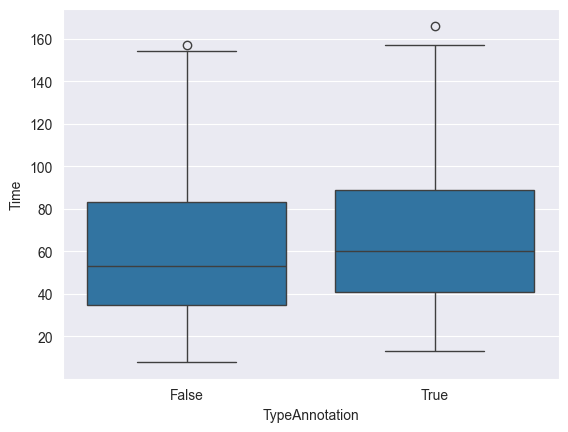

False -> Mean: 60.56, SD: 33.84
True -> Mean: 66.83, SD: 34.48


In [44]:
sns.boxplot(data=df_results_overall, y='Time', x='TypeAnnotation')
plt.show()

# Calculate mean and standard deviation
group_stats = df_results_overall.groupby('TypeAnnotation')['Time'].agg(['mean', 'std'])

# Print values
for group, group_data in group_stats.iterrows():
    print(f"{group} -> Mean: {group_data['mean']:.2f}, SD: {group_data['std']:.2f}")

Do the same as above for the correctness

In [45]:
# percentage_TA = table.query("TypeAnnotation == True")["Correctness"]
# percentage_NoTA = table.query("TypeAnnotation == False")["Correctness"]

# please create a contingency table for CorrectAnswer on TypeAnnotation

contingency_table = pd.crosstab(df_results_overall['TypeAnnotation'], df_results_overall['CorrectAnswer'])
print(stats.chi2_contingency(contingency_table))
print(contingency_table)

try:
    data = compute_statistics(DataFrame(), df_results_overall.query("TypeAnnotation == True")["CorrectAnswer"], df_results_overall.query("TypeAnnotation == False")["CorrectAnswer"], input_type='categorical', output_type='categorical', population='within')
except:
    pass

print(df_results_overall.groupby('TypeAnnotation')['CorrectAnswer'].agg(['sum', 'count']))

Chi2ContingencyResult(statistic=np.float64(0.49819900218084534), pvalue=np.float64(0.4802925356680511), dof=1, expected_freq=array([[ 39.52887538, 266.47112462],
       [ 45.47112462, 306.52887538]]))
CorrectAnswer   False  True 
TypeAnnotation              
False              36    270
True               49    303
At least one group is not normally distributed with pvalues 2.8021917197618697e-32 and 4.3638724597570105e-31
Both groups have homogeneity of variance with pvalue 0.4116480998261084
                sum  count
TypeAnnotation            
False           270    306
True            303    352


#### Measures for RQ 1.2

First we should check for VerticalNext, VerticalLater, Regression, HorizontalLater, and LineRegression

But first let's create the table to analyze

In [46]:
list_measure: list[str] = ['VerticalNext', 'VerticalLater', 'Regression', 'HorizontalLater', 'LineRegression', 'StoryOrder_Naive_Score','StoryOrder_Dynamic_Score','StoryOrder_Dynamic_Repetitions', 'SaccadeLength']

table: DataFrame = df_results_overall.groupby(['Task', 'TypeAnnotation']).agg(table_data)
table.dropna(inplace=True)

In [47]:
for measure in list_measure:
    print(f'\nMeasure: {measure}')
    data = compute_statistics(table, df_results_overall.query("TypeAnnotation == True")[measure].dropna(), df_results_overall.query("TypeAnnotation == False")[measure].dropna(), input_type='categorical', output_type='continuous', population='within')


Measure: VerticalNext
At least one group is not normally distributed with pvalues 7.040768815770285e-06 and 6.87562787053013e-13
Both groups have homogeneity of variance with pvalue 0.459112073621493
The U-statistic is 38931.5 and the p-value is 0.803769267145946

Measure: VerticalLater
At least one group is not normally distributed with pvalues 0.002659061534225923 and 2.5642289697241656e-09
Both groups have homogeneity of variance with pvalue 0.4540640455404702
The U-statistic is 39720.0 and the p-value is 0.5055572067792051

Measure: Regression
At least one group is not normally distributed with pvalues 0.0033119462882350084 and 0.02699891225838535
Both groups have homogeneity of variance with pvalue 0.4086825692813453
The U-statistic is 38492.5 and the p-value is 0.9871216480527417

Measure: HorizontalLater
At least one group is not normally distributed with pvalues 0.00446668265748694 and 5.3081264204322104e-08
Both groups have homogeneity of variance with pvalue 0.06073302213364

#### Measures for RQ 1.3

This should include:

1. The difficulty for each of the snippets as giving by the people.
2. Did the Type Annotations help with the snippets?
3. Do Type Annotations help in general?

Do a likert scale analysis of the difficulty 

<Figure size 1000x600 with 0 Axes>

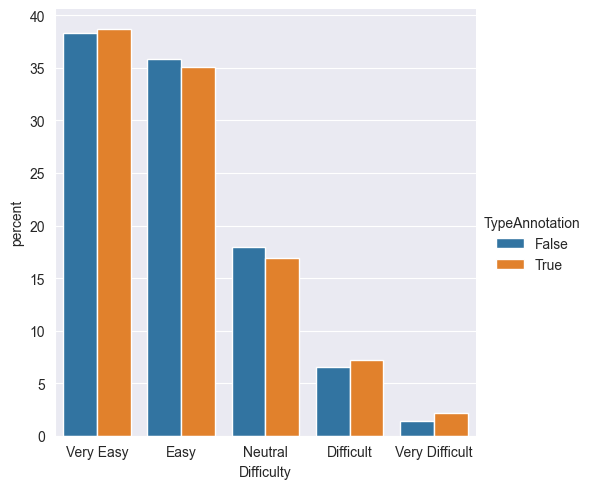

In [48]:
df1 = df_results_overall.groupby('TypeAnnotation')['Difficulty'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

plt.figure(figsize=(10, 6))
sns.catplot(x='Difficulty', 
            hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
            #legend=False,
)

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
# plt.title('Difficulty grouped by Type Annotation')
# plt.legend(title='Type Annotation', loc='upper right', labels=['Non-Annotated', 'Annotated'])
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/rq13difficultyLikertCatPlot.pdf', bbox_inches='tight')
plt.show()

And now with meaningful

    Meaningful  TypeAnnotation Difficulty    percent
10        True           False          2  38.157895
11        True           False          1  37.500000
12        True           False          3  16.447368
13        True           False          4   7.236842
14        True           False          5   0.657895
15        True            True          1  45.394737
16        True            True          2  36.842105
17        True            True          3  12.500000
18        True            True          4   4.605263
19        True            True          5   0.657895


<Figure size 1000x600 with 0 Axes>

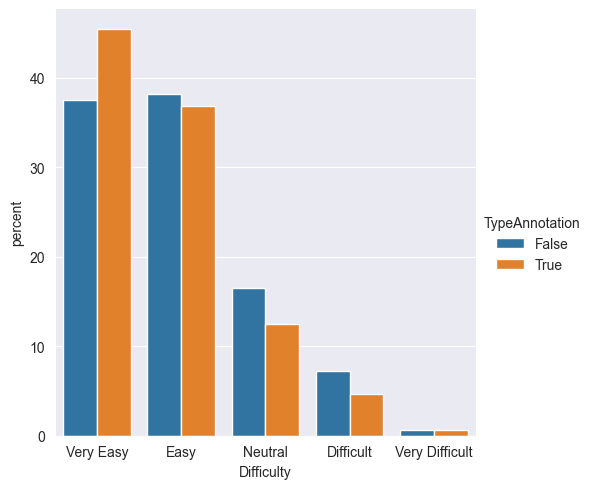

In [49]:
df1 = df_results_overall.groupby(['Meaningful', 'TypeAnnotation'])['Difficulty'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

print(df1[df1['Meaningful'] == True])

plt.figure(figsize=(10, 6))
sns.catplot(x='Difficulty', 
            hue='TypeAnnotation', 
            data=df1[df1['Meaningful'] == True], 
            kind='bar',
            y='percent',
)

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
# plt.title('Difficulty grouped by Meaningful')
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight', dpi=1200)
plt.show()

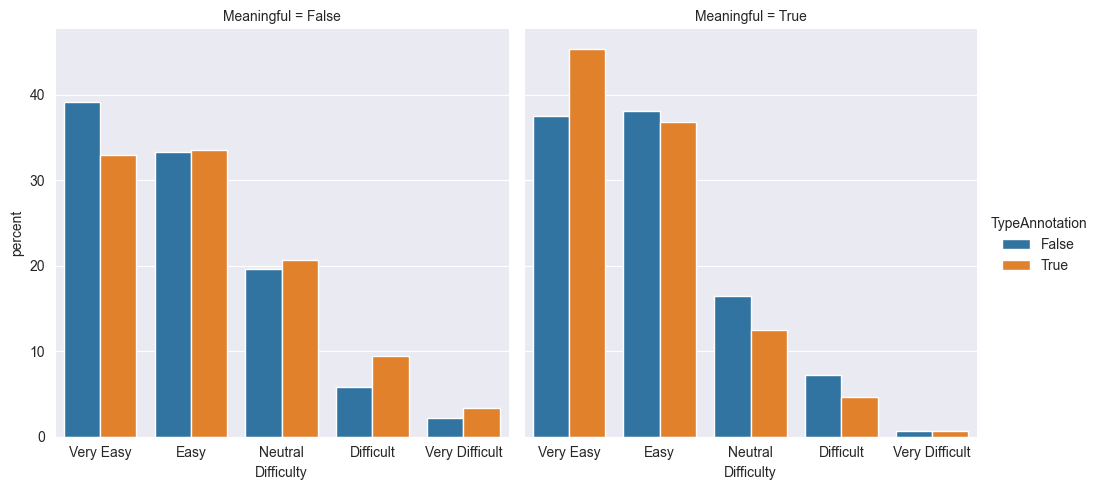

In [50]:
df1 = df_results_overall.groupby(['Meaningful', 'TypeAnnotation'])['Difficulty'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

# plt.figure(figsize=(10, 6))
# g = sns.FacetGrid(df1, col='Meaningful', hue='TypeAnnotation')
# g.map(sns.stripplot, 'Difficulty', 'percent', kind='bar')
sns.catplot(x='Difficulty', 
            hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
            col='Meaningful',
)

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
# plt.title('Difficulty grouped by Meaningful')
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotCombined.pdf', bbox_inches='tight', dpi=1200)
plt.show()

And now both?

<Figure size 1000x600 with 0 Axes>

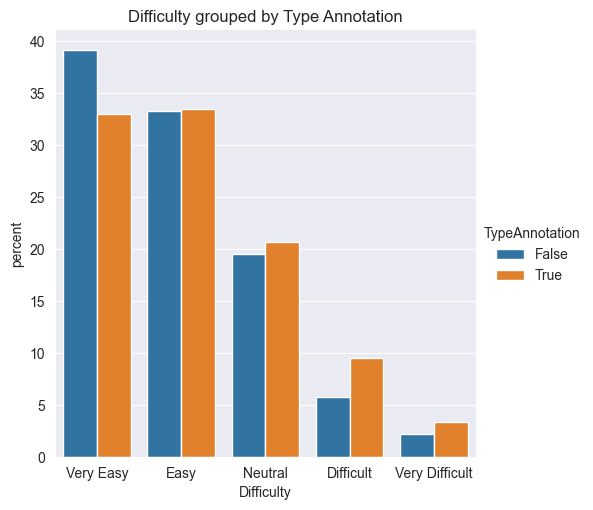

In [51]:
plt.figure(figsize=(10, 6))
sns.catplot(x='Difficulty', 
            hue='TypeAnnotation', 
            data=df1[df1['Meaningful'] == False], 
            kind='bar',
            y='percent',
)

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
plt.title('Difficulty grouped by Type Annotation')
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotObfuscated.pdf', bbox_inches='tight')
plt.show()

Can we also find a statistical significance for this? using the chisquare test?

In [52]:
contingency_table = pd.crosstab(df_results_overall['TypeAnnotation'], df_results_overall['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(0.7076360437950615), pvalue=np.float64(0.9503839132501076), dof=4, expected_freq=array([[111.61030596, 102.73752013,  50.43478261,  20.0805153 ,
          5.13687601],
       [127.38969404, 117.26247987,  57.56521739,  22.9194847 ,
          5.86312399]]))
Difficulty        1    2   3   4  5
TypeAnnotation                     
False           111  104  52  19  4
True            128  116  56  24  7


In [53]:
cont_df = df_results_overall[df_results_overall['Meaningful'] == True]
contingency_table = pd.crosstab(cont_df['TypeAnnotation'], cont_df['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(2.8850155692260957), pvalue=np.float64(0.5772484634860002), dof=4, expected_freq=array([[63., 57., 22.,  9.,  1.],
       [63., 57., 22.,  9.,  1.]]))
Difficulty       1   2   3   4  5
TypeAnnotation                   
False           57  58  25  11  1
True            69  56  19   7  1


In [54]:
cont_df = df_results_overall[df_results_overall['Meaningful'] == False]
contingency_table = pd.crosstab(cont_df['TypeAnnotation'], cont_df['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(2.613678560466982), pvalue=np.float64(0.6244019485932182), dof=4, expected_freq=array([[49.19242902, 46.14511041, 27.86119874, 10.88328076,  3.91798107],
       [63.80757098, 59.85488959, 36.13880126, 14.11671924,  5.08201893]]))
Difficulty       1   2   3   4  5
TypeAnnotation                   
False           54  46  27   8  3
True            59  60  37  17  6


In [55]:
contingency_table = pd.crosstab(df_results_overall['Meaningful'], df_results_overall['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(10.028059007125645), pvalue=np.float64(0.03995767487544106), dof=4, expected_freq=array([[122.00161031, 112.30273752,  55.13043478,  21.95008052,
          5.61513688],
       [116.99838969, 107.69726248,  52.86956522,  21.04991948,
          5.38486312]]))
Difficulty    1    2   3   4  5
Meaningful                     
False       113  106  64  25  9
True        126  114  44  18  2


How about some significance for the Comprehension within the study?

In [56]:
contingency_table = pd.crosstab(df_personal_information['TAComprehension'], df_personal_information['TAComprehensionGeneral'])

print(stats.fisher_exact(contingency_table))
print(contingency_table)

SignificanceResult(statistic=np.float64(19.333333333333332), pvalue=np.float64(0.04736440030557677))
TAComprehensionGeneral  False  True 
TAComprehension                     
False                       2      3
True                        1     29


In [57]:
contingency_table = pd.crosstab(df_personal_information['TAComprehension'], df_personal_information['Meaningful'])

print(stats.fisher_exact(contingency_table))
print(contingency_table)

SignificanceResult(statistic=np.float64(0.5833333333333334), pvalue=np.float64(0.6581483033095937))
Meaningful       False  True 
TAComprehension              
False                2      3
True                16     14


In [58]:
contingency_table = pd.crosstab(df_personal_information['TAComprehensionGeneral'], df_personal_information['Meaningful'])

print(stats.fisher_exact(contingency_table))
print(contingency_table)

SignificanceResult(statistic=np.float64(2.0), pvalue=1.0)
Meaningful              False  True 
TAComprehensionGeneral              
False                       2      1
True                       16     16


Did the TA help with comprehension?

In [59]:
table_data: dict[str|list[str]] = {
    # 'Difficulty': ['mean'],
    'TAComprehension': [],
    # 'TAComprehensionGeneral': [],
}
print(df_personal_information.query('TAComprehension == False')['ID'])
df_personal_information['TAComprehension'].value_counts()

13    25574
33    60682
34    62039
37    74390
38    76211
Name: ID, dtype: object


TAComprehension
True     30
False     5
Name: count, dtype: int64

TA help with comprehension for Meaningful?

In [60]:
df_personal_information.groupby('Meaningful')['TAComprehension'].value_counts()

Meaningful  TAComprehension
False       True               16
            False               2
True        True               14
            False               3
Name: count, dtype: int64

In [61]:
stats.chisquare(df_personal_information.groupby('Meaningful')['TAComprehension'].value_counts())

Power_divergenceResult(statistic=np.float64(18.142857142857146), pvalue=np.float64(0.00041099411091375976))

Do TA help in general?

In [62]:
print(df_personal_information.query('TAComprehensionGeneral == False')['ID'])

df_personal_information['TAComprehensionGeneral'].value_counts()

13    25574
18    33035
38    76211
Name: ID, dtype: object


TAComprehensionGeneral
True     32
False     3
Name: count, dtype: int64

In [63]:
df_personal_information.groupby('Meaningful')['TAComprehensionGeneral'].value_counts()

Meaningful  TAComprehensionGeneral
False       True                      16
            False                      2
True        True                      16
            False                      1
Name: count, dtype: int64

Create the plot for the difficulty of the snippets grouped by meaningful

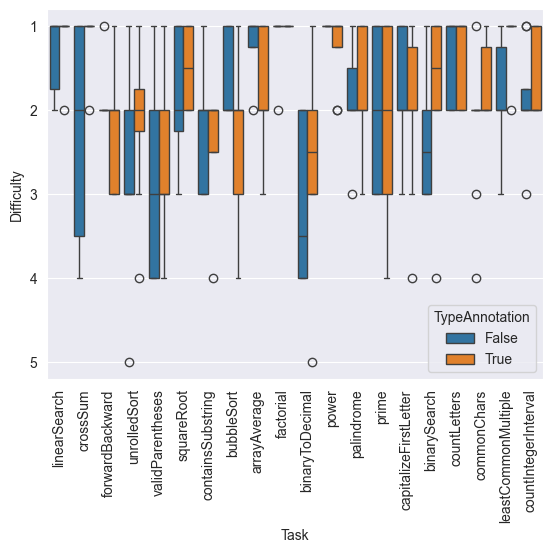

In [64]:
sns.boxplot(df_results_overall.query('Meaningful == True'), x='Task', y="Difficulty", hue="TypeAnnotation")
plt.xticks(rotation=90)
plt.yticks(np.arange(1, 6, 1))
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/difficultyrq23_Meaningful.pdf', bbox_inches='tight')
plt.show()

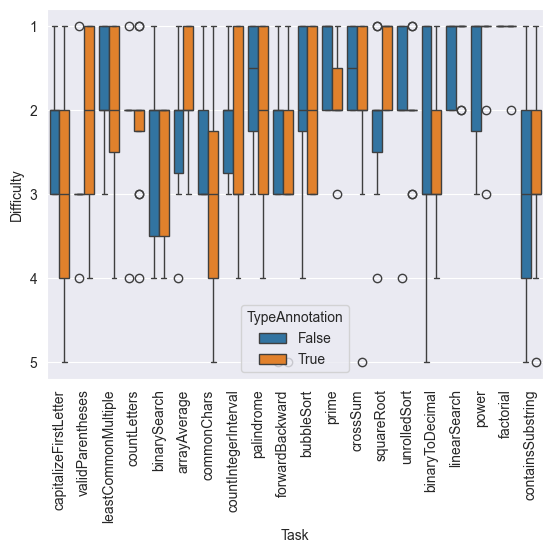

In [65]:
sns.boxplot(df_results_overall.query('Meaningful == False'), x='Task', y="Difficulty", hue="TypeAnnotation")
plt.xticks(rotation=90)
plt.yticks(np.arange(1, 6, 1))
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/difficultyrq23_Obfuscated.pdf', bbox_inches='tight')
plt.show()

### Measures for RQ 2.1

This shall include all information for the bahavioral measures as seen above

In [66]:
table_data: dict[str, list[str]|str] = {
    'Time': ['mean', 'std'],
    # 'CorrectAnswer': ['sum', 'count'],
}

table: DataFrame = df_results_overall.groupby(['Task', 'TypeAnnotation', 'Meaningful']).agg(table_data)

# TA_L_mean = table.query("TypeAnnotation == True and Meaningful == False")["Time"]["mean"]
# NoTA_L_mean = table.query("TypeAnnotation == False and Meaningful == False")["Time"]["mean"]
# TA_M_mean = table.query('TypeAnnotation == True and Meaningful == True')['Time']['mean']
# NoTA_M_mean = table.query('TypeAnnotation == False and Meaningful == True')['Time']['mean']

TA_L = df_results_overall.query("TypeAnnotation == True and Meaningful == False")["Time"]
NoTA_L = df_results_overall.query("TypeAnnotation == False and Meaningful == False")["Time"]
TA_M = df_results_overall.query("TypeAnnotation == True and Meaningful == True")["Time"]
NoTA_M = df_results_overall.query("TypeAnnotation == False and Meaningful == True")["Time"]

print(f'NORMALITY:\n{pg.normality(df_results_overall, dv="Time", group="TypeAnnotation")}')
print(f'NORMALITY:\n{pg.normality(df_results_overall, dv="Time", group="Meaningful")}')


print(f'Levene:\n{stats.levene(TA_L, NoTA_M, TA_M, NoTA_L)}')

print(f'{df_results_overall.query("Time == 0")}')

# print(f'Obfuscated: Wilcoxon NoTA -> TA:\n{stats.wilcoxon(NoTA_L_mean, TA_L_mean)}')
# print(f'Obfuscated: MannWhitneyU NoTA -> Meaningful NoTA:\n{stats.mannwhitneyu(NoTA_L_mean, NoTA_M_mean)}')
# print(f'Obfuscated: MannWhitneyU NoTA -> Meaningful TA:\n{stats.mannwhitneyu(NoTA_L_mean, TA_M_mean)}')
# print(f'Obfuscated: MannWhitneyU TA -> Meaningful TA:\n{stats.mannwhitneyu(TA_L_mean, TA_M_mean)}')
# print(f'Meaningful: MannWhitneyU NoTA -> Obfuscated TA:\n{stats.mannwhitneyu(NoTA_M_mean, TA_L_mean)}')
# print(f'Meaningful: Wilcoxon NoTA -> TA:\n{stats.wilcoxon(NoTA_M_mean, TA_M_mean)}')
print(pg.sphericity(df_results_overall, dv='Time', within=['Meaningful'], subject='ID'))
print(pg.sphericity(df_results_overall, dv='Time', within=['TypeAnnotation'], subject='ID'))



print(pg.sphericity(df_results_overall, dv='CorrectAnswer', within=['Meaningful'], subject='ID'))
print(pg.sphericity(df_results_overall, dv='CorrectAnswer', within=['TypeAnnotation'], subject='ID'))
# print(pg.sphericity(df_results_overall, dv='Time', within=['TypeAnnotation', 'Meaningful'], subject='ID',))
# (df_results_overall[['Time', 'TypeAnnotation', 'Meaningful']].corr())#.sum(1).sort_values(ascending=False)
# print(stats.bartlett())



# piv = df_results_overall.pivot(index='ID', columns=['Meaningful', 'TypeAnnotation'], values='Time')
# piv.head()
# print(pg.sphericity(piv))


NORMALITY:
                       W          pval  normal
TypeAnnotation                                
True            0.954598  5.861450e-09   False
False           0.950607  1.265397e-08   False
NORMALITY:
                   W          pval  normal
Meaningful                                
True        0.953043  1.368225e-08   False
False       0.954370  9.590011e-09   False
Levene:
LeveneResult(statistic=np.float64(1.2275915793258891), pvalue=np.float64(0.2987340288407251))
Empty DataFrame
Columns: [ID, Number, Task, Answer_Out, Time, TimeOut, SubjectID, CorrectAnswer, Meaningful, TypeAnnotation, Participant, Expert, Snippet, NumberOfFixations, FixationsPerSecond, Linearity, HasError, HitsBlock, HitsLine, HitsType, VerticalNext, VerticalLater, Regression, HorizontalLater, LineRegression, SaccadeLength, StoryOrder_Naive_Score, StoryOrder_Dynamic_Score, StoryOrder_Dynamic_Repetitions, ExecOrder_Naive_Score, ExecOrder_Dynamic_Score, ExecOrder_Dynamic_Repetitions, Difficulty, Comment,

In [67]:
# use statsmodel to analyze the time with variables annotation and meaningful
model = smf.mixedlm('Time ~ TypeAnnotation * Meaningful', data=df_results_overall, groups=df_results_overall['Task']).fit()
print(model.summary())

                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           Time      
No. Observations:           658               Method:                       REML      
No. Groups:                 20                Scale:                        778.8644  
Min. group size:            27                Log-Likelihood:               -3142.7268
Max. group size:            35                Converged:                    Yes       
Mean group size:            32.9                                                      
--------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                  63.529    5.059 12.557 0.000  53.613 73.445
TypeAnnotation[T.True]                      6.236    3.116  2.002 0.

Check for contingency in CorrectAnswer

In [68]:
df_results_overall['CorrectAnswerNumeric'] = df_results_overall['CorrectAnswer'].apply(lambda x: 1 if x else 0)
model = smf.logit('CorrectAnswerNumeric ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall, groups=df_results_overall['Task']).fit()
print(model.summary())
print(model.wald_test_terms(scalar=True))

Optimization terminated successfully.
         Current function value: 0.383835
         Iterations 6
                            Logit Regression Results                            
Dep. Variable:     CorrectAnswerNumeric   No. Observations:                  658
Model:                            Logit   Df Residuals:                      654
Method:                             MLE   Df Model:                            3
Date:                  Tue, 30 Sep 2025   Pseudo R-squ.:                0.002569
Time:                          12:13:52   Log-Likelihood:                -252.56
converged:                         True   LL-Null:                       -253.21
Covariance Type:              nonrobust   LLR p-value:                    0.7289
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept         

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


In [69]:
model = smf.mixedlm('Time ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall, groups=df_results_overall['Task']).fit()
print(model.summary())
print(model.wald_test_terms(scalar=True))

                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             Time      
No. Observations:             658                 Method:                         REML      
No. Groups:                   20                  Scale:                          778.8644  
Min. group size:              27                  Log-Likelihood:                 -3142.7268
Max. group size:              35                  Converged:                      Yes       
Mean group size:              32.9                                                          
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                        63.529    5.059 12.557 0.000  53.613 73.445
C(Mea

#### RQ 2.2 Linearity

In [70]:
list_measure: list[str] = ['VerticalNext', 
                           'VerticalLater', 'Regression', 'HorizontalLater', 'LineRegression', 'StoryOrder_Naive_Score','StoryOrder_Dynamic_Score','StoryOrder_Dynamic_Repetitions', 'SaccadeLength', 'Linearity'
                           ]

df_results_overall = df_results_overall[df_results_overall['LineRegression'].notna()].reset_index()
df_results_overall = df_results_overall[df_results_overall['SaccadeLength'].notna()].reset_index()

In [71]:
for measure in list_measure:
    print(f'\nMeasure: {measure}')
    if measure not in []:
        model = smf.mixedlm(f'{measure} ~ C(TypeAnnotation) * C(Meaningful)', data=df_results_overall, groups=df_results_overall['Task']).fit()
        print(model.summary())
    else:
        model = smf.mixedlm(f'{measure} ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall, groups=df_results_overall['Task']).fit()
    print(model.wald_test_terms(scalar=True))


Measure: VerticalNext
                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           VerticalNext
No. Observations:             554               Method:                       REML        
No. Groups:                   20                Scale:                        0.0020      
Min. group size:              24                Log-Likelihood:               901.9636    
Max. group size:              30                Converged:                    Yes         
Mean group size:              27.7                                                        
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.131    0.005 26.367 0.000  0.122  0.141
C(T

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: C

                           Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           SaccadeLength
No. Observations:             554               Method:                       REML         
No. Groups:                   20                Scale:                        921.5230     
Min. group size:              24                Log-Likelihood:               -2667.4391   
Max. group size:              30                Converged:                    Yes          
Mean group size:              27.7                                                         
-------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                       37.197    2.647 14.051 0.000  32.008 42.385
C(TypeAnnotatio

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conve

#### RQ 2.3

Check for the difficulty

In [72]:
# df_results_overall['DifficultyNumeric'] = df_results_overall['Difficulty'].apply(lambda x: 1 if x == 'Very Difficult' else  0)
df_results_overall['DifficultyNumeric'] = df_results_overall['Difficulty'].dropna().astype(float)
df_results_overall['DifficultyNumeric'] = df_results_overall['DifficultyNumeric'].apply(lambda x: x / 5)
model = smf.logit('DifficultyNumeric ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall, groups=df_results_overall['Task']).fit()
print(model.summary())
print(model.wald_test_terms(scalar=True))

Optimization terminated successfully.
         Current function value: 0.652267
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      DifficultyNumeric   No. Observations:                  518
Model:                          Logit   Df Residuals:                      514
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                 -0.1115
Time:                        12:13:53   Log-Likelihood:                -337.87
converged:                       True   LL-Null:                       -303.99
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                         

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


TAComprehension influenced by Meaningful?

63.3014440433213
34.16184908361242
1, 554


<Axes: ylabel='Time'>

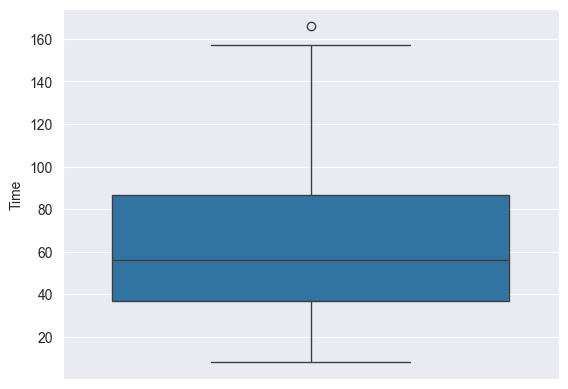

In [73]:
Q3 = df_results_overall.Time.quantile(0.75)
Q1 = df_results_overall.Time.quantile(0.25)
print(df_results_overall.Time.mean())
print(df_results_overall.Time.std())


IQR = Q3 - Q1
threshold = 1.5

outliers = df_results_overall[(df_results_overall['Time'] < Q1 - threshold * IQR) | (df_results_overall['Time'] > Q3 + threshold * IQR)]
print(f'{len(outliers.Time)}, {len(df_results_overall.Time)}')
sns.boxplot(df_results_overall, y='Time')

#### Miscellaneous

How did the people find themselves in comparison to others?

  Classmates    percent
0          3  45.714286
1          4  34.285714
2          2  14.285714
3          5   5.714286
4          1   0.000000


<Figure size 1000x600 with 0 Axes>

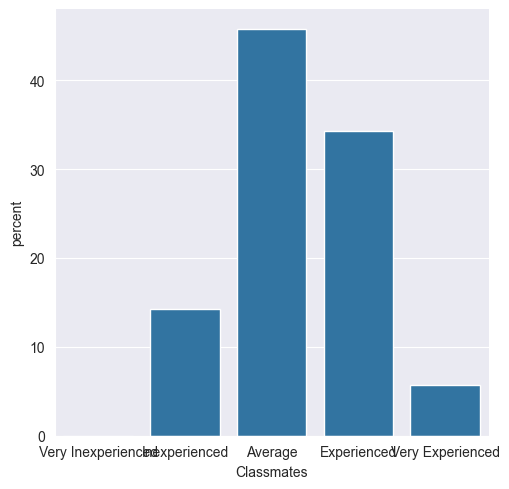

In [74]:
df1 = df_personal_information.Classmates.value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

print(df1)

plt.figure(figsize=(10, 6))
sns.catplot(x='Classmates', 
            # hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
)

plt.xticks(np.arange(5), ['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'])
# plt.title('Difficulty grouped by Meaningful')
# plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight')
plt.show()

For OverallExperience

  OverallExperience    percent
0                 3  45.714286
1                 4  42.857143
2                 2  11.428571
3                 1   0.000000
4                 5   0.000000


<Figure size 1000x600 with 0 Axes>

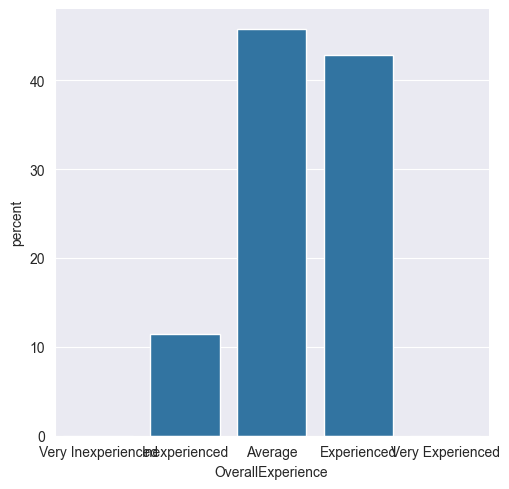

In [75]:
df1 = df_personal_information.OverallExperience.value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

print(df1)

plt.figure(figsize=(10, 6))
sns.catplot(x='OverallExperience', 
            # hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
)

plt.xticks(np.arange(5), ['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'])
# plt.title('Difficulty grouped by Meaningful')
# plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight')
plt.show()

Years Programming

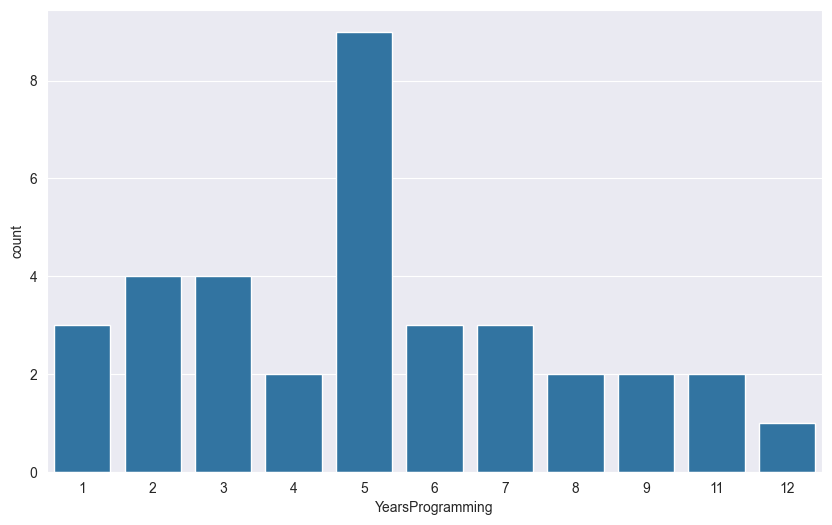

In [76]:
# df1 = df_personal_information.OverallExperience.value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('percent').reset_index()

# print(df1)

plt.figure(figsize=(10, 6))
sns.countplot(x='YearsProgramming',
            # hue='TypeAnnotation', 
            data=df_personal_information, 
            # kind='bar',
)

# plt.xticks(np.arange(5), ['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'])
# plt.title('Difficulty grouped by Meaningful')
# plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight')
plt.show()

In [77]:
df_results_overall.Linearity.describe()

count    554.0
mean       5.0
std        0.0
min        5.0
25%        5.0
50%        5.0
75%        5.0
max        5.0
Name: Linearity, dtype: float64

All Snippets with their mean and SD with correctness

In [78]:
df = df_results_overall.groupby(['Task', 'TypeAnnotation']).agg({'Time': ['mean', 'std']})
df

Time           
                                            mean        std
Task                  TypeAnnotation                       
arrayAverage          False            59.181818  29.314905
                      True             53.888889  20.576654
binarySearch          False            78.428571  35.094848
                      True             97.083333  33.987854
binaryToDecimal       False            78.000000  22.572107
                      True             68.533333  29.882787
bubbleSort            False            82.083333  41.613936
                      True             78.312500  29.443095
capitalizeFirstLetter False            79.700000  34.884094
                      True             97.444444  30.160789
commonChars           False            44.642857  20.507436
                      True             57.857143  30.394476
containsSubstring     False            78.000000  30.608641
                      True             95.214286  34.099805
countIntegerInterval  False            76.714286  28.165523
                      True             81.625000  18.249658
countLetters          False            37.000000  20.960280
                      True             66.250000  36.157987
crossSum              False            27.916667   9.481641
                      True             42.352941  16.120411
factorial             False            18.666667  10.184956
                      True             31.333333  18.721645
forwardBackward       False            74.307692  30.225223
                      True             73.875000  24.229115
leastCommonMultiple   False            67.857143  23.922494
                      True             41.923077  18.940528
linearSearch          False            31.083333  13.124982
                      True             30.058824  12.676112
palindrome            False            60.111111  25.813971
                      True             66.470588  34.447637
power                 False            34.500000  12.369317
                      True             42.812500  15.681066
prime                 False            52.200000  19.098242
                      True             58.538462  28.409551
squareRoot            False            74.687500  24.151518
                      True             60.636364  28.278164
unrolledSort          False            52.769231  27.227908
                      True             74.846154  38.733806
validParentheses      False           105.615385  27.066395
                      True            102.133333  43.286201

## Currently unnecessary and unused data

   TypeAnnotation  Meaningful  CorrectAnswer    percent
0           False       False           True  87.878788
1           False       False          False  12.121212
2           False        True           True  87.301587
3           False        True          False  12.698413
4            True       False           True  83.950617
5            True       False          False  16.049383
6            True        True           True  85.820896
7            True        True          False  14.179104


<Figure size 1000x600 with 0 Axes>

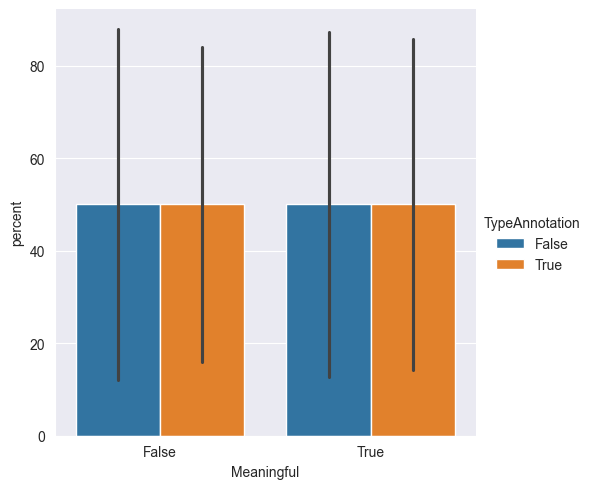

In [79]:
df1 = df_results_overall.groupby(['TypeAnnotation', 'Meaningful'])['CorrectAnswer'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
print(df1)

plt.figure(figsize=(10, 6))
sns.catplot(x='Meaningful', 
            hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
)
plt.show()

#### Table for Type Annotations and Meaningful

In [80]:
table_data: dict[str, list[str]|str] = {
    'Time': ['mean', 'std'],
    'CorrectAnswer': ['sum', 'count'],
}

df_results_overall.groupby(['Task', 'Meaningful', 'TypeAnnotation']).agg(table_data)

Time             \
                                                  mean        std   
Task             Meaningful TypeAnnotation                          
arrayAverage     False      False            70.714286  31.388503   
                            True             61.444444  18.000772   
                 True       False            39.000000   6.377042   
                            True             46.333333  21.148286   
binarySearch     False      False            91.285714  45.231679   
...                                                ...        ...   
unrolledSort     True       True             80.714286  42.046460   
validParentheses False      False            96.166667  15.778678   
                            True             86.125000  46.850637   
                 True       False           113.714286  33.043982   
                            True            120.428571  32.847411   

                                           CorrectAnswer        
                                                     sum count  
Task             Meaningful TypeAnnotation                      
arrayAverage     False      False                      6     7  
                            True                       9     9  
                 True       False                      4     4  
                            True                       9     9  
binarySearch     False      False                      6     7  
...                                                  ...   ...  
unrolledSort     True       True                       4     7  
validParentheses False      False                      5     6  
                            True                       8     8  
                 True       False                      7     7  
                            True                       4     7  

[80 rows x 4 columns]

### Task Plots

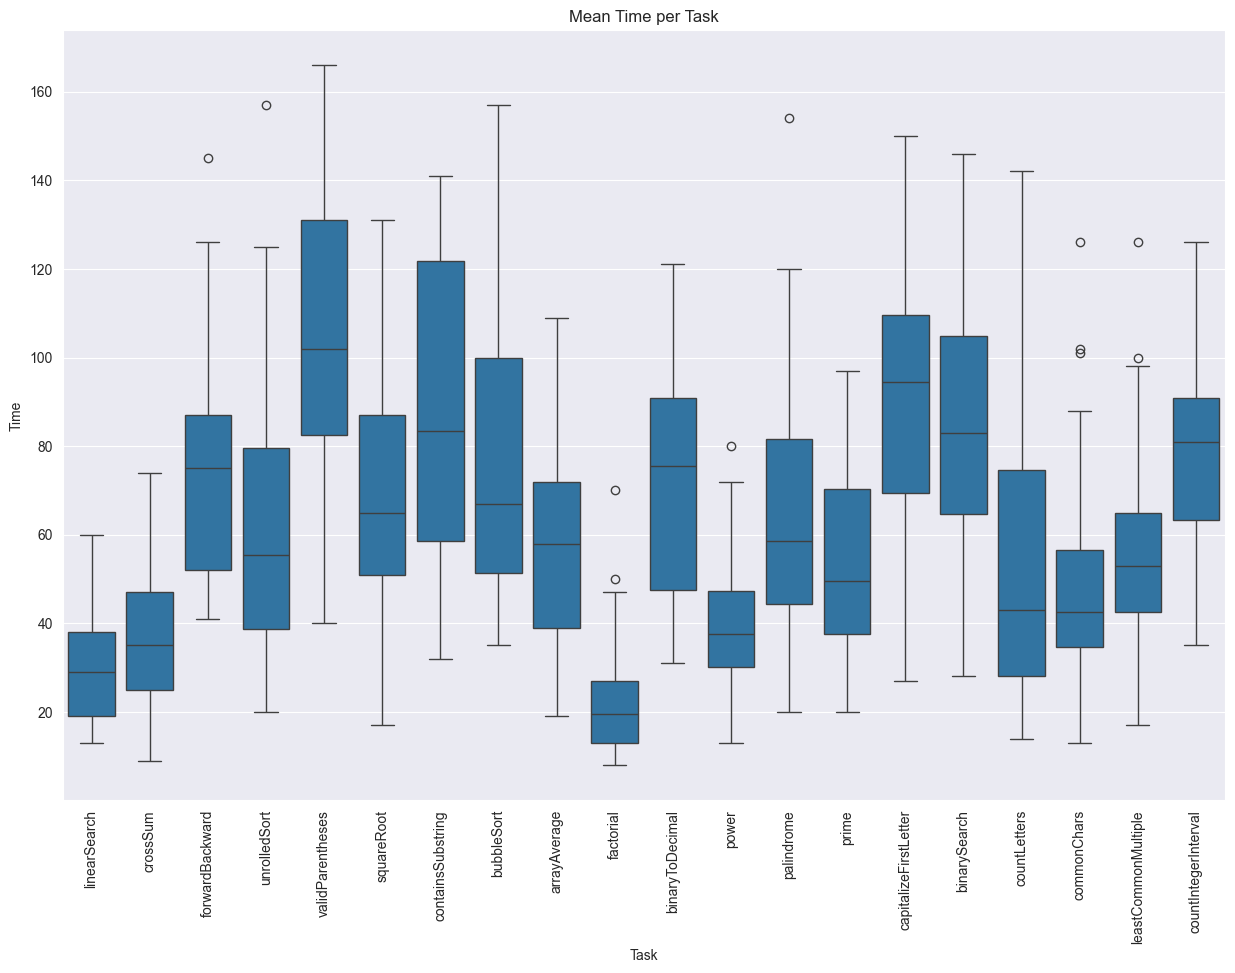

In [81]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot for the mean length of each task
plt.figure(figsize=(15, 10))
sns.boxplot(x='Task', y='Time', data=df_results_overall)
plt.title('Mean Time per Task')
plt.xticks(rotation=90)
plt.show()

The mean time per task by Type Annotation

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/637111080.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True')['Time'] for task in all_tasks], labels=all_tasks,)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/637111080.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False')['Time'] for task in all_tasks], labels=all_tasks,)


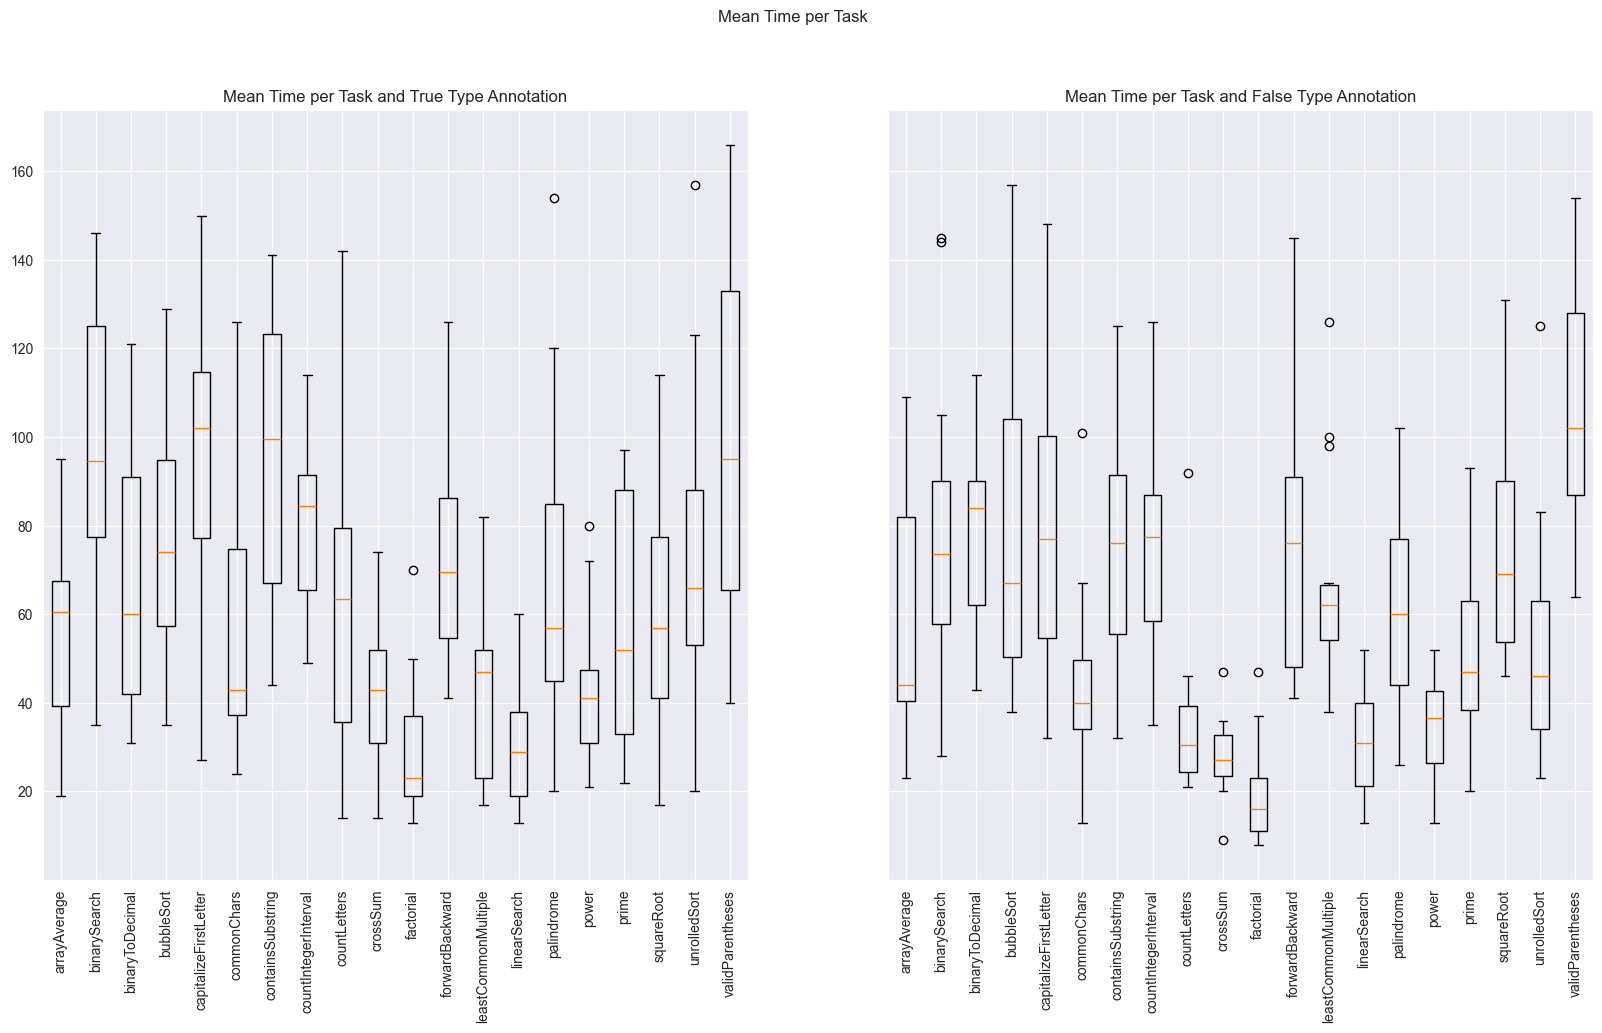

In [82]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot that shows the mean time for each task
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
fig.suptitle('Mean Time per Task')

axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True')['Time'] for task in all_tasks], labels=all_tasks,)
axs[0].set_xticklabels(all_tasks, rotation=90)
axs[0].set_title('Mean Time per Task and True Type Annotation')


axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False')['Time'] for task in all_tasks], labels=all_tasks,)
axs[1].set_xticklabels(all_tasks, rotation=90)
axs[1].set_title('Mean Time per Task and False Type Annotation')

plt.show()

The mean time per task by Identifier Name

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1276528124.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks,)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1276528124.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == False')['Time'] for task in all_tasks], labels=all_tasks,)


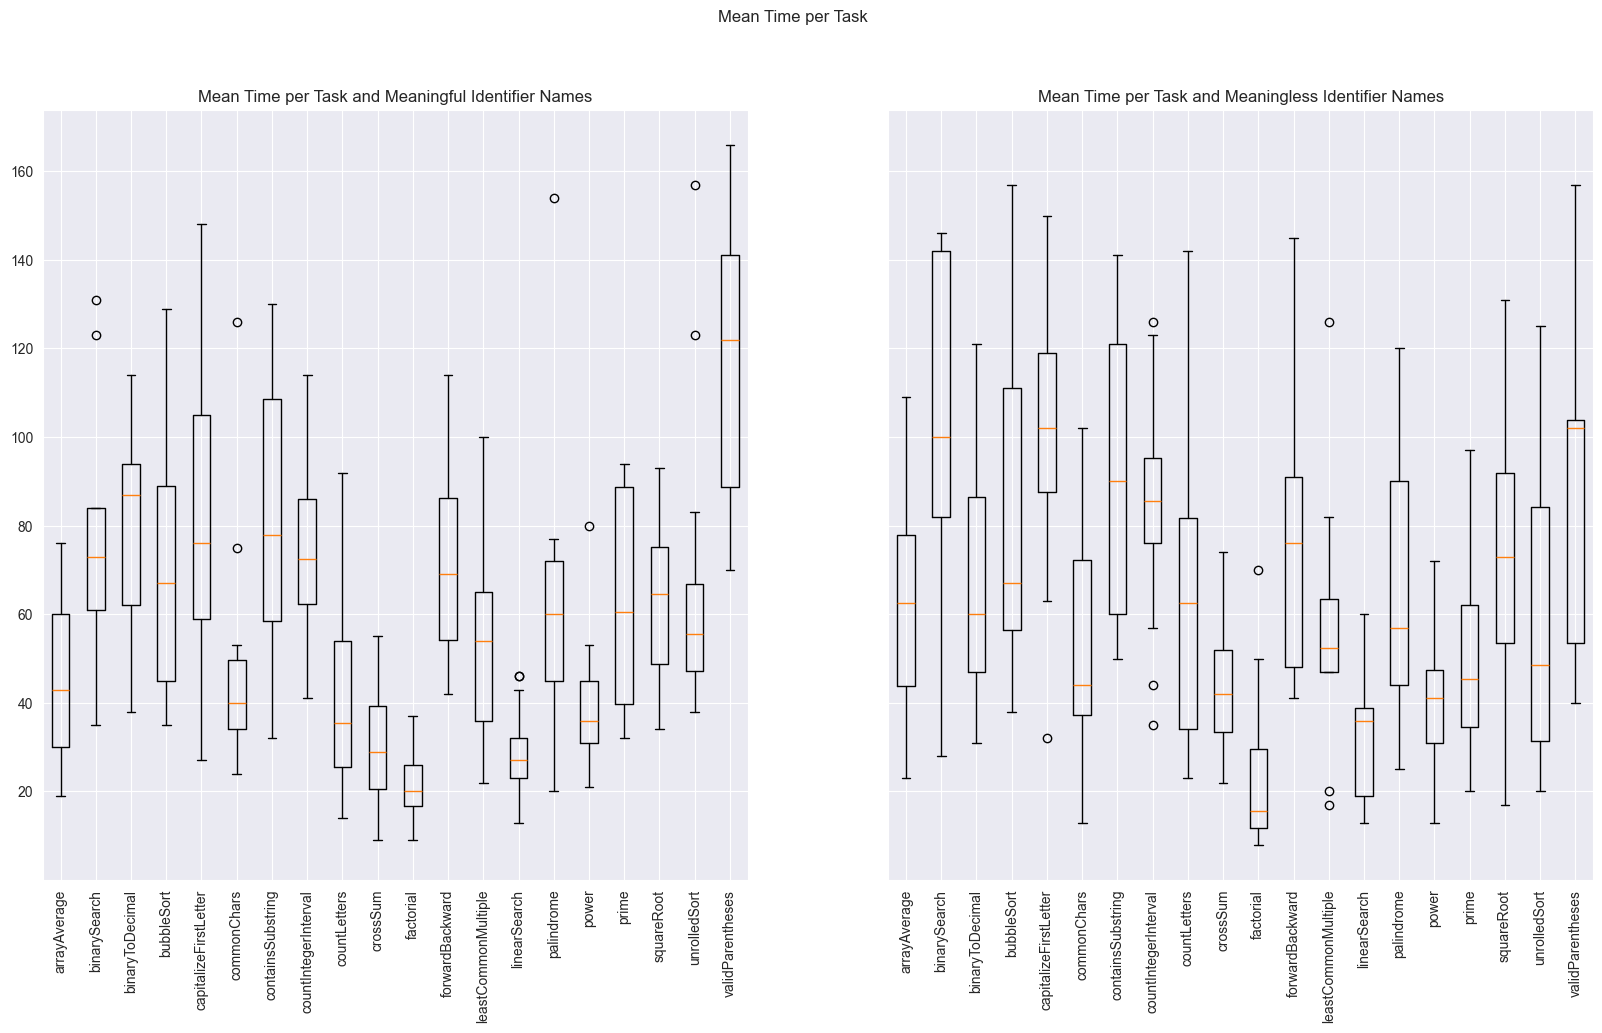

In [83]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot that shows the mean time for each task
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
fig.suptitle('Mean Time per Task')

axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks,)
axs[0].set_xticklabels(all_tasks, rotation=90)
axs[0].set_title('Mean Time per Task and Meaningful Identifier Names')


axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == False')['Time'] for task in all_tasks], labels=all_tasks,)
axs[1].set_xticklabels(all_tasks, rotation=90)
axs[1].set_title('Mean Time per Task and Meaningless Identifier Names')

plt.show()

The mean time per task and for the combinations of Type Annoations and Identifier Names

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/123170642.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks, notch=False)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/123170642.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks,)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/123170642.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot()

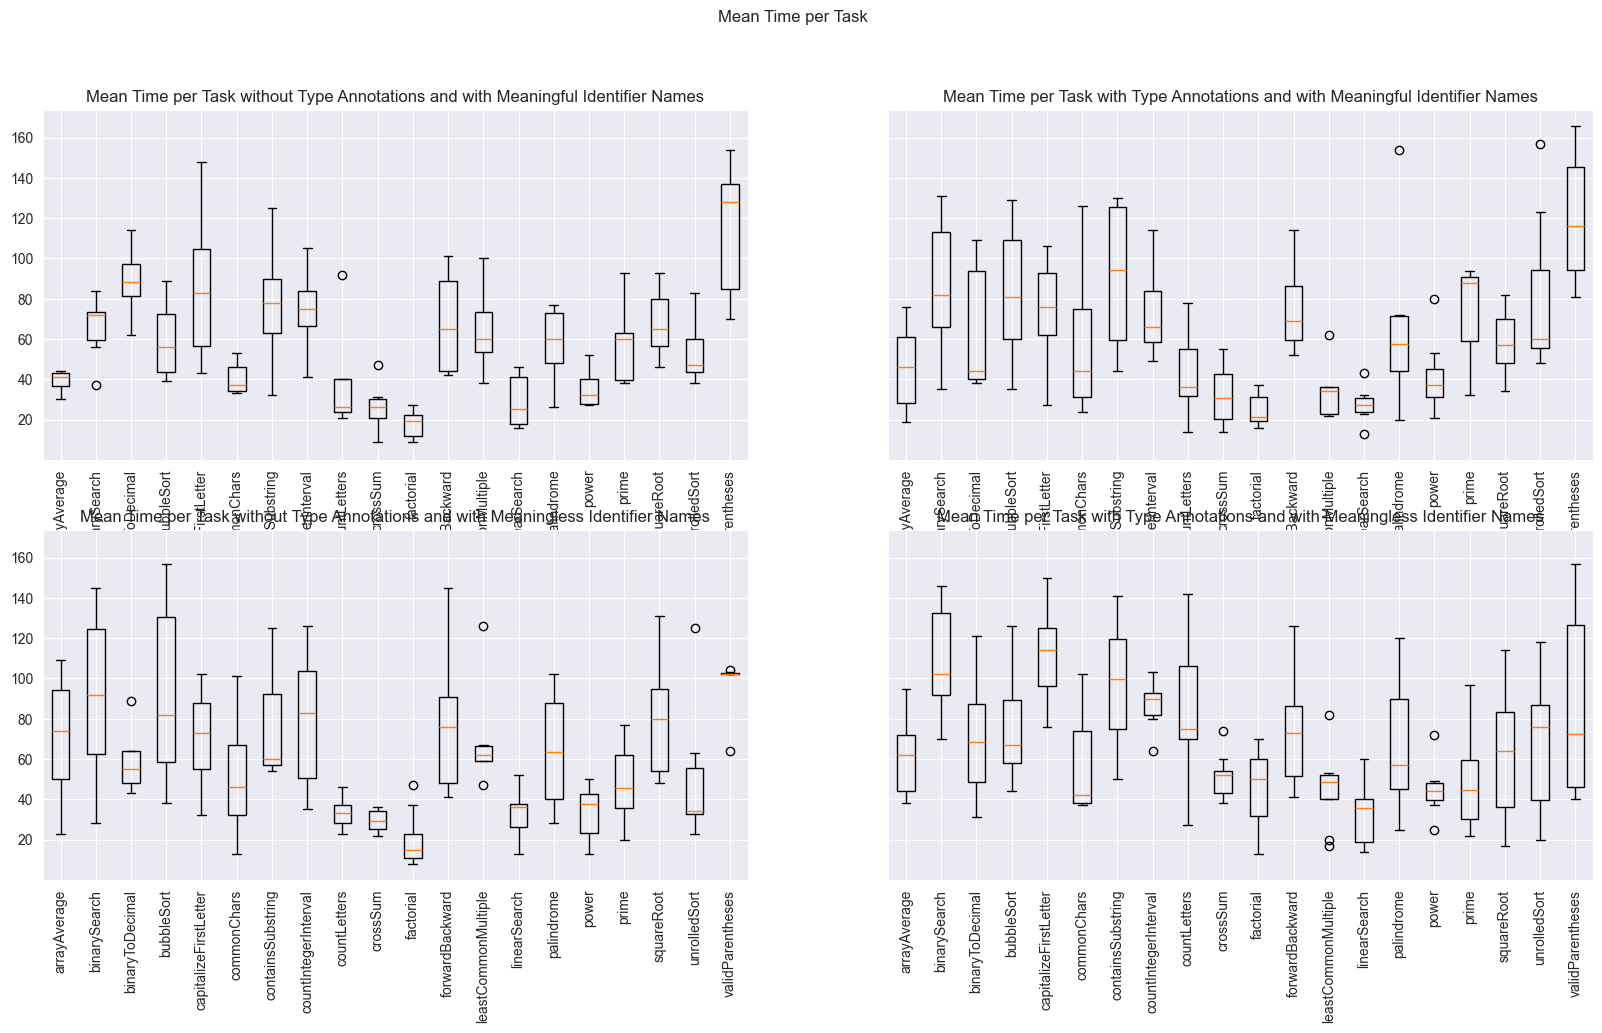

In [84]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot that shows the mean time for each task
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharey=True)
fig.suptitle('Mean Time per Task')

axs[0, 0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks, notch=False)
axs[0, 0].set_xticklabels(all_tasks, rotation=90)
axs[0, 0].set_title('Mean Time per Task without Type Annotations and with Meaningful Identifier Names')

axs[0, 1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks,)
axs[0, 1].set_xticklabels(all_tasks, rotation=90)
axs[0, 1].set_title('Mean Time per Task with Type Annotations and with Meaningful Identifier Names')

axs[1, 0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False and `Meaningful` == False')['Time'] for task in all_tasks], labels=all_tasks,)
axs[1, 0].set_xticklabels(all_tasks, rotation=90)
axs[1, 0].set_title('Mean Time per Task without Type Annotations and with Meaningless Identifier Names')

axs[1, 1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True and `Meaningful` == False')['Time'] for task in all_tasks], labels=all_tasks,)
axs[1, 1].set_xticklabels(all_tasks, rotation=90)
axs[1, 1].set_title('Mean Time per Task with Type Annotations and with Meaningless Identifier Names')

plt.show()

A plot to describe how long each task took overall and how this is distributed among the participants.

A plot that shows how long each participant took grouped by task.

Combine the Type Annotation plots in the top row into one bigger plot with comparison.

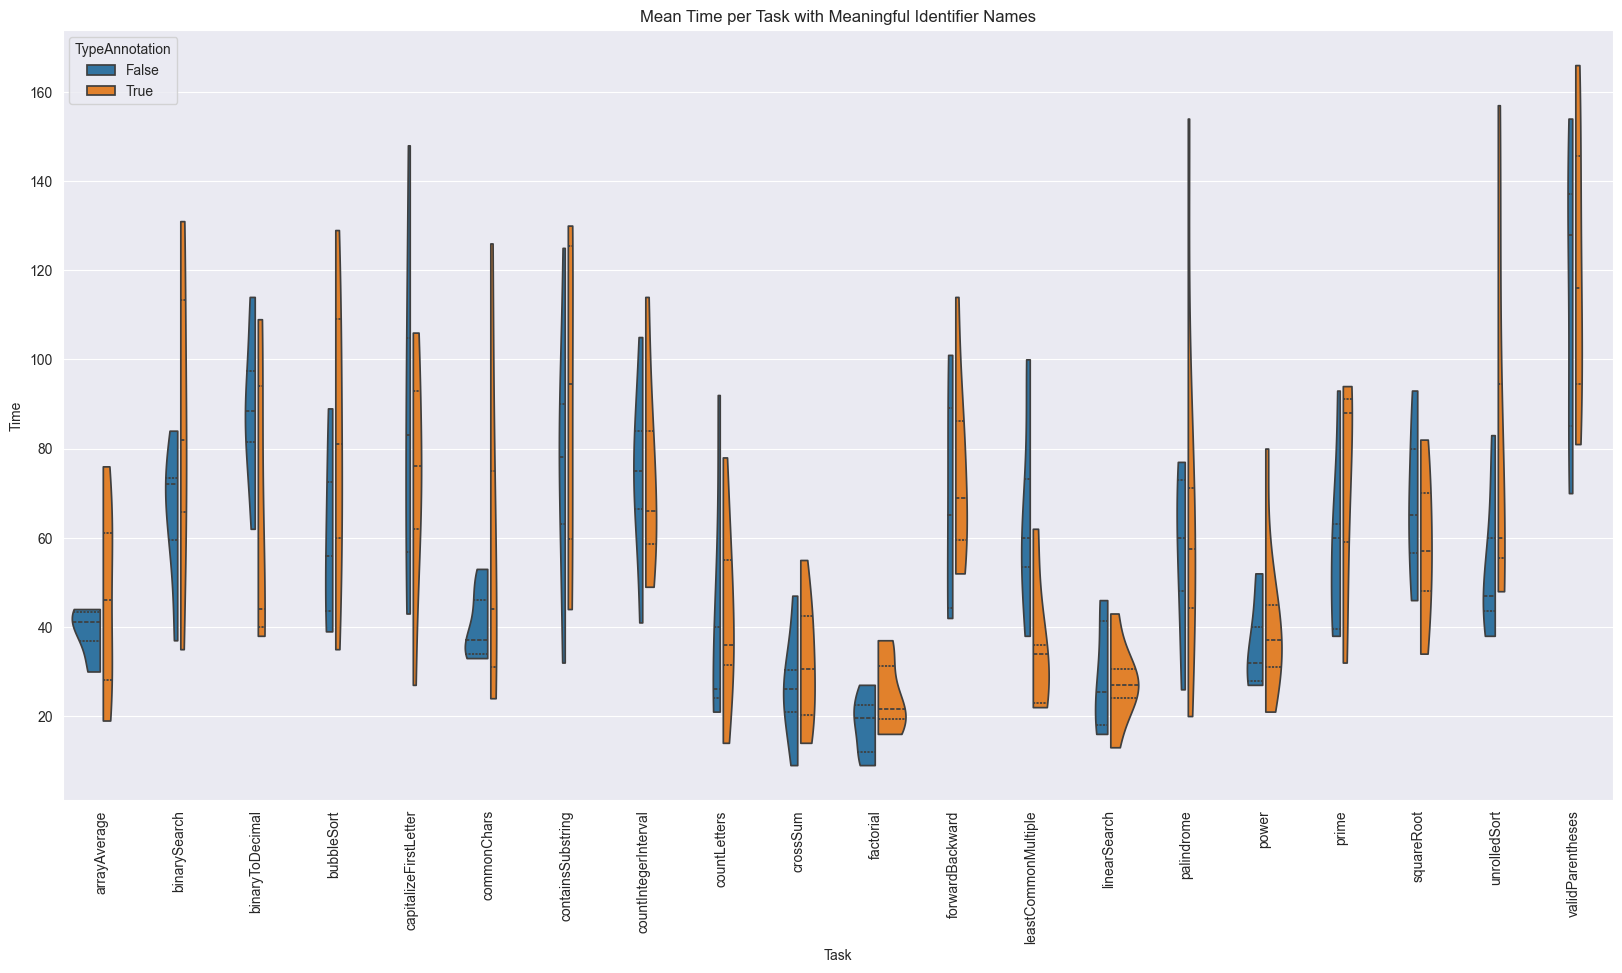

In [85]:
plt.figure(figsize=(20, 10))
sns.violinplot(df_results_overall.query(f'`Meaningful` == True'), x='Task', y='Time', hue='TypeAnnotation', split=True, gap=.1, inner="quart", cut=0, order=all_tasks)

plt.xticks(all_tasks, rotation=90)
plt.title('Mean Time per Task with Meaningful Identifier Names')
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/timePerTaskrq21_meaningful.pdf', bbox_inches='tight')

plt.show()

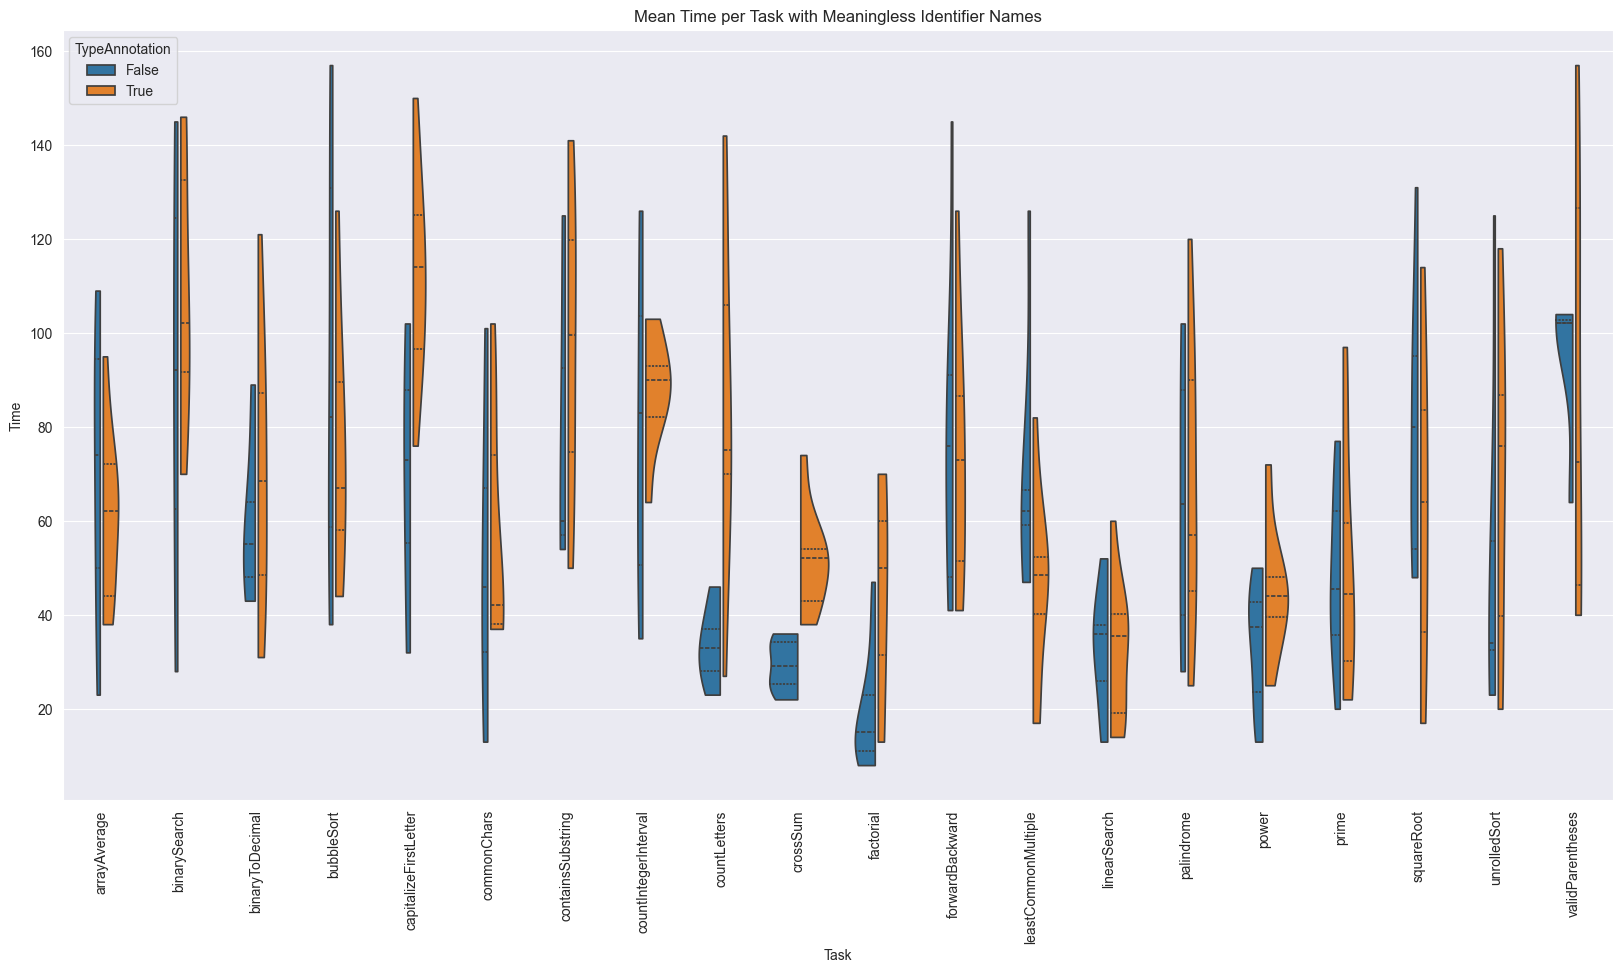

In [86]:
plt.figure(figsize=(20, 10))
sns.violinplot(df_results_overall.query(f'`Meaningful` == False'), x='Task', y='Time', hue='TypeAnnotation', split=True, gap=.1, inner="quart", cut=0, order=all_tasks)

plt.xticks(all_tasks, rotation=90)
plt.title('Mean Time per Task with Meaningless Identifier Names') 

# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/timePerTaskrq21_obfuscated.pdf', bbox_inches='tight')
plt.show()

What were the Means and the Standard Deviation for meaningful and type annotation?

In [87]:
print(df_results_overall.groupby(['Meaningful', 'TypeAnnotation', ]).agg({'Time': ['mean', 'std']}))
print(df_results_overall.groupby(['Meaningful']).agg({'Time': ['mean', 'std']}))


                                Time           
                                mean        std
Meaningful TypeAnnotation                      
False      False           60.098485  35.760838
           True            70.234568  33.768585
True       False           59.277778  30.899227
           True            61.858209  35.055735
                 Time           
                 mean        std
Meaningful                      
False       65.683673  34.983740
True        60.607692  33.068432


As for the correctness:

In [88]:
print(df_results_overall.groupby(['Meaningful', 'TypeAnnotation', ]).agg({'CorrectAnswer': ['sum', 'count']}))
print(df_results_overall.groupby(['Meaningful']).agg({'CorrectAnswer': ['sum', 'count']}))
print(df_results_overall.groupby(['TypeAnnotation']).agg({'CorrectAnswer': ['sum', 'count']}))

                          CorrectAnswer      
                                    sum count
Meaningful TypeAnnotation                    
False      False                    116   132
           True                     136   162
True       False                    110   126
           True                     115   134
           CorrectAnswer      
                     sum count
Meaningful                    
False                252   294
True                 225   260
               CorrectAnswer      
                         sum count
TypeAnnotation                    
False                    226   258
True                     251   296


Correlation heatmap and p-values for the time

P-Values:
        M-TA     L-N    L-TA    M-N
L-N   0.0001     0.0  0.0025    0.0
L-TA  0.0006  0.0025     0.0  0.002
M-N      0.0     0.0   0.002    0.0
M-TA     0.0  0.0001  0.0006    0.0


/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/307995445.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)


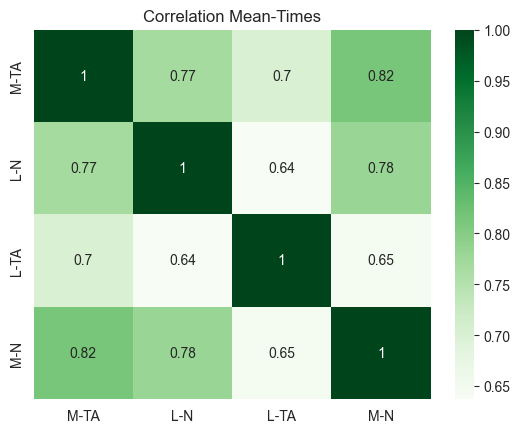

In [89]:
df_correlation_meantimes_snippets: DataFrame = DataFrame()

df_correlation_meantimes_snippets['M-TA'] = df_results_overall.query('TypeAnnotation == True and Meaningful == True').groupby('Task').agg({'Time': 'mean'})['Time']
df_correlation_meantimes_snippets['L-N'] = df_results_overall.query('TypeAnnotation == False and Meaningful == False').groupby('Task').agg({'Time': 'mean'})['Time']
df_correlation_meantimes_snippets['L-TA'] = df_results_overall.query('TypeAnnotation == True and Meaningful == False').groupby('Task').agg({'Time': 'mean'})['Time']
df_correlation_meantimes_snippets['M-N'] = df_results_overall.query('TypeAnnotation == False and Meaningful == True').groupby('Task').agg({'Time': 'mean'})['Time']

matrix = df_correlation_meantimes_snippets.corr()
print(f'P-Values:\n{calculate_pvalues(df_correlation_meantimes_snippets)}')

sns.heatmap(matrix, cmap="Greens", annot=True)
plt.title(f'Correlation Mean-Times')
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/correlation_meantimesrq21.pdf', bbox_inches='tight')
plt.show()

Correlation and p-values for the correctness

P-Values:
        M-TA     L-N    L-TA     M-N
L-N   0.2786     0.0  0.0885  0.6516
L-TA    0.46  0.0885     0.0  0.3644
M-N   0.1585  0.6516  0.3644     0.0
M-TA     0.0  0.2786    0.46  0.1585


/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/307995445.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)


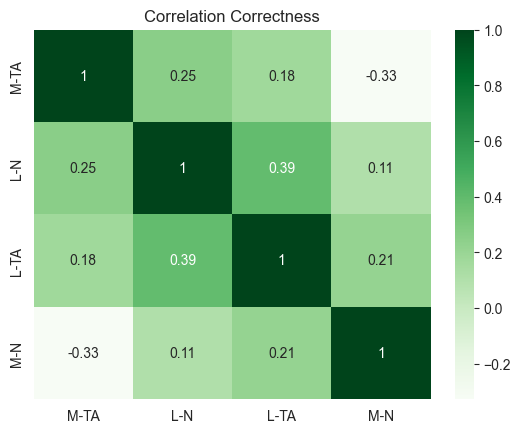

In [90]:
df_correlation_correctness_snippets: DataFrame = DataFrame()

df_correlation_correctness_snippets['M-TA'] = df_results_overall.query('TypeAnnotation == True and Meaningful == True').groupby('Task').agg({'CorrectAnswer': 'sum'})['CorrectAnswer'] / df_results_overall.query('TypeAnnotation == True and Meaningful == True').groupby('Task').agg({'CorrectAnswer': 'count'})['CorrectAnswer']
df_correlation_correctness_snippets['L-N'] = df_results_overall.query('TypeAnnotation == False and Meaningful == False').groupby('Task').agg({'CorrectAnswer': 'sum'})['CorrectAnswer'] / df_results_overall.query('TypeAnnotation == False and Meaningful == False').groupby('Task').agg({'CorrectAnswer': 'count'})['CorrectAnswer']
df_correlation_correctness_snippets['L-TA'] = df_results_overall.query('TypeAnnotation == True and Meaningful == False').groupby('Task').agg({'CorrectAnswer': 'sum'})['CorrectAnswer'] / df_results_overall.query('TypeAnnotation == True and Meaningful == False').groupby('Task').agg({'CorrectAnswer': 'count'})['CorrectAnswer']
df_correlation_correctness_snippets['M-N'] = df_results_overall.query('TypeAnnotation == False and Meaningful == True').groupby('Task').agg({'CorrectAnswer': 'sum'})['CorrectAnswer'] / df_results_overall.query('TypeAnnotation == False and Meaningful == True').groupby('Task').agg({'CorrectAnswer': 'count'})['CorrectAnswer']

matrix = df_correlation_correctness_snippets.corr()
print(f'P-Values:\n{calculate_pvalues(df_correlation_correctness_snippets)}')

sns.heatmap(matrix, cmap="Greens", annot=True)
plt.title(f'Correlation Correctness')
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/correlation_correctnessrq21.pdf', bbox_inches='tight')
plt.show()

Show the mean time with and without type annotations for each participant.

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/2084840597.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_L_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Time'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0+0.35, widths=0.6)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/2084840597.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_TA_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for participant in meaningful_participants], labels=meaningful_part

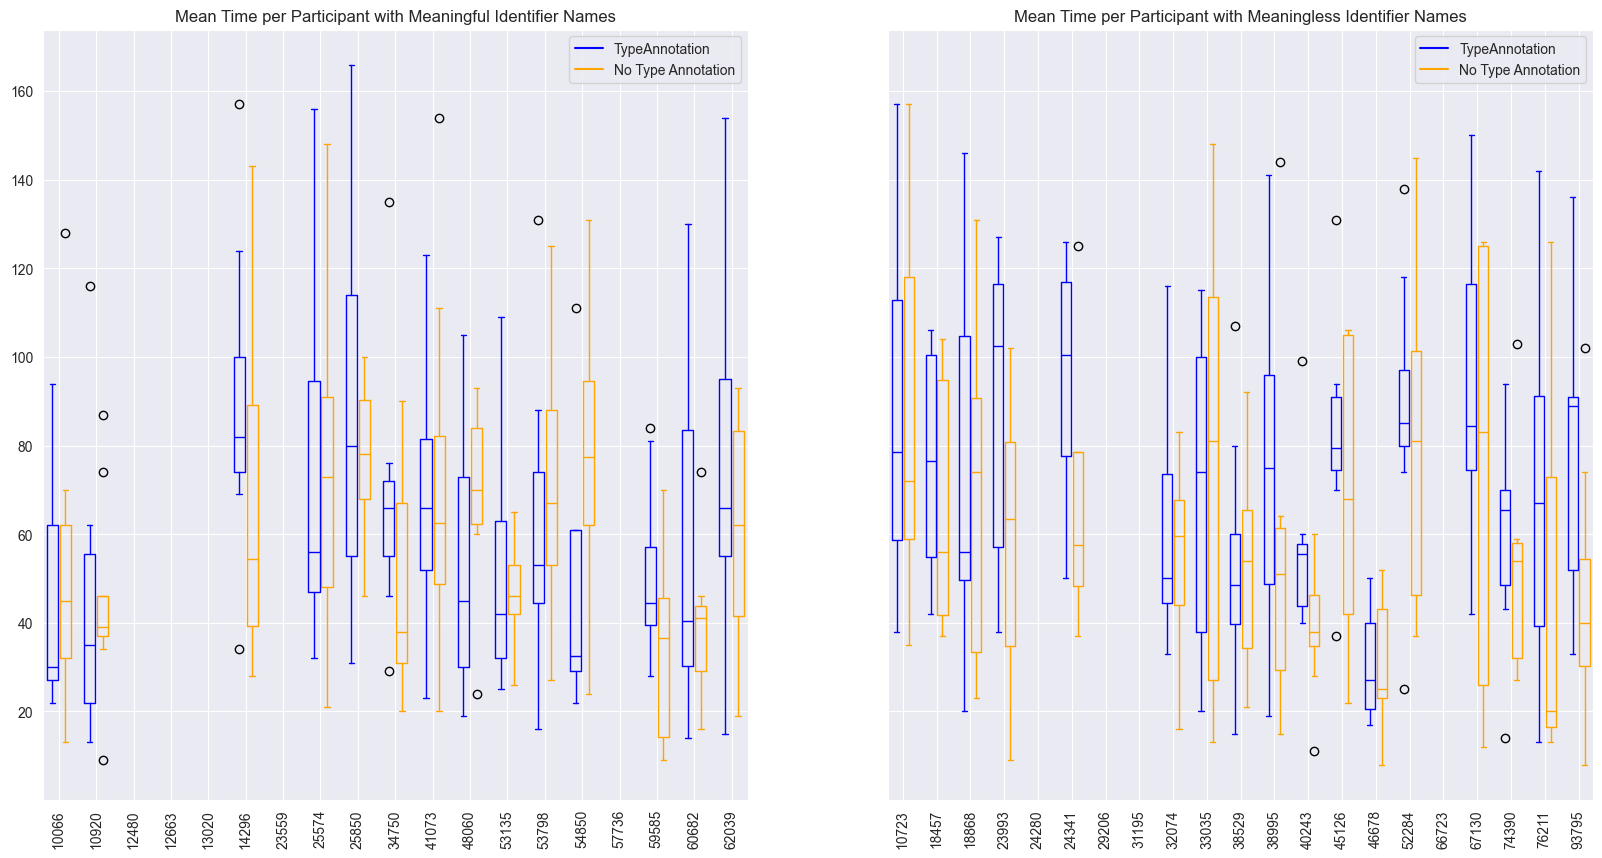

In [91]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), sharey=True)

# first plot
plot_L_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Time'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0+0.35, widths=0.6)
plot_TA_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0-0.35, widths=0.6)

# first plot settings
axs[0].set_title('Mean Time per Participant with Meaningful Identifier Names')
axs[0].set_xticks(np.arange(0, len(meaningful_participants) * 2, 2), meaningful_participants, rotation=90)
define_box_properties(plot_TA_M, 'blue', 'TypeAnnotation', axs[0])
define_box_properties(plot_L_M, 'orange', 'No Type Annotation', axs[0])

# second plot
plot_L_L = axs[1].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == False')['Time'] for participant in meaningless_participants], labels=meaningless_participants, positions=np.arange(len(meaningless_participants))*2.0+0.35, widths=0.6)
plot_TA_L = axs[1].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == False')['Time'] for participant in meaningless_participants], labels=meaningless_participants, positions=np.arange(len(meaningless_participants))*2.0-0.35, widths=0.6)

# second plot settings
axs[1].set_title('Mean Time per Participant with Meaningless Identifier Names')
axs[1].set_xticks(np.arange(0, len(meaningless_participants) * 2, 2), meaningless_participants, rotation=90)
define_box_properties(plot_TA_L, 'blue', 'TypeAnnotation', axs[1])
define_box_properties(plot_L_L, 'orange', 'No Type Annotation', axs[1])

plt.show()


How long people took overall.

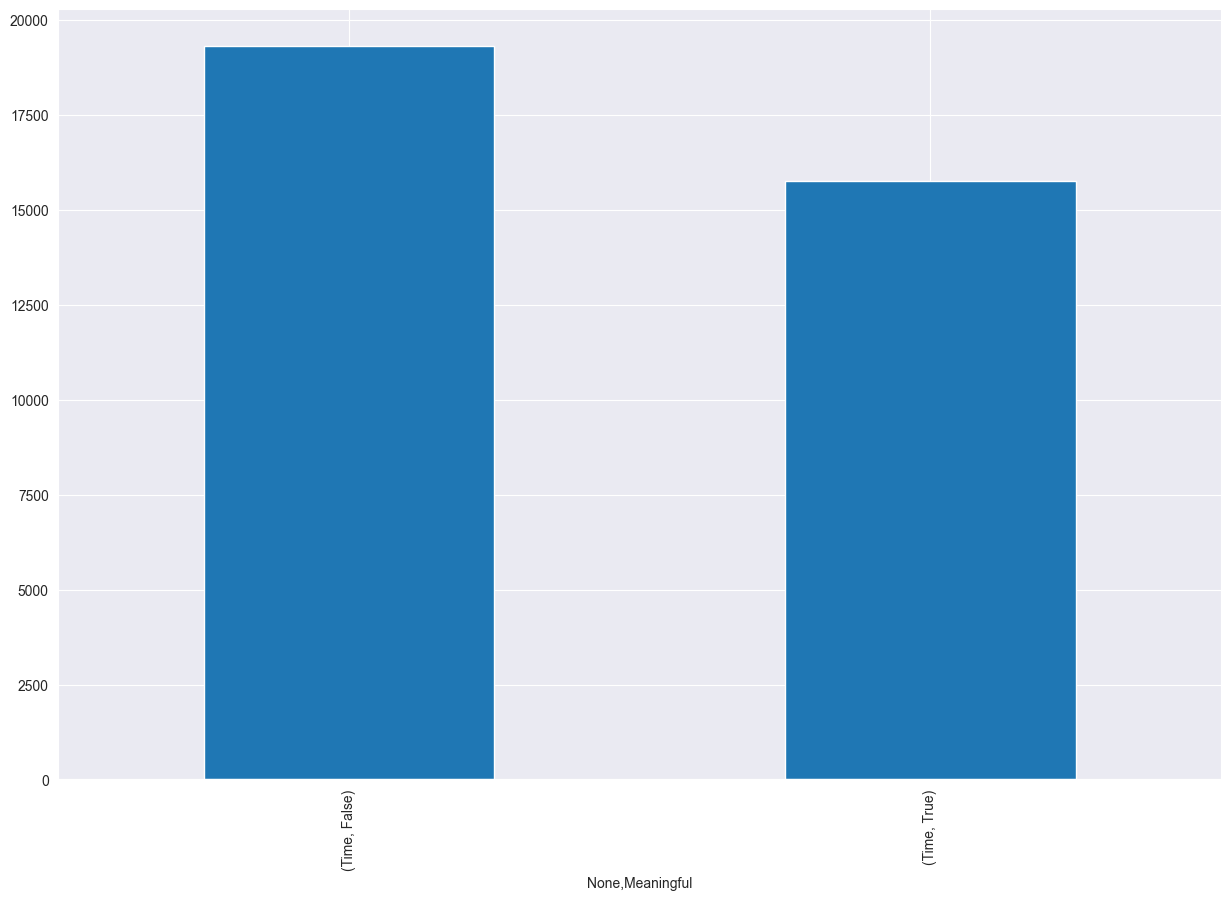

In [92]:
df_results_overall.groupby(['Meaningful',]).agg({'Time': 'sum'}).unstack().T.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.show()

Do `meaningful` snippets make participants faster on average?

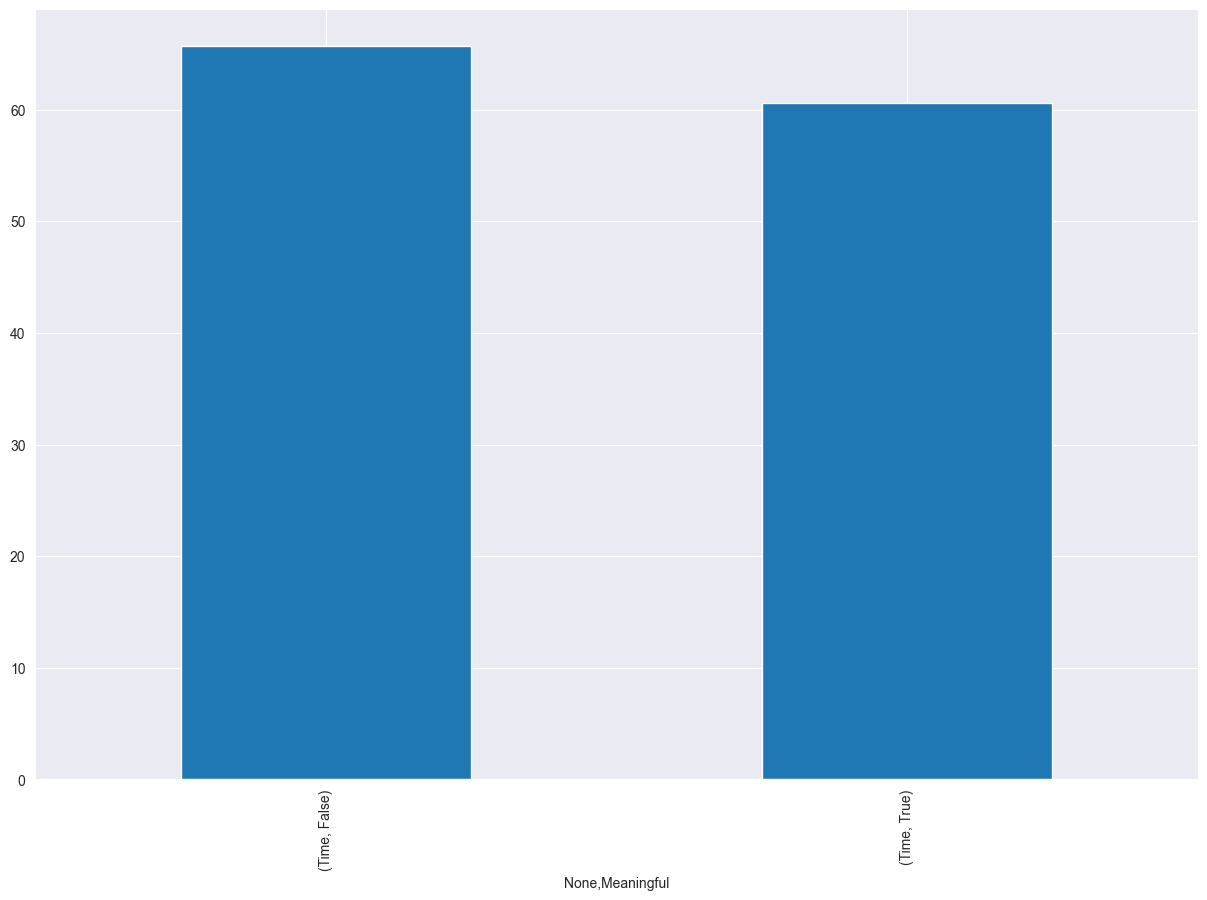

In [93]:
# compute if meaningful snippets were faster on average than meaningless snippets
df_results_overall.groupby(['Meaningful']).agg({'Time': 'mean'}).unstack().T.plot(kind='bar', stacked=False, figsize=(15, 10))
plt.show()

Do `Type Annotations` make people faster on average?

- [ ] TODO: Apparently, this is not the case. Why could this be? More to read? Where do people look during this time? What are they focusing on? Are they more correct?

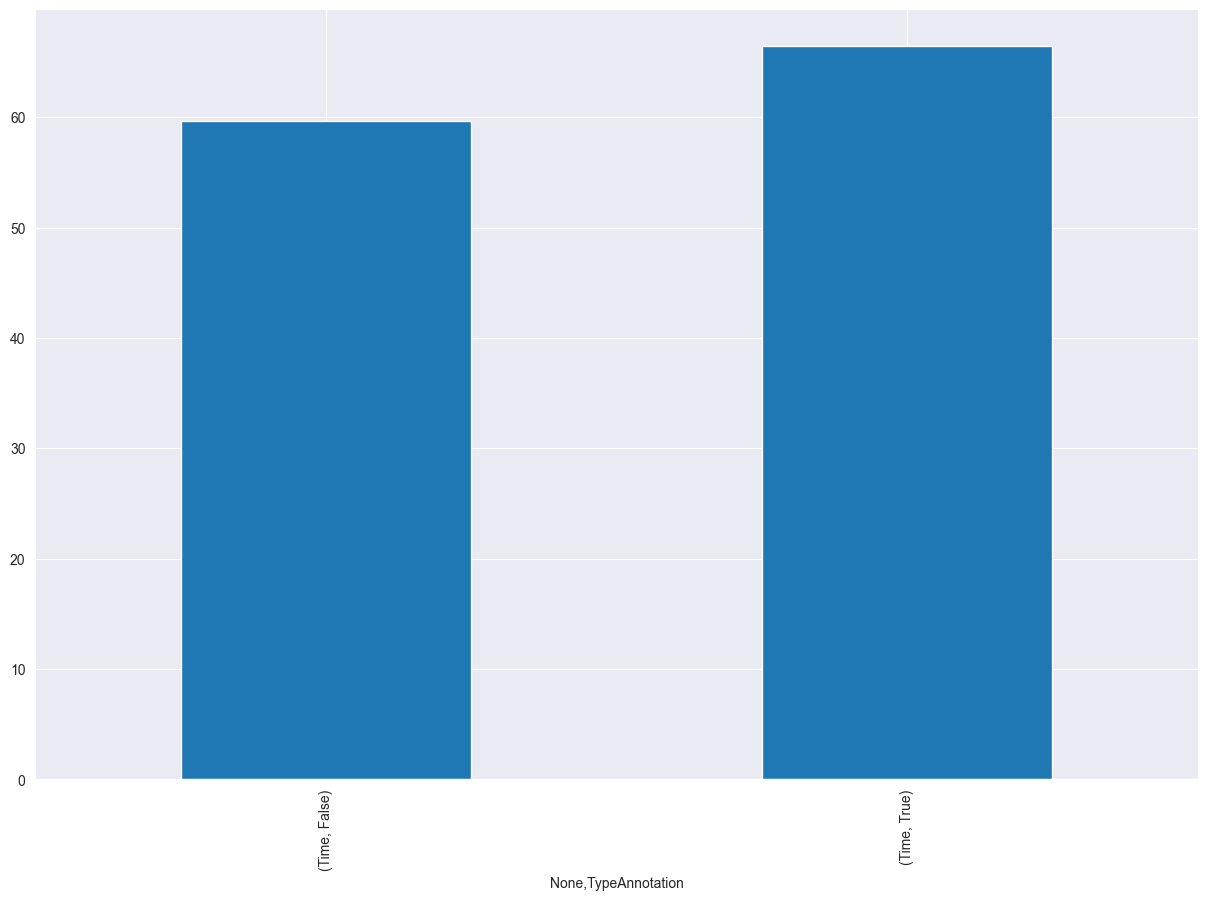

In [94]:
# compute if type annotated snippets were faster on average than non type annotated snippets
df_results_overall.groupby(['TypeAnnotation']).agg({'Time': 'mean'}).unstack().T.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.show()

Do `Type Annotations` make people faster when we differentiate between `Meaningful` snippets?

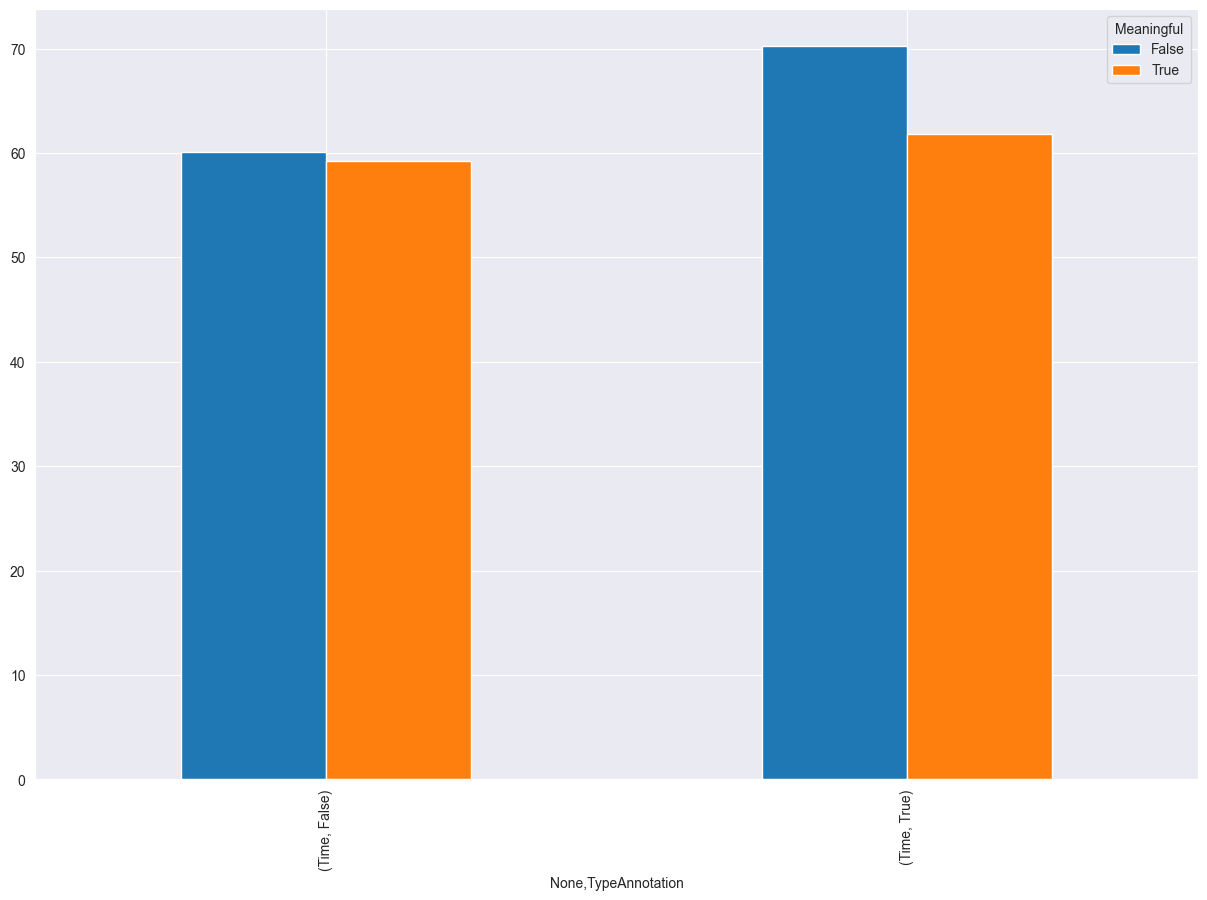

In [95]:
df_results_overall.groupby(['Meaningful', 'TypeAnnotation']).agg({'Time': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10))
plt.show()

Are snippets with `Type Annotations` more correct?

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1592773364.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[0], color='orange', linestyle='--', label='Max False') # False
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1592773364.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[1], color='green', linestyle='--', label='Max True') # True
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1592773364.

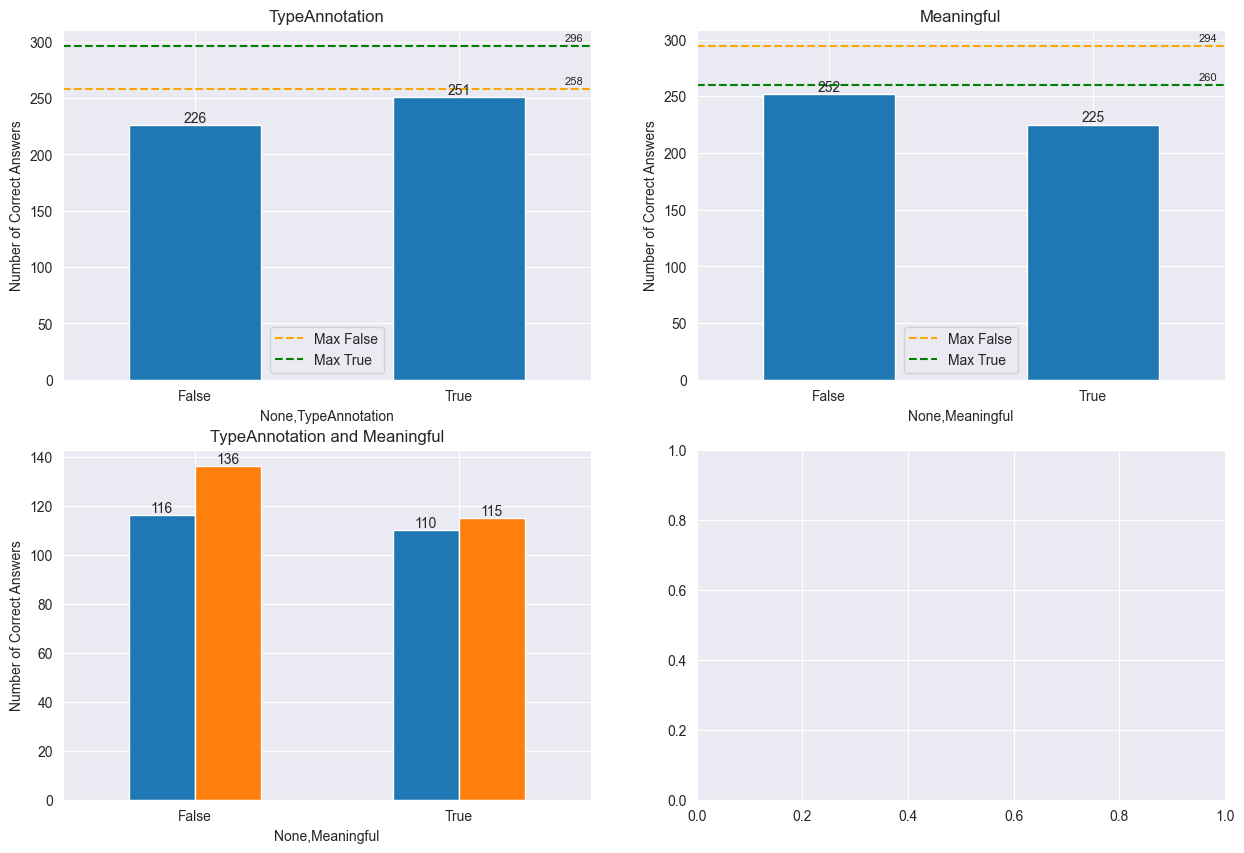

In [96]:
snippets_grouping: list[str|list[str]] = ['TypeAnnotation', 'Meaningful',  ['TypeAnnotation', 'Meaningful'],]

# create a plot consisting of len(snippets_grouping) subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, x in enumerate(snippets_grouping):
    ax = df_results_overall.groupby(x).agg({'CorrectAnswer': np.count_nonzero}).unstack().T.plot(kind='bar', ax=axs[i // 2, i % 2], title=(lambda x: f'{x[0]} and {x[1]}' if len(x) == 2 else x)(x), ylabel='Number of Correct Answers', legend=False)

    ax.set_xticklabels(['False', 'True'], rotation=0)

    if len(x) != 2:
        ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[0], color='orange', linestyle='--', label='Max False') # False
        ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[1], color='green', linestyle='--', label='Max True') # True
        ax.legend(loc='lower center')
    
    for line in ax.lines:
        ax.annotate(str(int(line.get_ydata()[0])), xy=(line.get_xdata()[0], line.get_ydata()[0]), xytext=(280, 2), textcoords='offset points', ha='right', va='bottom', fontsize=8)

    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

Are snippets that are `Meaningful` more correct?

In [97]:
df_results_overall.groupby(['TypeAnnotation', 'Meaningful']).agg({'CorrectAnswer': 'count'}).unstack()

CorrectAnswer      
Meaningful             False True 
TypeAnnotation                    
False                    132   126
True                     162   134

A better representation of this:

In [98]:
correct_TA_M: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].sum()
correct_TA_L: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].sum()
correct_L_M: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].sum()
correct_L_L: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].sum()

total_TA_M: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].count()
total_TA_L: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].count()
total_L_M: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].count()
total_L_L: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].count()

print(f'Type Annotation and Meaningful: {correct_TA_M}/{total_TA_M} = {correct_TA_M / total_TA_M}')
print(f'Type Annotation and Meaningless: {correct_TA_L}/{total_TA_L} = {correct_TA_L / total_TA_L}')
print(f'No Type Annotation and Meaningful: {correct_L_M}/{total_L_M} = {correct_L_M / total_L_M}')
print(f'No Type Annotation and Meaningless: {correct_L_L}/{total_L_L} = {correct_L_L / total_L_L}')

print(f'\nType Annotation: {correct_TA_M + correct_TA_L}/{total_TA_M + total_TA_L} = {(correct_TA_M + correct_TA_L) / (total_TA_M + total_TA_L)}')
print(f'No Type Annotation: {correct_L_M + correct_L_L}/{total_L_M + total_L_L} = {(correct_L_M + correct_L_L) / (total_L_M + total_L_L)}')
print(f'Meaningful: {correct_TA_M + correct_L_M}/{total_TA_M + total_L_M} = {(correct_TA_M + correct_L_M) / (total_TA_M + total_L_M)}')
print(f'Meaningless: {correct_TA_L + correct_L_L}/{total_TA_L + total_L_L} = {(correct_TA_L + correct_L_L) / (total_TA_L + total_L_L)}')


Type Annotation and Meaningful: 115/134 = 0.8582089552238806
Type Annotation and Meaningless: 136/162 = 0.8395061728395061
No Type Annotation and Meaningful: 110/126 = 0.873015873015873
No Type Annotation and Meaningless: 116/132 = 0.8787878787878788

Type Annotation: 251/296 = 0.847972972972973
No Type Annotation: 226/258 = 0.875968992248062
Meaningful: 225/260 = 0.8653846153846154
Meaningless: 252/294 = 0.8571428571428571


Correct Answers per Snippet

In [99]:
snippet_correctness_df: DataFrame = DataFrame(columns=['Task', 'Correctness', 'Meaningful', 'TypeAnnotation'])

counter: int = 0

for task in all_tasks:
    correct_TA_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].sum()
    correct_TA_L: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].sum()
    correct_L_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].sum()
    correct_L_L: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].sum()

    total_TA_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].count()
    total_TA_L: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].count()
    total_L_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].count()
    total_L_L: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].count()

    print(f'\nTask: {task}')
    
    print(f'\nNo Type Annotation: {correct_L_M + correct_L_L}/{total_L_M + total_L_L} = {(correct_L_M + correct_L_L) / (total_L_M + total_L_L)}')
    print(f'Type Annotation: {correct_TA_M + correct_TA_L}/{total_TA_M + total_TA_L} = {(correct_TA_M + correct_TA_L) / (total_TA_M + total_TA_L)}')

    snippet_correctness_df.loc[counter] = [task, correct_TA_M / total_TA_M, True, True]
    snippet_correctness_df.loc[counter + 1] = [task, correct_TA_L / total_TA_L, False, True]
    snippet_correctness_df.loc[counter + 2] = [task, correct_L_M / total_L_M, True, False]
    snippet_correctness_df.loc[counter + 3] = [task, correct_L_L / total_L_L, False, False]

    counter += 4


Task: arrayAverage

No Type Annotation: 10/11 = 0.9090909090909091
Type Annotation: 18/18 = 1.0

Task: binarySearch

No Type Annotation: 13/14 = 0.9285714285714286
Type Annotation: 11/12 = 0.9166666666666666

Task: binaryToDecimal

No Type Annotation: 10/13 = 0.7692307692307693
Type Annotation: 13/15 = 0.8666666666666667

Task: bubbleSort

No Type Annotation: 11/12 = 0.9166666666666666
Type Annotation: 12/16 = 0.75

Task: capitalizeFirstLetter

No Type Annotation: 10/10 = 1.0
Type Annotation: 18/18 = 1.0

Task: commonChars

No Type Annotation: 8/14 = 0.5714285714285714
Type Annotation: 10/14 = 0.7142857142857143

Task: containsSubstring

No Type Annotation: 8/10 = 0.8
Type Annotation: 10/14 = 0.7142857142857143

Task: countIntegerInterval

No Type Annotation: 12/14 = 0.8571428571428571
Type Annotation: 9/16 = 0.5625

Task: countLetters

No Type Annotation: 8/10 = 0.8
Type Annotation: 15/16 = 0.9375

Task: crossSum

No Type Annotation: 8/12 = 0.6666666666666666
Type Annotation: 15/17 =

Statistic for the participants:
- Number of Snippets
- Number of Correct / Incorrect Snippets
- Meaningful / Meaningless Snippets
- Mean Time for Type Annotation / No Type Annotation
- Overall Time Taken in Minutes

We start with the participants in the meaningless group.

In [100]:
print(f'Meaningless Participants')
for participant in meaningless_participants:
    print(f'\nParticipant {participant}')
    number_of_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].count()
    correct_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].sum()
    print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')

    mean_time: float = df_results_overall.query(f'ID == "{participant}"')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time} seconds')

    mean_time_TA: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['Time'].mean()
    mean_time_L: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time_TA} seconds with Type Annotations and {mean_time_L} seconds without Type Annotations, thus the change is {mean_time_L - mean_time_TA} seconds')

    overall_time: float = df_results_overall.query(f'ID == @participant')['Time'].sum()
    print(f'Participant {participant} took {overall_time // 60} minutes and {overall_time % 60} seconds in total')

print(f'\n\nMeaningful Participants')

for participant in meaningful_participants:

    print(f'\nParticipant {participant}')
    number_of_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].count()
    correct_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].sum()
    print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')

    mean_time: float = df_results_overall.query(f'ID == "{participant}"')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time} seconds')

    mean_time_TA: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['Time'].mean()
    mean_time_L: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time_TA} seconds with Type Annotations and {mean_time_L} seconds without Type Annotations, thus the change is {mean_time_L - mean_time_TA} seconds')

    overall_time: float = df_results_overall.query(f'ID == @participant')['Time'].sum()
    print(f'Participant {participant} took {overall_time // 60} minutes and {overall_time % 60} seconds in total')

Meaningless Participants

Participant 10723
Participant 10723 has 18/18 correct snippets: 1.0
Participant 10723 has a mean time of 86.66666666666667 seconds
Participant 10723 has a mean time of 85.8 seconds with Type Annotations and 87.75 seconds without Type Annotations, thus the change is 1.9500000000000028 seconds
Participant 10723 took 26 minutes and 0 seconds in total

Participant 18457
Participant 18457 has 18/18 correct snippets: 1.0
Participant 18457 has a mean time of 69.66666666666667 seconds
Participant 18457 has a mean time of 76.16666666666667 seconds with Type Annotations and 66.41666666666667 seconds without Type Annotations, thus the change is -9.75 seconds
Participant 18457 took 20 minutes and 54 seconds in total

Participant 18868
Participant 18868 has 17/20 correct snippets: 0.85
Participant 18868 has a mean time of 71.1 seconds
Participant 18868 has a mean time of 74.7 seconds with Type Annotations and 67.5 seconds without Type Annotations, thus the change is -7.200

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1733495305.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1733495305.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1733495305.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1733495305.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Participan

Check for the number of correct snippets as a ratio for participants.

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1026994056.py:13: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter] = [participant, correct_TA / total_TA, True]
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1026994056.py:14: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter + 1] = [participant, correct_L / total_L, False]
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1026994056.py:13: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter] = [participant, correct_TA / total_TA, True]
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/1026994056.py:14: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter + 1] = [participant, correct_L / total_L, False]
/var/folders/_k/xv0m9bhx30

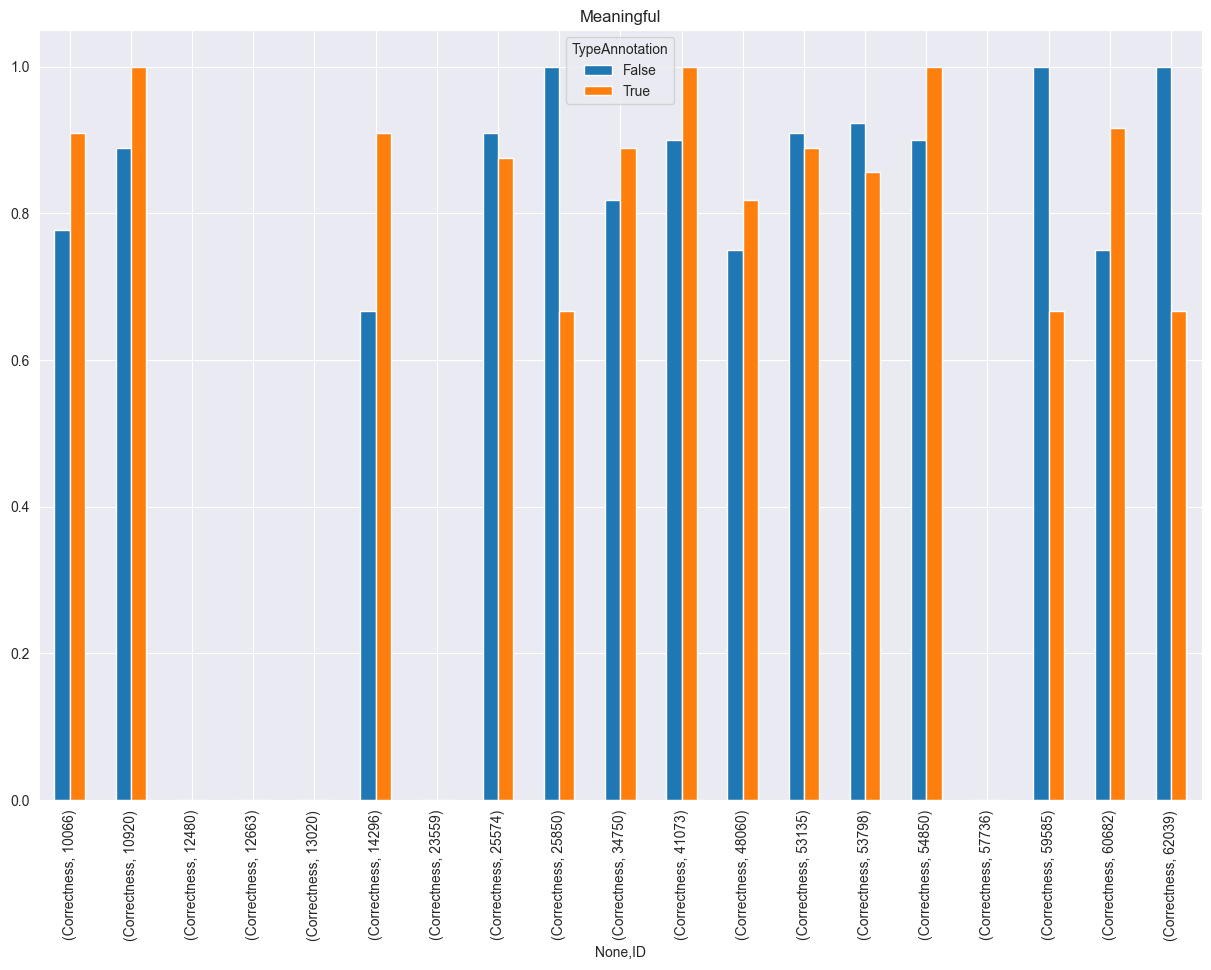

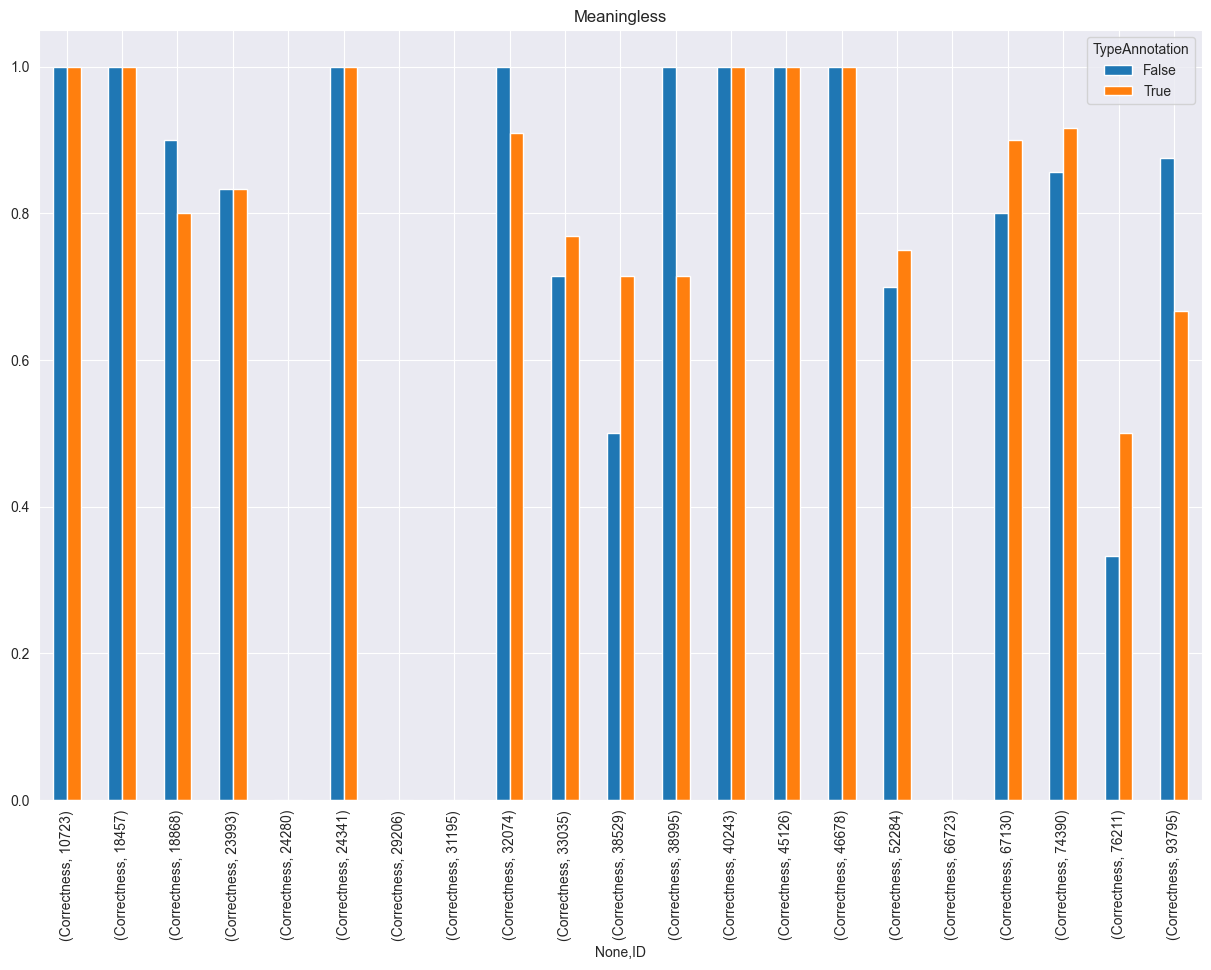

In [101]:
correctness_df_by_participant_meaningful: DataFrame = DataFrame(columns=['ID', 'Correctness', 'TypeAnnotation'])
correctness_df_by_participant_meaningless: DataFrame = DataFrame(columns=['ID', 'Correctness', 'TypeAnnotation'])


counter: int = 0
for participant in meaningful_participants:
    correct_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['CorrectAnswer'].sum()
    correct_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['CorrectAnswer'].sum()

    total_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['CorrectAnswer'].count()
    total_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['CorrectAnswer'].count()

    correctness_df_by_participant_meaningful.loc[counter] = [participant, correct_TA / total_TA, True]
    correctness_df_by_participant_meaningful.loc[counter + 1] = [participant, correct_L / total_L, False]

    counter += 2

counter = 0
for participant in meaningless_participants:
    correct_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['CorrectAnswer'].sum()
    correct_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['CorrectAnswer'].sum()

    total_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['CorrectAnswer'].count()
    total_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['CorrectAnswer'].count()

    correctness_df_by_participant_meaningless.loc[counter] = [participant, correct_TA / total_TA, True]
    correctness_df_by_participant_meaningless.loc[counter + 1] = [participant, correct_L / total_L, False]

    counter += 2

correctness_df_by_participant_meaningful.groupby(['TypeAnnotation', 'ID']).agg({'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10), title="Meaningful")

correctness_df_by_participant_meaningless.groupby(['TypeAnnotation', 'ID']).agg({'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10), title="Meaningless")
plt.show()

Check for the time and correct answers per code snippet.

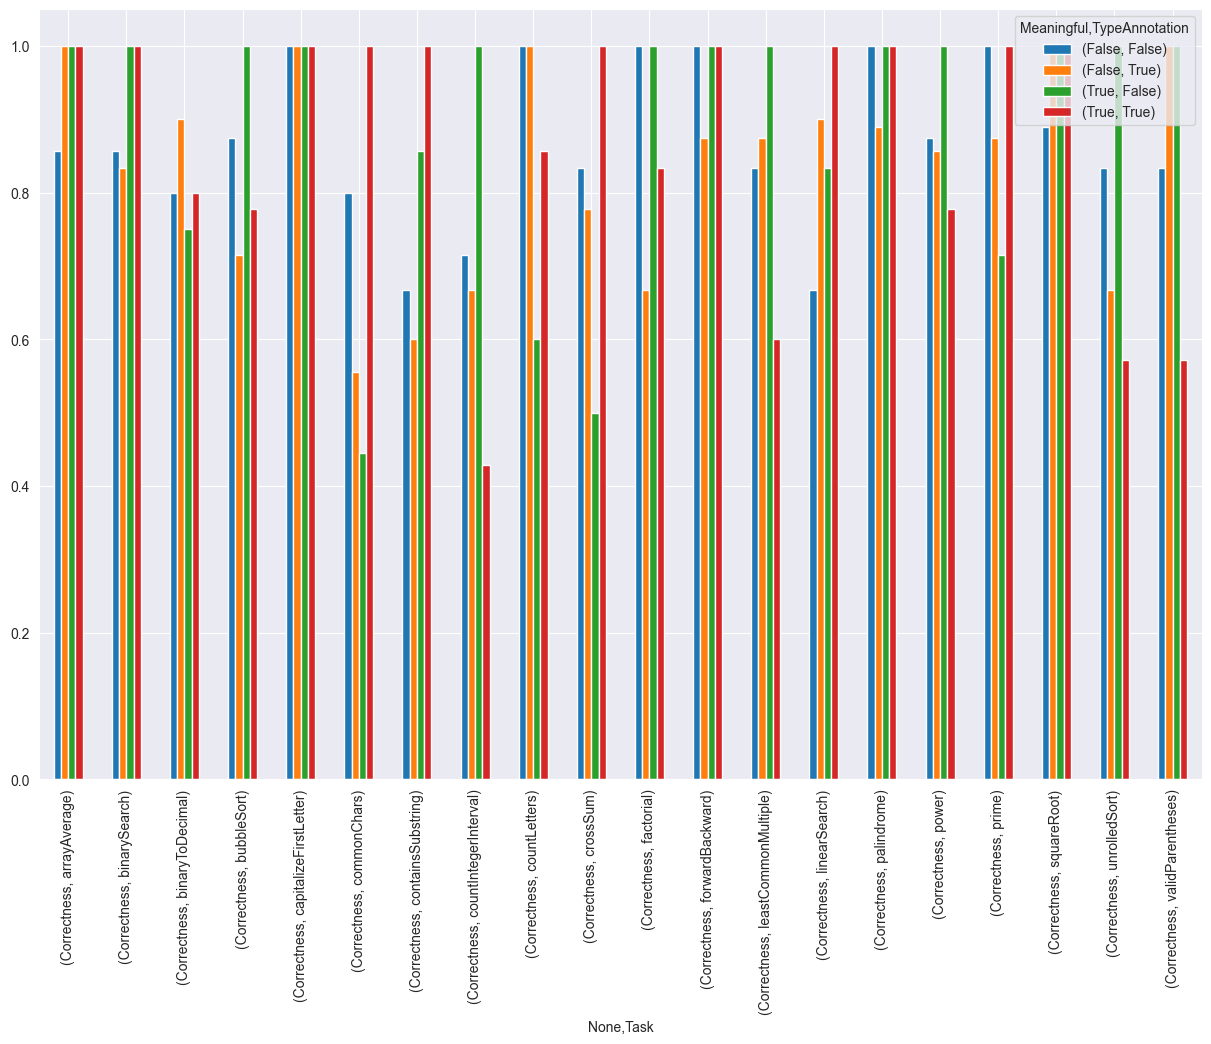

In [102]:
snippet_correctness_df.groupby(['Meaningful', 'TypeAnnotation', 'Task']).agg({'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10))

plt.show()

### Difficulty Rating

First let's check how the difficulty is for each task. I think this would be best as a table?

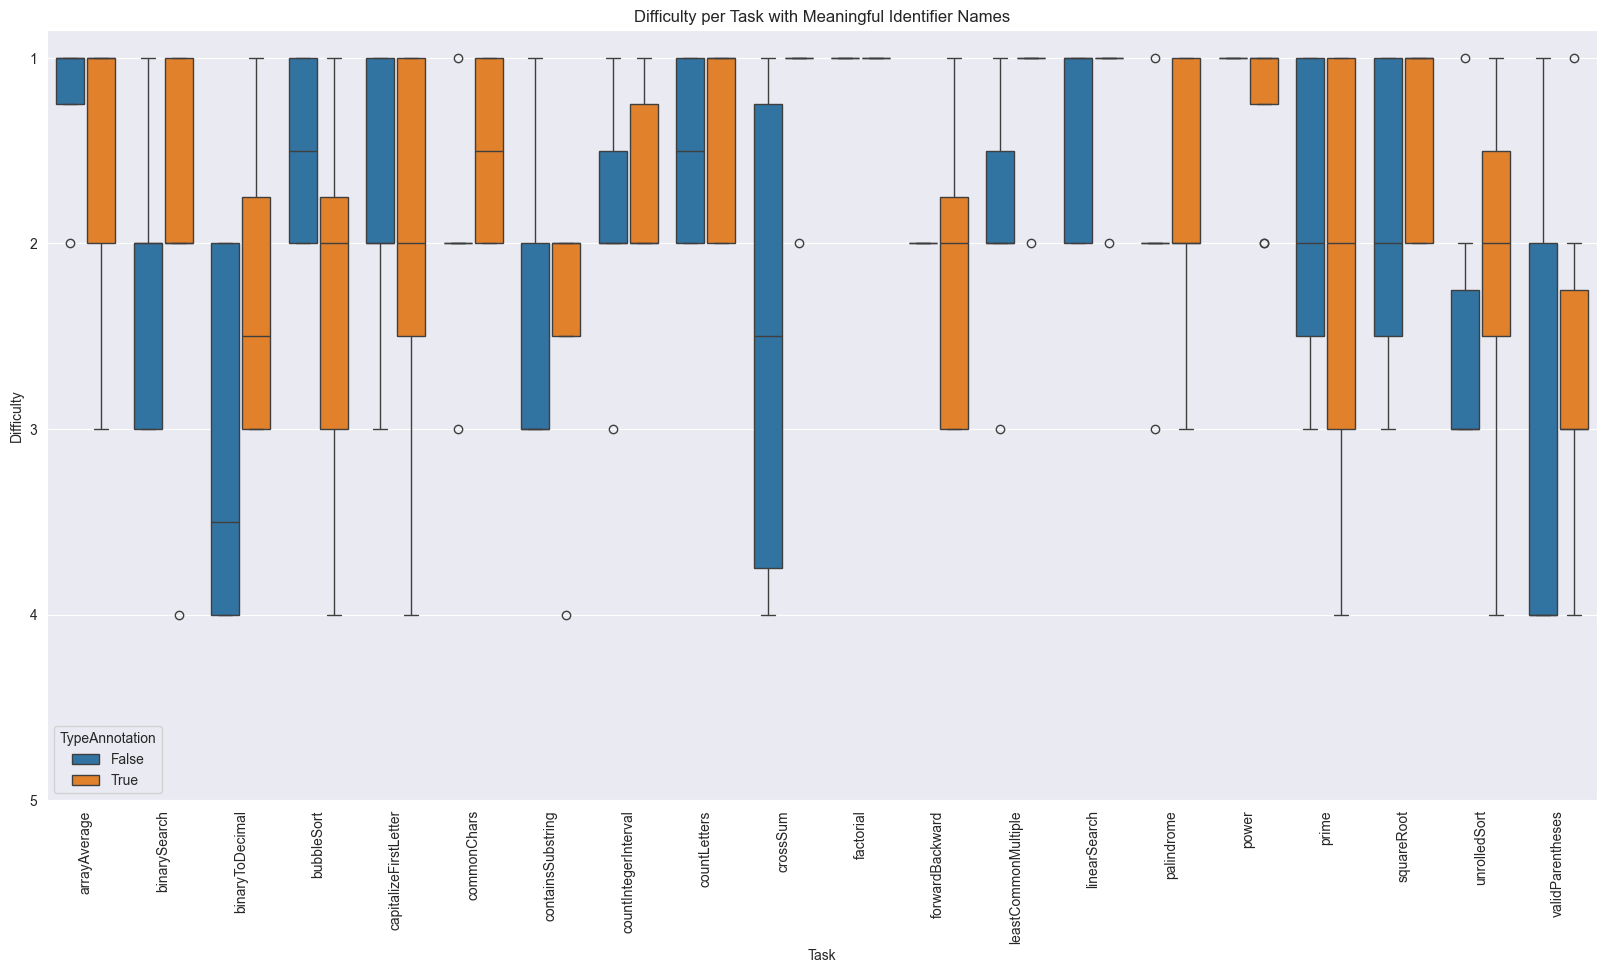

In [103]:
plt.figure(figsize=(20, 10))
sns.boxplot(df_results_overall.query(f'`Meaningful` == True'), x='Task', y='Difficulty', hue='TypeAnnotation', 
            gap=.1, 
            # inner="quart", 
            # cut=0, 
            order=all_tasks,
            # split=True,
            )

plt.xticks(all_tasks, rotation=90)
plt.yticks(np.arange(1, 6, 1))
plt.title('Difficulty per Task with Meaningful Identifier Names') 

plt.show()

And now with meaningless identifier names.

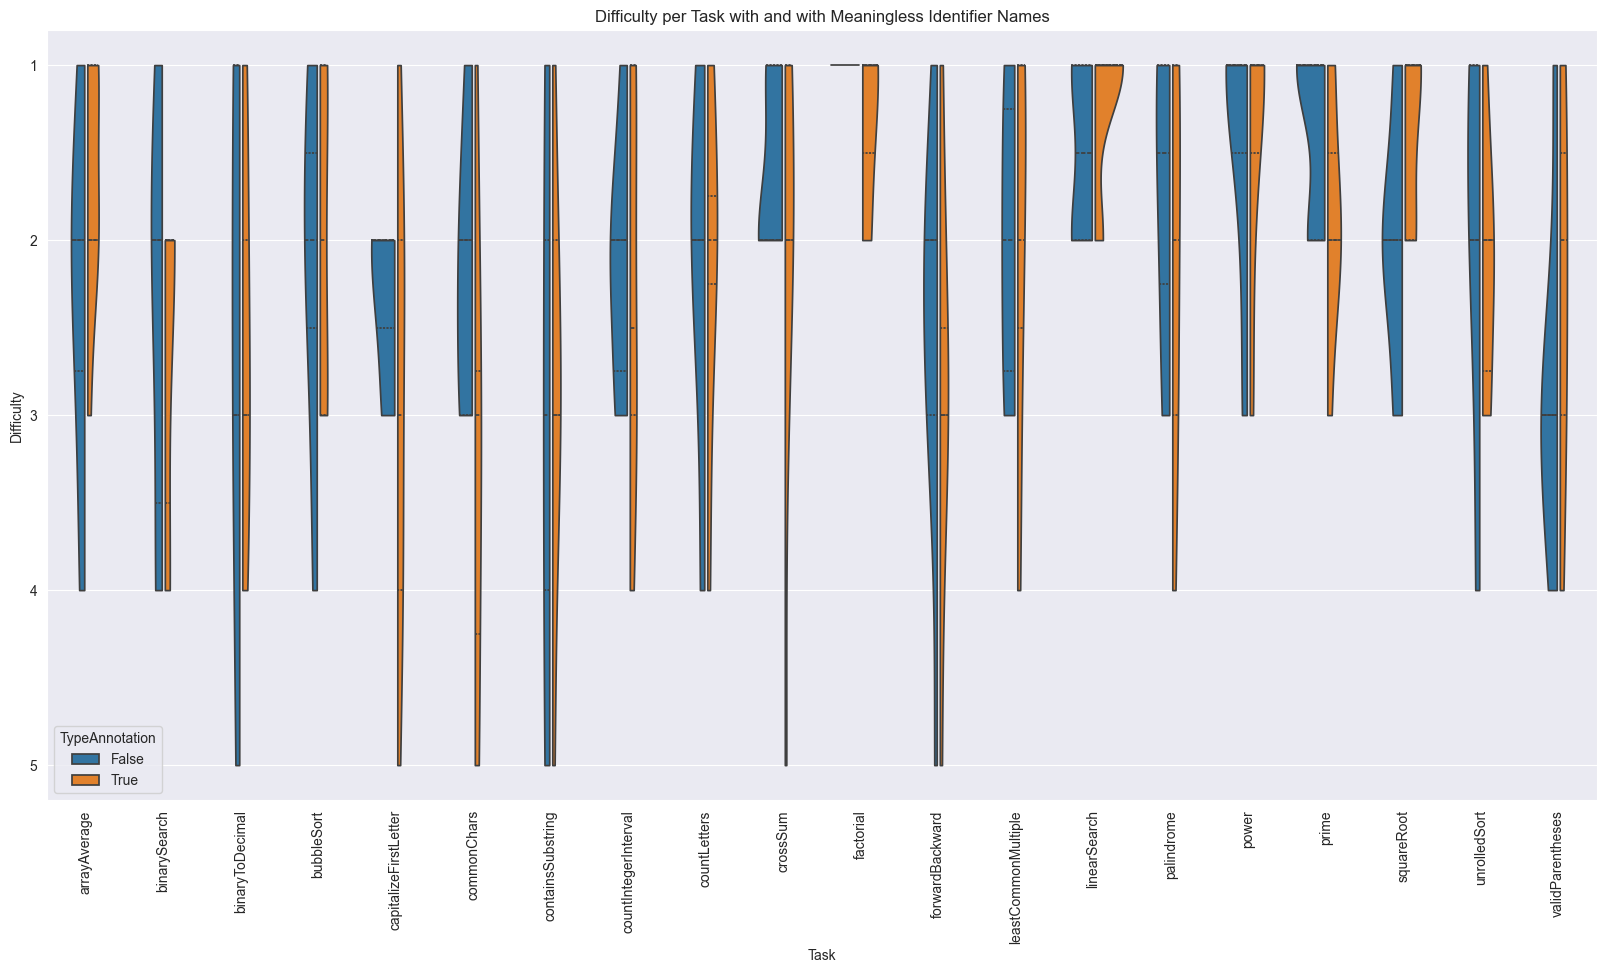

In [104]:
plt.figure(figsize=(20, 10))
sns.violinplot(df_results_overall.query(f'`Meaningful` == False'), x='Task', y='Difficulty',
               hue='TypeAnnotation', 
            gap=.1, 
            inner="quart", 
            cut=0, 
            order=all_tasks,
            split=True,
            )

plt.xticks(all_tasks, rotation=90)
plt.yticks(np.arange(1, 6, 1))
plt.title('Difficulty per Task with and with Meaningless Identifier Names') 

plt.show()

The difficulty that each participant felt.

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/3676903804.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_L_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Difficulty'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0+0.35, widths=0.6)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/3676903804.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_TA_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Difficulty'] for participant in meaningful_participants], labels=mea

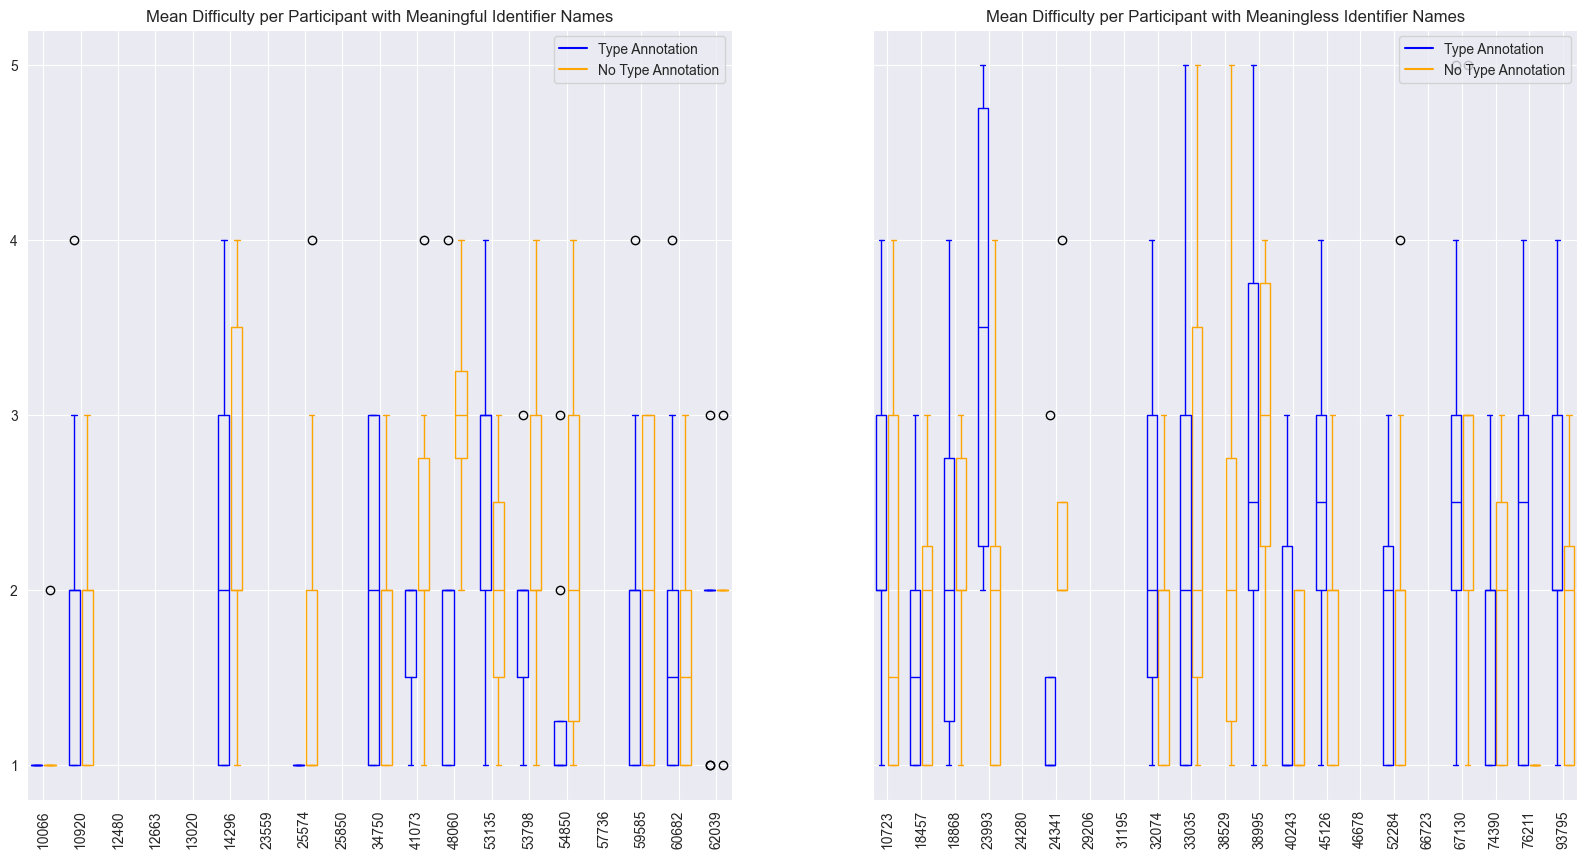

In [105]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), sharey=True)

# first plot
plot_L_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Difficulty'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0+0.35, widths=0.6)
plot_TA_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Difficulty'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0-0.35, widths=0.6)

# first plot settings
axs[0].set_title('Mean Difficulty per Participant with Meaningful Identifier Names')
axs[0].set_xticks(np.arange(0, len(meaningful_participants) * 2, 2), meaningful_participants, rotation=90)
axs[0].set_yticks(np.arange(1, 6, 1))
define_box_properties(plot_TA_M, 'blue', 'Type Annotation', axs[0])
define_box_properties(plot_L_M, 'orange', 'No Type Annotation', axs[0])

# second plot
plot_L_L = axs[1].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == False')['Difficulty'] for participant in meaningless_participants], labels=meaningless_participants, positions=np.arange(len(meaningless_participants))*2.0+0.35, widths=0.6)
plot_TA_L = axs[1].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == False')['Difficulty'] for participant in meaningless_participants], labels=meaningless_participants, positions=np.arange(len(meaningless_participants))*2.0-0.35, widths=0.6)

# second plot settings
axs[1].set_title('Mean Difficulty per Participant with Meaningless Identifier Names')
axs[1].set_xticks(np.arange(0, len(meaningless_participants) * 2, 2), meaningless_participants, rotation=90)
axs[1].set_yticks(np.arange(1, 6, 1))
define_box_properties(plot_TA_L, 'blue', 'Type Annotation', axs[1])
define_box_properties(plot_L_L, 'orange', 'No Type Annotation', axs[1])

plt.show()


Correct Answer by Difficulty

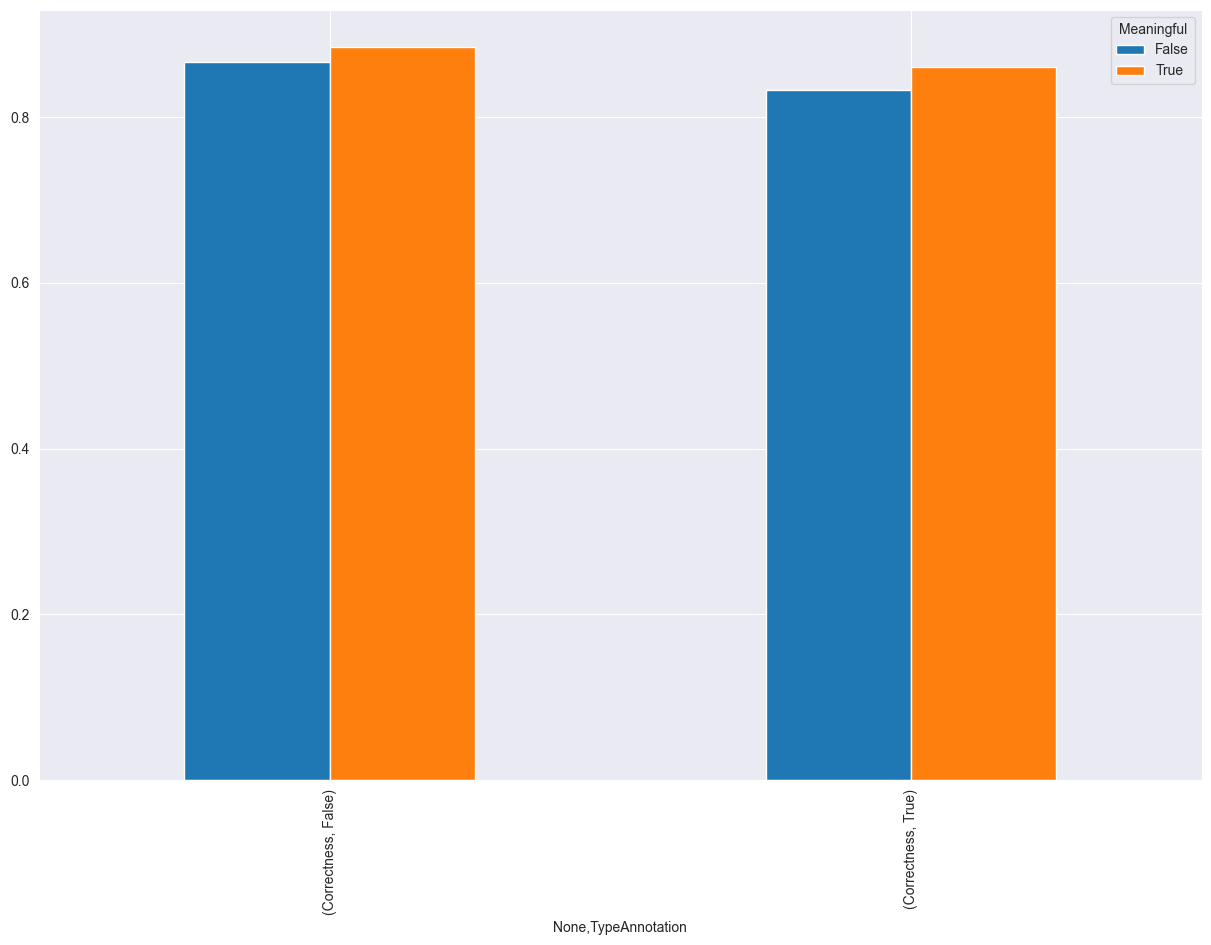

In [106]:
snippet_correctness_df.groupby(['Meaningful', 'TypeAnnotation']).agg({'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10))

plt.show()

Difficulty count by snippet

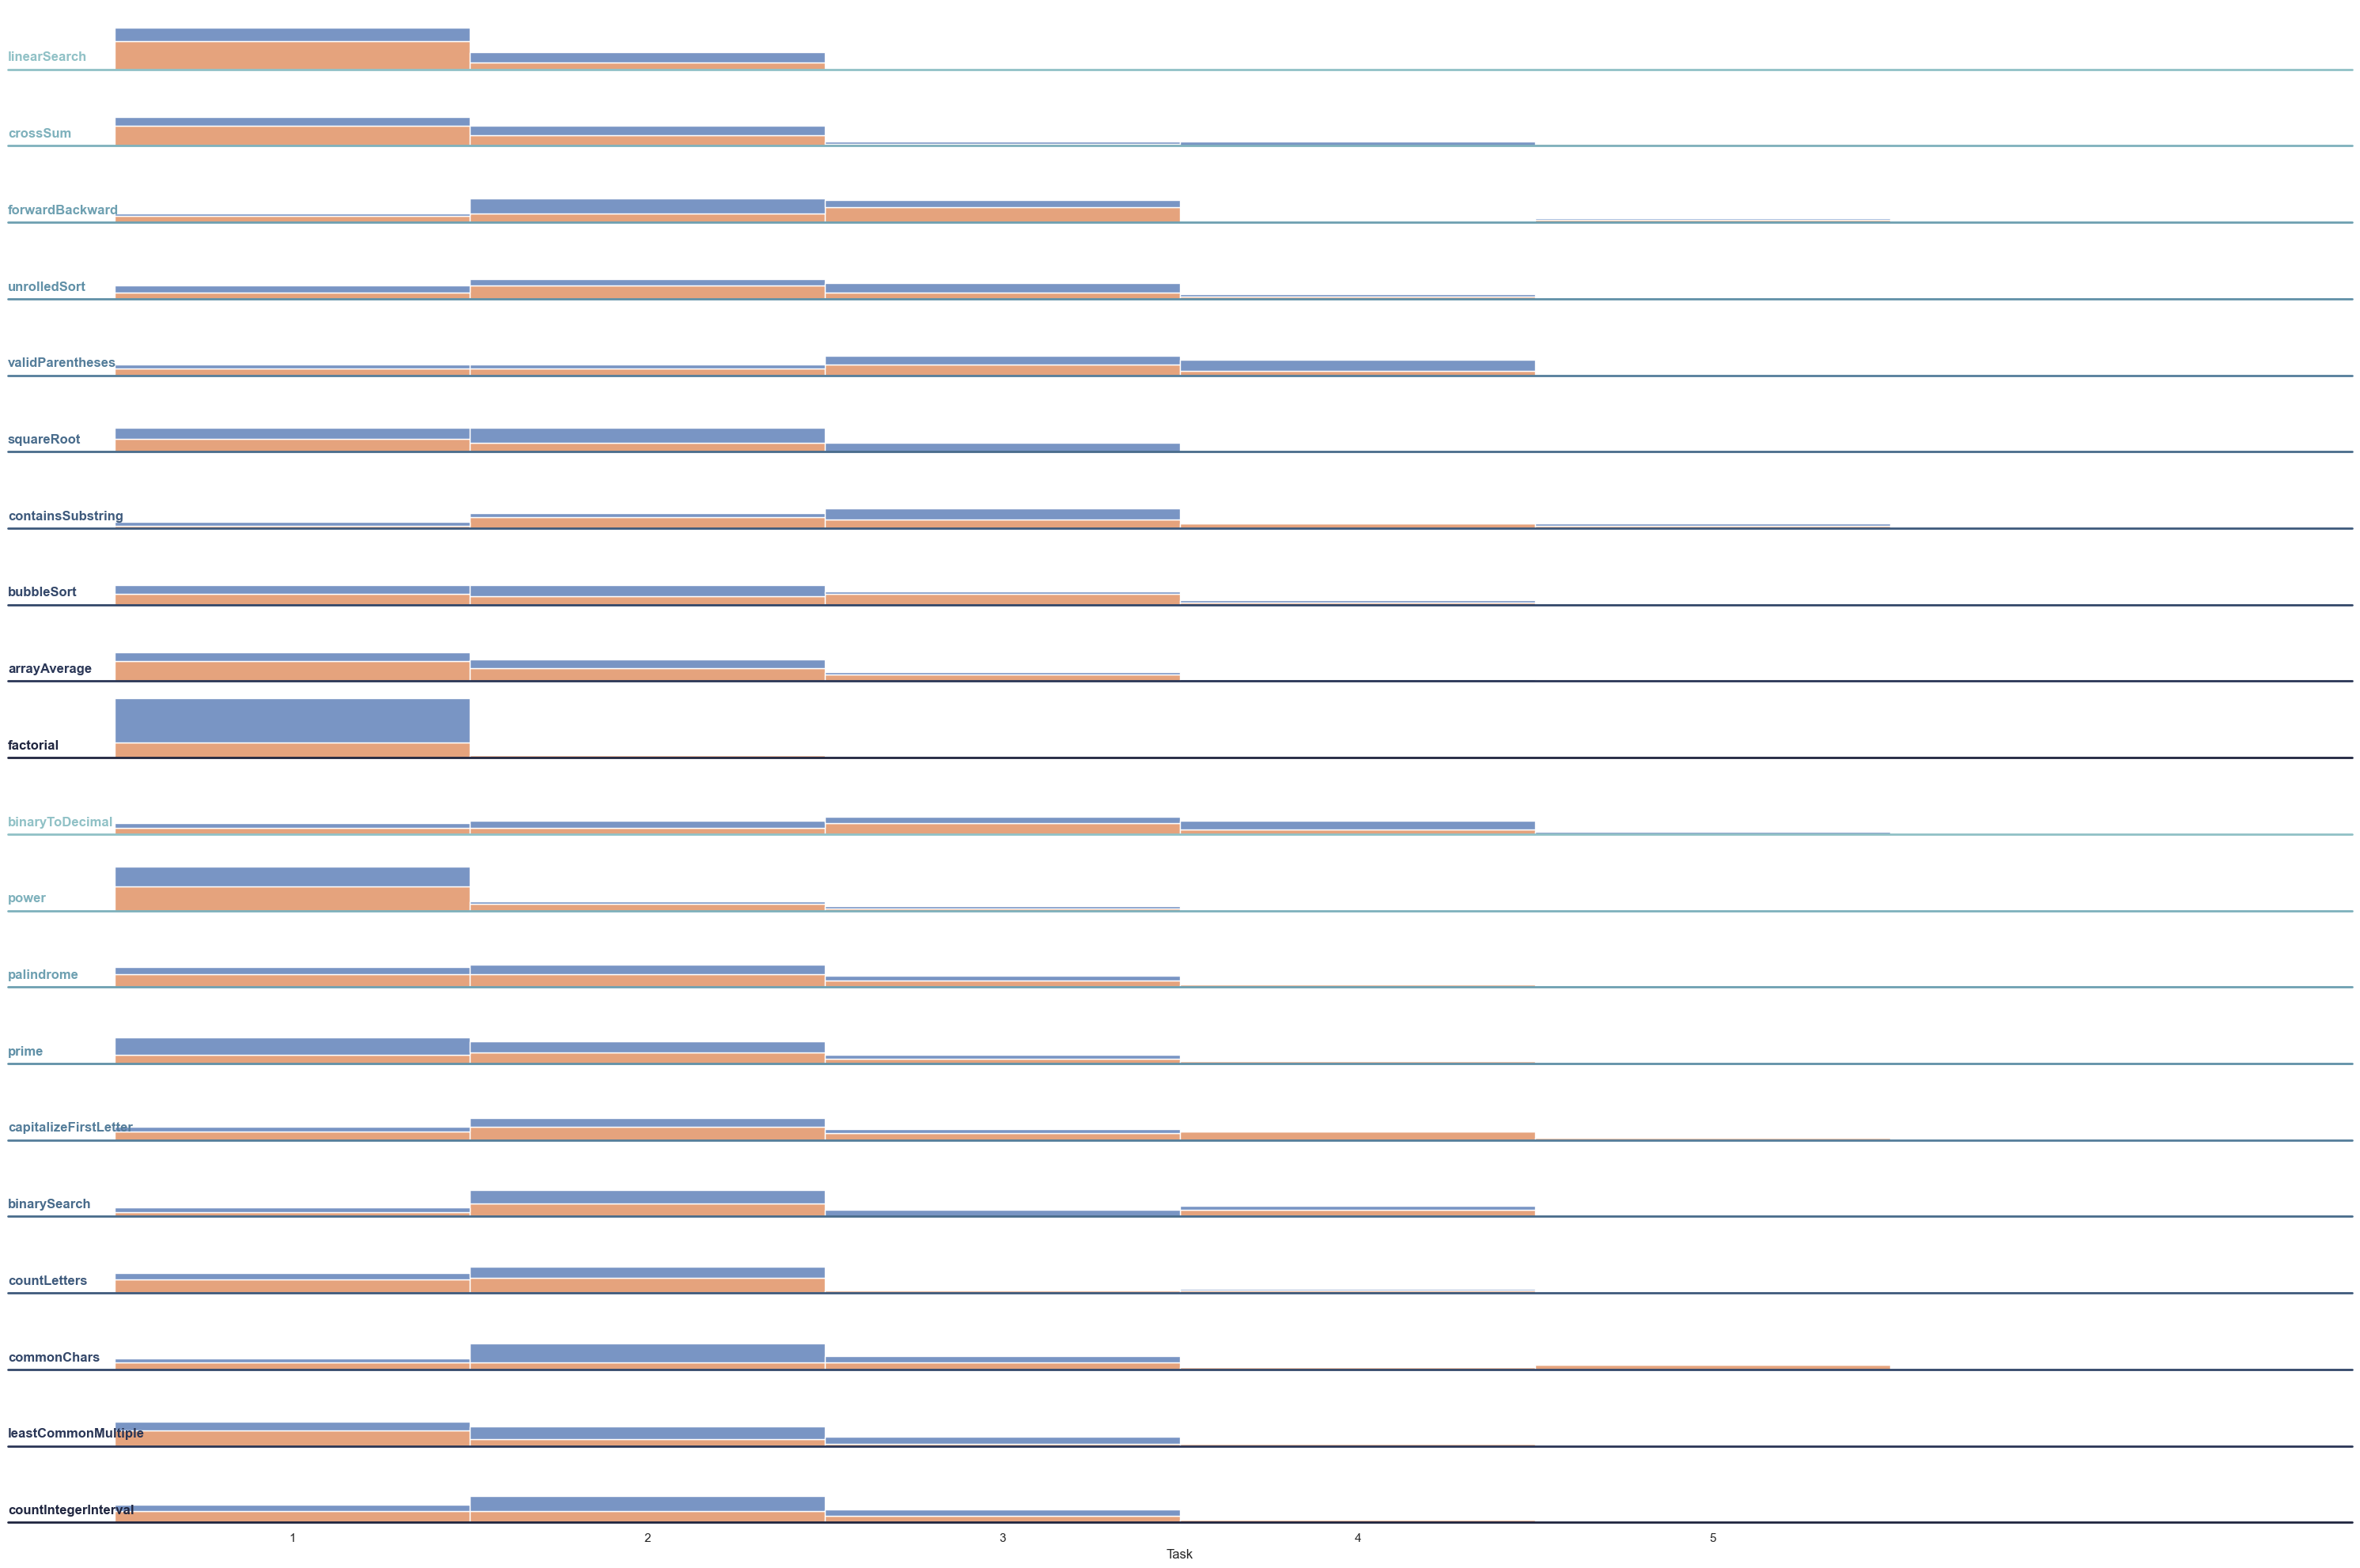

In [107]:
sns.set_theme(style="white")
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(df_results_overall, row="Task", 
                #   col="Type Annotation",
                  hue="Task", 
                  height=1, 
                  aspect=30, 
                  palette=pal,
                  )
g.map_dataframe(sns.histplot, x="Difficulty", hue="TypeAnnotation", binwidth=1, binrange=(1, 6), multiple="stack")
# g.map_dataframe(sns.kdeplot, x="Difficulty", clip=(1, 5), fill=True)
# g.map_dataframe(sns.kdeplot, x="Difficulty", hue='Type Annotation', clip_on=(1, 5), color="black", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "Task")
g.figure.subplots_adjust(hspace=-.5)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xticks=np.arange(1, 6, 1))
g.despine(bottom=True, left=True)

g.figure.tight_layout()


## Display META Data

In [108]:
# if the line 'Total' does not exist, create it
if not 'Total' in df_meta_data.index:
    df_meta_data.loc['Total'] = df_meta_data[[col for col in meta_data_columns if col not in unnecessary_columns_meta_data]].sum()
    # add the number of times a participant did not finish all snippets to the 'Total' line
    df_meta_data.loc['Total','NumberOfMissingSnippets'] = df_meta_data.groupby('ID')['NumberOfMissingSnippets'].any().value_counts()[True]
    # df_meta_data.loc['Total']['NumberOfMissingSnippets'] = df_meta_data['NumberOfMissingSnippets'].any()
    df_meta_data = df_meta_data.fillna('')

# set the background color of the dataframe value to red if the value is False
df_meta_data.style.applymap(lambda x: 'background-color: darkred' if x == False else '')

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/167980355.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_meta_data = df_meta_data.fillna('')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_4694/167980355.py:10: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_meta_data.style.applymap(lambda x: 'background-color: darkred' if x == False else '')


,ID,GazeDataFilled,InterviewData,OverallTime,Meaningful,Finished,NumberOfMissingSnippets,PersonalInformation,ResultsOverall
0,10066,,,,1,True,0,True,True
1,10723,,,,0,True,0,True,True
2,10920,,,,1,True,0,True,True
3,12480,,,,1,True,0,True,True
6,14296,,,,1,False,1,True,True
7,18457,,,,0,True,0,True,True
8,18868,,,,0,True,0,True,True
9,23559,,,,1,False,3,True,True
10,23993,,,,0,True,0,True,True
12,24341,,,,0,False,1,True,True


### Overview

The corrected p-values for the mixed linear regression models.

In [109]:

# Example p-values
p_values = np.array([0.43, 0.033, 0.056, 0.031, 0.33, 0.1, 0.55, 0.97])

# Perform Benjamini-Hochberg FDR correction
alpha = 0.05
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

# Output the results
print("Original p-values:", p_values)
print("Corrected p-values:", pvals_corrected)
print("Rejected hypotheses:", rejected)

Original p-values: [0.43  0.033 0.056 0.031 0.33  0.1   0.55  0.97 ]
Corrected p-values: [0.57333333 0.132      0.14933333 0.132      0.528      0.2
 0.62857143 0.97      ]
Rejected hypotheses: [False False False False False False False False]
